In [14]:
# Load Library
import math
import numpy as np
import matplotlib.pyplot as plt
import sklearn
import libsvm
import pandas as pd
import seaborn as sns
from sklearn.metrics import f1_score,confusion_matrix,accuracy_score,mean_absolute_error

np.random.seed(42)
%matplotlib inline

In [15]:
# Load Train Data
Data = pd.read_csv("Data/Raw/train.csv")
Data['Neighbourhood'] = Data['Neighbourhood'].astype(str)
Y = Data['Decision'].to_numpy()
X = Data.drop(['Decision'], axis=1)
# Load Test Data
Test = pd.read_csv("Data/Raw/test.csv")
Test['Neighbourhood'] = Test['Neighbourhood'].astype(str)

In [16]:
def Encode(airbnb):
    for column in airbnb.columns[airbnb.columns.isin(['Room_type', 'Month','Neighbourhood'])]:
        airbnb[column] = airbnb[column].factorize()[0]
    return airbnb

X_data = Encode(X.copy())
Test_data = Encode(Test.copy())

In [17]:
# Split Data: 20% Test, 80% Train
from sklearn.model_selection import train_test_split
# X_train, X_test, y_train, y_test = train_test_split(X_data,Y, test_size=0.2, random_state= 42)
X_train, X_test, y_train, y_test = train_test_split(X_data, Y, test_size=0.20, random_state= 42, stratify= Y)

# Neural Network using Pytorch

In [18]:
# Load Library
import torch

In [19]:
#feature scaling
from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
X = sc.fit_transform(X_data)
# X_test = sc.fit_transform(X_test)
# X_train = sc.fit_transform(X_train)

In [20]:
# Split Data: 20% Test, 80% Train
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X,Y, test_size=0.2, random_state= 42)

In [21]:
#defining dataset class
from torch.utils.data import Dataset, DataLoader
class dataset(Dataset):
  def __init__(self,x,y):
    self.x = torch.tensor(x,dtype=torch.float32)
    self.y = torch.tensor(y,dtype=torch.float32)
    self.length = self.x.shape[0]
 
  def __getitem__(self,idx):
    return self.x[idx],self.y[idx]
  def __len__(self):
    return self.length

trainset = dataset(X_train,y_train) 
trainloader = DataLoader(trainset,batch_size=64,shuffle=False)

## Experiment 1: 3 Layer with Sigmoid Activation

In [278]:
#defining the network
from torch import nn
from torch.nn import functional as F
class Net(nn.Module):
  def __init__(self,input_shape):
    super(Net,self).__init__()
    self.fc1 = nn.Linear(input_shape, 32) 
    self.fc2 = nn.Linear(32, 64)
    self.fc3 = nn.Linear(64, 1)
    
  def forward(self,x):
    x = torch.relu(self.fc1(x))
    x = torch.relu(self.fc2(x))
    x = torch.sigmoid(self.fc3(x))
    return x

In [12]:
#hyper parameters
learning_rate = 0.001
epochs = 700

In [280]:
# Model , Optimizer, Loss
loss_fn = nn.BCELoss()
model = Net(input_shape=X_train.shape[1])
optimizer = torch.optim.SGD(model.parameters(),lr=learning_rate)

val_losses = []
test_accur = []
train_accur = []
for i in range(epochs):
  for j,(X_batch,y_batch) in enumerate(trainloader):
    model.train()
    #calculate output
    output = model(X_batch)
 
    #calculate loss
    loss = loss_fn(output,y_batch.reshape(-1,1))

    #backprop
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

  if i%100 == 0:
    model.eval()
    with torch.no_grad():
        #accuracy train
        predicted_train = model(torch.tensor(X_train,dtype=torch.float32))
        train_acc = (predicted_train.reshape(-1).detach().numpy().round() == y_train).mean()
        
        #accuracy test
        predicted_test = model(torch.tensor(X_test,dtype=torch.float32))
        test_acc = (predicted_test.reshape(-1).detach().numpy().round() == y_test).mean()
        
    val_losses.append(loss)
    train_accur.append(train_acc)
    test_accur.append(test_acc)
    print("epoch {}\tloss : {}\t train accuracy : {} test_acc : {}".format(i,loss,train_acc,test_acc))

epoch 0	loss : 0.6533576846122742	 train accuracy : 0.6308567603748326 test_acc : 0.6454849498327759
epoch 100	loss : 0.5995147228240967	 train accuracy : 0.6308567603748326 test_acc : 0.6454849498327759
epoch 200	loss : 0.5760571956634521	 train accuracy : 0.643239625167336 test_acc : 0.6548494983277592
epoch 300	loss : 0.5691992044448853	 train accuracy : 0.6711847389558233 test_acc : 0.6795986622073579
epoch 400	loss : 0.5763419270515442	 train accuracy : 0.6746987951807228 test_acc : 0.691638795986622
epoch 500	loss : 0.5870504975318909	 train accuracy : 0.6805555555555556 test_acc : 0.6976588628762542
epoch 600	loss : 0.5965430736541748	 train accuracy : 0.6823962516733602 test_acc : 0.6923076923076923


Text(0, 0.5, 'loss')

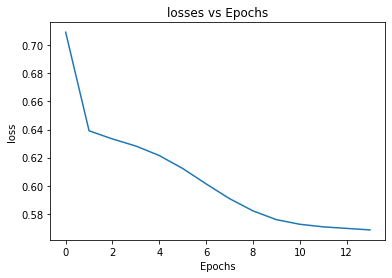

In [276]:
#printing the accuracy
plt.plot(val_losses)
plt.title('losses vs Epochs')
plt.xlabel('Epochs')
plt.ylabel('loss')

Text(0, 0.5, 'loss')

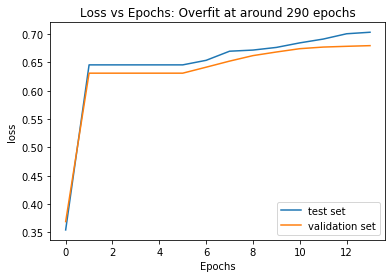

In [277]:
# Plotting Losses
#plotting the loss
plt.plot(test_accur, label = 'test set')
plt.plot(train_accur, label = 'validation set')
plt.title('Loss vs Epochs: Overfit at around 290 epochs')
plt.legend(loc = "lower right")
plt.xlabel('Epochs')
plt.ylabel('loss')

We will set the number of epoch at 600. We also observe at epoch 0, the accuracy score is at 0.6318607764390897, which reflects imbalancy in Data. To solve that, we would implement cost/class weight.

In [32]:
epochs = 290
# Model , Optimizer, Loss
loss_fn = nn.BCELoss()
model = Net(input_shape=X_train.shape[1])
optimizer = torch.optim.SGD(model.parameters(),lr=learning_rate)

val_losses = []
test_accur = []
train_accur = []
for i in range(epochs):
  for j,(X_batch,y_batch) in enumerate(trainloader):
    model.train()
    #calculate output
    output = model(X_batch)
 
    #calculate loss
    loss = loss_fn(output,y_batch.reshape(-1,1))

    #backprop
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

  if i%50 == 0:
    model.eval()
    with torch.no_grad():
        #accuracy train
        predicted_train = model(torch.tensor(X_train,dtype=torch.float32))
        train_acc = (predicted_train.reshape(-1).detach().numpy().round() == y_train).mean()
        
        #accuracy test
        predicted_test = model(torch.tensor(X_test,dtype=torch.float32))
        test_acc = (predicted_test.reshape(-1).detach().numpy().round() == y_test).mean()
        
    val_losses.append(loss)
    train_accur.append(train_acc)
    test_accur.append(test_acc)
    print("epoch {}\tloss : {}\t train accuracy : {} test_acc : {}".format(i,loss,train_acc,test_acc))

epoch 0	loss : 0.7021908760070801	 train accuracy : 0.3691432396251673 test_acc : 0.35451505016722407
epoch 50	loss : 0.6410317420959473	 train accuracy : 0.6308567603748326 test_acc : 0.6454849498327759
epoch 100	loss : 0.6366327404975891	 train accuracy : 0.6308567603748326 test_acc : 0.6454849498327759
epoch 150	loss : 0.6349890828132629	 train accuracy : 0.6308567603748326 test_acc : 0.6454849498327759
epoch 200	loss : 0.6331576108932495	 train accuracy : 0.6308567603748326 test_acc : 0.6454849498327759
epoch 250	loss : 0.6304171085357666	 train accuracy : 0.6308567603748326 test_acc : 0.6454849498327759


In [211]:
Test = torch.tensor(X_test,dtype=torch.float32)
prediction = model(Test)
prediction = (prediction.reshape(-1).detach().numpy().round())
pd.DataFrame(prediction)[0].value_counts()
# confusion_matrix(prediction,y_test)
accuracy_score(prediction,y_test)

0.7210702341137124

In [213]:
Test = sc.fit_transform(Test_data)
Test = torch.tensor(Test,dtype=torch.float32)
prediction = model(Test)
prediction = (prediction.reshape(-1).detach().numpy().round())
# pd.DataFrame(prediction)[0].value_counts()
pd.DataFrame(prediction)[0].value_counts()

1.0    1539
0.0     901
Name: 0, dtype: int64

In [214]:
submission = pd.read_csv("Submission/sample_submission.csv")
submission["Decision"] = prediction
# pd.DataFrame(submission).to_csv("NN_Submission_Take5.csv",index=False) 
# train accuracy : 0.7481593038821954 test_acc : 0.7377926421404682
# pd.DataFrame(submission).to_csv("NN_Submission_Take6.csv",index=False) 
# train accuracy : 0.7165327978580991 test_acc : 0.7250836120401338
# pd.DataFrame(submission).to_csv("NN_Submission_Take7.csv",index=False) 
# test_acc : 0.7210702341137124

## Experiment 2: 2 Layer with Sigmoid Activation

In [33]:
#defining the network
from torch import nn
from torch.nn import functional as F
class Net(nn.Module):
  def __init__(self,input_shape):
    super(Net,self).__init__()
    self.fc1 = nn.Linear(input_shape, 32) 
    self.fc2 = nn.Linear(32, 64)
    self.fc4 = nn.Linear(64, 1)
    
  def forward(self,x):
    x = torch.relu(self.fc1(x))
    x = torch.relu(self.fc2(x))
    x = torch.sigmoid(self.fc4(x))
    return x

In [34]:
# Model , Optimizer, Loss
loss_fn = nn.BCELoss()
model = Net(input_shape=X_train.shape[1])
optimizer = torch.optim.SGD(model.parameters(),lr=learning_rate)
val_losses = []
test_accur = []
train_accur = []
for i in range(300):
  for j,(X_batch,y_batch) in enumerate(trainloader):
    model.train()
    #calculate output
    output = model(X_batch)
 
    #calculate loss
    loss = loss_fn(output,y_batch.reshape(-1,1))

    #backprop
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

  if i%50 == 0:
    model.eval()
    with torch.no_grad():
        #accuracy train
        predicted_train = model(torch.tensor(X_train,dtype=torch.float32))
        train_acc = (predicted_train.reshape(-1).detach().numpy().round() == y_train).mean()
        
        #accuracy test
        predicted_test = model(torch.tensor(X_test,dtype=torch.float32))
        test_acc = (predicted_test.reshape(-1).detach().numpy().round() == y_test).mean()
        
    val_losses.append(loss)
    train_accur.append(train_acc)
    test_accur.append(test_acc)
    print("epoch {}\tloss : {}\t train accuracy : {} test_acc : {}".format(i,loss,train_acc,test_acc))

epoch 0	loss : 0.71026611328125	 train accuracy : 0.41348728246318606 test_acc : 0.3826086956521739
epoch 50	loss : 0.6424987316131592	 train accuracy : 0.6308567603748326 test_acc : 0.6454849498327759
epoch 100	loss : 0.6317336559295654	 train accuracy : 0.6350401606425703 test_acc : 0.6468227424749163
epoch 150	loss : 0.6226192116737366	 train accuracy : 0.6497657295850067 test_acc : 0.6655518394648829
epoch 200	loss : 0.613484799861908	 train accuracy : 0.6593038821954484 test_acc : 0.6789297658862876
epoch 250	loss : 0.6054545044898987	 train accuracy : 0.6693440428380187 test_acc : 0.6755852842809364


In [24]:
Test = torch.tensor(X_test,dtype=torch.float32)
prediction = model(Test)
prediction = (prediction.reshape(-1).detach().numpy().round())
pd.DataFrame(prediction)[0].value_counts()
# confusion_matrix(prediction,y_test)
accuracy_score(prediction,y_test)

0.6762541806020067

## Experiment 3: 5 Layer with Sigmoid Activation

In [29]:
#defining the network
from torch import nn
from torch.nn import functional as F
class Net(nn.Module):
  def __init__(self,input_shape):
    super(Net,self).__init__()
    self.fc1 = nn.Linear(input_shape, 20) 
    self.fc2 = nn.Linear(20, 30)
    self.fc3 = nn.Linear(30, 60)
    self.fc4 = nn.Linear(60, 80)
    self.fc5 = nn.Linear(80, 1)
    
  def forward(self,x):
    x = torch.relu(self.fc1(x))
    x = torch.relu(self.fc2(x))
    x = torch.relu(self.fc3(x))
    x = torch.relu(self.fc4(x))
    x = torch.sigmoid(self.fc5(x))
    return x

In [30]:
# Model , Optimizer, Loss
loss_fn = nn.BCELoss()
model = Net(input_shape=X_train.shape[1])
optimizer = torch.optim.SGD(model.parameters(),lr=learning_rate)
val_losses = []
test_accur = []
train_accur = []
for i in range(700):
  for j,(X_batch,y_batch) in enumerate(trainloader):
    model.train()
    #calculate output
    output = model(X_batch)
 
    #calculate loss
    loss = loss_fn(output,y_batch.reshape(-1,1))

    #backprop
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

  if i%50 == 0:
    model.eval()
    with torch.no_grad():
        #accuracy train
        predicted_train = model(torch.tensor(X_train,dtype=torch.float32))
        train_acc = (predicted_train.reshape(-1).detach().numpy().round() == y_train).mean()
        
        #accuracy test
        predicted_test = model(torch.tensor(X_test,dtype=torch.float32))
        test_acc = (predicted_test.reshape(-1).detach().numpy().round() == y_test).mean()
        
    val_losses.append(loss)
    train_accur.append(train_acc)
    test_accur.append(test_acc)
    print("epoch {}\tloss : {}\t train accuracy : {} test_acc : {}".format(i,loss,train_acc,test_acc))

epoch 0	loss : 0.7089985013008118	 train accuracy : 0.3691432396251673 test_acc : 0.35451505016722407
epoch 50	loss : 0.6440580487251282	 train accuracy : 0.6308567603748326 test_acc : 0.6454849498327759
epoch 100	loss : 0.639809787273407	 train accuracy : 0.6308567603748326 test_acc : 0.6454849498327759
epoch 150	loss : 0.639044463634491	 train accuracy : 0.6308567603748326 test_acc : 0.6454849498327759
epoch 200	loss : 0.6384016871452332	 train accuracy : 0.6308567603748326 test_acc : 0.6454849498327759
epoch 250	loss : 0.6374030709266663	 train accuracy : 0.6308567603748326 test_acc : 0.6454849498327759
epoch 300	loss : 0.63568514585495	 train accuracy : 0.6308567603748326 test_acc : 0.6454849498327759
epoch 350	loss : 0.631870687007904	 train accuracy : 0.6308567603748326 test_acc : 0.6454849498327759
epoch 400	loss : 0.6242138743400574	 train accuracy : 0.6308567603748326 test_acc : 0.6454849498327759
epoch 450	loss : 0.6119470596313477	 train accuracy : 0.6370481927710844 test_ac

Text(0, 0.5, 'loss')

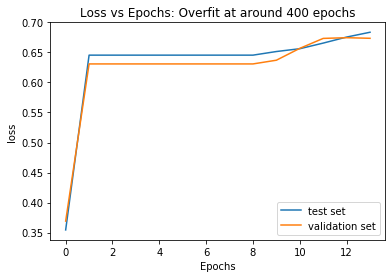

In [31]:
# Plotting Losses
#plotting the loss
plt.plot(test_accur, label = 'test set')
plt.plot(train_accur, label = 'validation set')
plt.title('Loss vs Epochs: Overfit at around 400 epochs')
plt.legend(loc = "lower right")
plt.xlabel('Epochs')
plt.ylabel('loss')

In [246]:
loss_fn = nn.BCELoss()
model = Net(input_shape=X_train.shape[1])
optimizer = torch.optim.SGD(model.parameters(),lr=learning_rate)
val_losses = []
test_accur = []
train_accur = []

for i in range(400):
  for j,(X_batch,y_batch) in enumerate(trainloader):
    model.train()
    #calculate output
    output = model(X_batch)
 
    #calculate loss
    loss = loss_fn(output,y_batch.reshape(-1,1))

    #backprop
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

  if i%50 == 0:
    model.eval()
    with torch.no_grad():
        #accuracy train
        predicted_train = model(torch.tensor(X_train,dtype=torch.float32))
        train_acc = (predicted_train.reshape(-1).detach().numpy().round() == y_train).mean()
        
        #accuracy test
        predicted_test = model(torch.tensor(X_test,dtype=torch.float32))
        test_acc = (predicted_test.reshape(-1).detach().numpy().round() == y_test).mean()
        
    val_losses.append(loss)
    train_accur.append(train_acc)
    test_accur.append(test_acc)
    print("epoch {}\tloss : {}\t train accuracy : {} test_acc : {}".format(i,loss,train_acc,test_acc))

epoch 0	loss : 0.6636579632759094	 train accuracy : 0.6308567603748326 test_acc : 0.6454849498327759
epoch 50	loss : 0.6389551162719727	 train accuracy : 0.6308567603748326 test_acc : 0.6454849498327759
epoch 100	loss : 0.6381142139434814	 train accuracy : 0.6308567603748326 test_acc : 0.6454849498327759
epoch 150	loss : 0.6300195455551147	 train accuracy : 0.6308567603748326 test_acc : 0.6454849498327759
epoch 200	loss : 0.6093049645423889	 train accuracy : 0.6818942436412316 test_acc : 0.6929765886287625
epoch 250	loss : 0.5373973250389099	 train accuracy : 0.6997991967871486 test_acc : 0.7130434782608696
epoch 300	loss : 0.45656856894493103	 train accuracy : 0.7161981258366801 test_acc : 0.7103678929765886
epoch 350	loss : 0.3892599642276764	 train accuracy : 0.7336010709504686 test_acc : 0.7183946488294315


In [249]:
Test = torch.tensor(X_test,dtype=torch.float32)
prediction = model(Test)
prediction = (prediction.reshape(-1).detach().numpy().round())
pd.DataFrame(prediction)[0].value_counts()
confusion_matrix(prediction,y_test)
accuracy_score(prediction,y_test)

0.7297658862876254

In [251]:
Test = sc.fit_transform(Test_data)
Test = torch.tensor(Test,dtype=torch.float32)
prediction = model(Test)
prediction = (prediction.reshape(-1).detach().numpy().round())
# pd.DataFrame(prediction)[0].value_counts()
pd.DataFrame(prediction)[0].value_counts()

1.0    1515
0.0     925
Name: 0, dtype: int64

In [252]:
submission = pd.read_csv("Submission/sample_submission.csv")
submission["Decision"] = prediction
# pd.DataFrame(submission).to_csv("NN_Submission_Take5.csv",index=False) 
# train accuracy : 0.7481593038821954 test_acc : 0.7377926421404682
# pd.DataFrame(submission).to_csv("NN_Submission_Take6.csv",index=False) 
# train accuracy : 0.7165327978580991 test_acc : 0.7250836120401338
# pd.DataFrame(submission).to_csv("NN_Submission_Take7.csv",index=False) 
# test_acc : 0.7210702341137124
# pd.DataFrame(submission).to_csv("NN_Submission_Take8.csv",index=False) 
# test_acc : 0.7297658862876254

## Experiment 3: 6 Layer with Sigmoid Activation

In [253]:
#defining the network
from torch import nn
from torch.nn import functional as F
class Net(nn.Module):
  def __init__(self,input_shape):
    super(Net,self).__init__()
    self.fc1 = nn.Linear(input_shape, 20) 
    self.fc2 = nn.Linear(20, 30)
    self.fc3 = nn.Linear(30, 40)
    self.fc4 = nn.Linear(40, 50)
    self.fc5 = nn.Linear(50, 60)
    self.fc6 = nn.Linear(60, 70)
    self.fc7 = nn.Linear(70, 1)
    
  def forward(self,x):
    x = torch.relu(self.fc1(x))
    x = torch.relu(self.fc2(x))
    x = torch.relu(self.fc3(x))
    x = torch.relu(self.fc4(x))
    x = torch.relu(self.fc5(x))
    x = torch.relu(self.fc6(x))
    x = torch.sigmoid(self.fc7(x))
    return x

In [240]:
# Model , Optimizer, Loss
loss_fn = nn.BCELoss()
model = Net(input_shape=X_train.shape[1])
optimizer = torch.optim.SGD(model.parameters(),lr=learning_rate)
val_losses = []
test_accur = []
train_accur = []
for i in range(700):
  for j,(X_batch,y_batch) in enumerate(trainloader):
    model.train()
    #calculate output
    output = model(X_batch)
 
    #calculate loss
    loss = loss_fn(output,y_batch.reshape(-1,1))

    #backprop
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

  if i%50 == 0:
    model.eval()
    with torch.no_grad():
        #accuracy train
        predicted_train = model(torch.tensor(X_train,dtype=torch.float32))
        train_acc = (predicted_train.reshape(-1).detach().numpy().round() == y_train).mean()
        
        #accuracy test
        predicted_test = model(torch.tensor(X_test,dtype=torch.float32))
        test_acc = (predicted_test.reshape(-1).detach().numpy().round() == y_test).mean()
        
    val_losses.append(loss)
    train_accur.append(train_acc)
    test_accur.append(test_acc)
    print("epoch {}\tloss : {}\t train accuracy : {} test_acc : {}".format(i,loss,train_acc,test_acc))

epoch 0	loss : 0.6602138876914978	 train accuracy : 0.6308567603748326 test_acc : 0.6454849498327759
epoch 50	loss : 0.6388173699378967	 train accuracy : 0.6308567603748326 test_acc : 0.6454849498327759
epoch 100	loss : 0.635347843170166	 train accuracy : 0.6308567603748326 test_acc : 0.6454849498327759
epoch 150	loss : 0.6151068806648254	 train accuracy : 0.6823962516733602 test_acc : 0.6936454849498328
epoch 200	loss : 0.6441277265548706	 train accuracy : 0.7053212851405622 test_acc : 0.7197324414715719
epoch 250	loss : 0.594163179397583	 train accuracy : 0.7235609103078983 test_acc : 0.7297658862876254
epoch 300	loss : 0.4173119366168976	 train accuracy : 0.7424698795180723 test_acc : 0.7444816053511706
epoch 350	loss : 0.3210441768169403	 train accuracy : 0.7630522088353414 test_acc : 0.7511705685618729
epoch 400	loss : 0.24008184671401978	 train accuracy : 0.7794511378848729 test_acc : 0.745819397993311
epoch 450	loss : 0.2183321863412857	 train accuracy : 0.7888219544846051 test_

In [254]:
loss_fn = nn.BCELoss()
model = Net(input_shape=X_train.shape[1])
optimizer = torch.optim.SGD(model.parameters(),lr=learning_rate)
val_losses = []
test_accur = []
train_accur = []

for i in range(350):
  for j,(X_batch,y_batch) in enumerate(trainloader):
    model.train()
    #calculate output
    output = model(X_batch)
 
    #calculate loss
    loss = loss_fn(output,y_batch.reshape(-1,1))

    #backprop
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

  if i%50 == 0:
    model.eval()
    with torch.no_grad():
        #accuracy train
        predicted_train = model(torch.tensor(X_train,dtype=torch.float32))
        train_acc = (predicted_train.reshape(-1).detach().numpy().round() == y_train).mean()
        
        #accuracy test
        predicted_test = model(torch.tensor(X_test,dtype=torch.float32))
        test_acc = (predicted_test.reshape(-1).detach().numpy().round() == y_test).mean()
        
    val_losses.append(loss)
    train_accur.append(train_acc)
    test_accur.append(test_acc)
    print("epoch {}\tloss : {}\t train accuracy : {} test_acc : {}".format(i,loss,train_acc,test_acc))

epoch 0	loss : 0.6754312515258789	 train accuracy : 0.6308567603748326 test_acc : 0.6454849498327759
epoch 50	loss : 0.6390683054924011	 train accuracy : 0.6308567603748326 test_acc : 0.6454849498327759
epoch 100	loss : 0.6386692523956299	 train accuracy : 0.6308567603748326 test_acc : 0.6454849498327759
epoch 150	loss : 0.6370887756347656	 train accuracy : 0.6308567603748326 test_acc : 0.6454849498327759
epoch 200	loss : 0.6017939448356628	 train accuracy : 0.6308567603748326 test_acc : 0.6454849498327759
epoch 250	loss : 0.6202860474586487	 train accuracy : 0.6877510040160643 test_acc : 0.6956521739130435
epoch 300	loss : 0.5154251456260681	 train accuracy : 0.7111780455153949 test_acc : 0.7297658862876254


In [260]:
Test = torch.tensor(X_test,dtype=torch.float32)
prediction = model(Test)
prediction = (prediction.reshape(-1).detach().numpy().round())
pd.DataFrame(prediction)[0].value_counts()
confusion_matrix(prediction,y_test)
# accuracy_score(prediction,y_test)

array([[290, 162],
       [240, 803]])

In [258]:
Test = sc.fit_transform(Test_data)
Test = torch.tensor(Test,dtype=torch.float32)
prediction = model(Test)
prediction = (prediction.reshape(-1).detach().numpy().round())
# pd.DataFrame(prediction)[0].value_counts()
pd.DataFrame(prediction)[0].value_counts()

1.0    1509
0.0     931
Name: 0, dtype: int64

In [259]:
submission = pd.read_csv("Submission/sample_submission.csv")
submission["Decision"] = prediction
# pd.DataFrame(submission).to_csv("NN_Submission_Take5.csv",index=False) 
# train accuracy : 0.7481593038821954 test_acc : 0.7377926421404682
# pd.DataFrame(submission).to_csv("NN_Submission_Take6.csv",index=False) 
# train accuracy : 0.7165327978580991 test_acc : 0.7250836120401338
# pd.DataFrame(submission).to_csv("NN_Submission_Take7.csv",index=False) 
# test_acc : 0.7210702341137124
# pd.DataFrame(submission).to_csv("NN_Submission_Take8.csv",index=False) 
# test_acc : 0.7297658862876254
# pd.DataFrame(submission).to_csv("NN_Submission_Take9.csv",index=False) 
# test_acc : 0.7311036789297659

# Class Weight

Because we observe strong false negative rate in our model, we will optimize the performance through adding weights to the model

In [261]:
from sklearn.utils import class_weight
class_weights = class_weight.compute_class_weight('balanced', np.unique(y_train), y_train)
class_weights

/Users/yuchenlu/opt/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:72: FutureWarning: Pass classes=[0 1], y=[1 0 1 ... 1 1 1] as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  "will result in an error", FutureWarning)


array([1.35448776, 0.79257294])

In [262]:
def weighted_binary_cross_entropy(output, target, weights=None):        
    if weights is not None:
        assert len(weights) == 2
        loss = weights[1] * (target * torch.log(output)) + \
               weights[0] * ((1 - target) * torch.log(1 - output))
    else:
        loss = target * torch.log(output) + (1 - target) * torch.log(1 - output)
    return torch.neg(torch.mean(loss))

In [263]:
# Model , Optimizer, Loss
model = Net(input_shape=X_train.shape[1])
optimizer = torch.optim.SGD(model.parameters(),lr=learning_rate)
# loss_fn = nn.BCELoss(weight=class_weights)

val_losses = []
train_losses = []
test_accur = []
train_accur = []
for i in range(epochs):
  for j,(X_batch,y_batch) in enumerate(trainloader):
    model.train()
    #calculate output
    output = model(X_batch)
 
    #calculate loss
    loss = weighted_binary_cross_entropy(output,y_batch.reshape(-1,1),class_weights)
    
    #backprop
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

  if i%50 == 0:
    model.eval()
    with torch.no_grad():
        #accuracy train
        predicted_train = model(torch.tensor(X_train,dtype=torch.float32))
        train_acc = (predicted_train.reshape(-1).detach().numpy().round() == y_train).mean()
        
        #accuracy test
        predicted_test = model(torch.tensor(X_test,dtype=torch.float32))
        test_acc = (predicted_test.reshape(-1).detach().numpy().round() == y_test).mean()
        
    val_losses.append(loss)
    train_accur.append(train_acc)
    test_accur.append(test_acc)
    print("epoch {}\tloss : {}\t train accuracy : {} test_acc : {}".format(i,loss,train_acc,test_acc))

epoch 0	loss : 0.6764455437660217	 train accuracy : 0.6308567603748326 test_acc : 0.6454849498327759
epoch 50	loss : 0.6788384914398193	 train accuracy : 0.5729585006693441 test_acc : 0.5752508361204013
epoch 100	loss : 0.6784279942512512	 train accuracy : 0.5594042838018741 test_acc : 0.5645484949832776
epoch 150	loss : 0.6748531460762024	 train accuracy : 0.571619812583668 test_acc : 0.5725752508361204
epoch 200	loss : 0.6311191916465759	 train accuracy : 0.6343708165997323 test_acc : 0.6581939799331104
epoch 250	loss : 0.5673548579216003	 train accuracy : 0.6477576974564926 test_acc : 0.6688963210702341


In [67]:
predicted_test = model(torch.tensor(X_test,dtype=torch.float32))
prediction = (predicted_test.reshape(-1).detach().numpy().round())
# pd.DataFrame(prediction)[0].value_counts()
mean_absolute_error(prediction,y_test)

0.2903010033444816

In [69]:
Test = torch.tensor(X_test,dtype=torch.float32)
prediction = model(Test)
prediction = (prediction.reshape(-1).detach().numpy().round())
mean_absolute_error(prediction,y_test)

0.2903010033444816

In [70]:
Test = sc.fit_transform(Test_data)
Test = torch.tensor(Test,dtype=torch.float32)
prediction = model(Test)
prediction = (prediction.reshape(-1).detach().numpy().round())
pd.DataFrame(prediction)[0].value_counts()

0.0    1324
1.0    1116
Name: 0, dtype: int64

In [95]:
submission = pd.read_csv("Submission/sample_submission.csv")
submission["Decision"] = prediction
# pd.DataFrame(submission).to_csv("NN_Submission_Take4.csv",index=False)

# Normalization: Exploring L1 & L2 Regularization

In [118]:
# Model , Optimizer, Loss
model = Net(input_shape=X_train.shape[1])
optimizer = torch.optim.SGD(model.parameters(),lr=learning_rate)
# loss_fn = nn.BCELoss(weight=class_weights)

val_losses = []
train_losses = []
test_accur = []
train_accur = []
for i in range(epochs):
  for j,(X_batch,y_batch) in enumerate(trainloader):
    model.train()
    #calculate output
    output = model(X_batch)
 
    #calculate loss
    loss = weighted_binary_cross_entropy(output,y_batch.reshape(-1,1),class_weights)
    
    #backprop
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

  if i%50 == 0:
    model.eval()
    with torch.no_grad():
        #accuracy train
        predicted_train = model(torch.tensor(X_train,dtype=torch.float32))
        train_acc = (predicted_train.reshape(-1).detach().numpy().round() == y_train).mean()
        
        #accuracy test
        predicted_test = model(torch.tensor(X_test,dtype=torch.float32))
        test_acc = (predicted_test.reshape(-1).detach().numpy().round() == y_test).mean()
        
    val_losses.append(loss)
    train_accur.append(train_acc)
    test_accur.append(test_acc)
    print("epoch {}\tloss : {}\t train accuracy : {} test_acc : {}".format(i,loss,train_acc,test_acc))

epoch 0	loss : 0.6880342960357666	 train accuracy : 0.4062918340026774 test_acc : 0.3979933110367893
epoch 50	loss : 0.6774968504905701	 train accuracy : 0.6445783132530121 test_acc : 0.6742474916387959
epoch 100	loss : 0.655731737613678	 train accuracy : 0.6631526104417671 test_acc : 0.691638795986622
epoch 150	loss : 0.5934212803840637	 train accuracy : 0.6768741633199464 test_acc : 0.6956521739130435
epoch 200	loss : 0.5378075242042542	 train accuracy : 0.6798862115127176 test_acc : 0.6989966555183946
epoch 250	loss : 0.49648454785346985	 train accuracy : 0.6910977242302544 test_acc : 0.7003344481605351


# Base Function

In [271]:
import pandas as pd
import tensorflow
import numpy as np
import matplotlib.pyplot as plt
from keras.models import Sequential
from keras.layers import Dense
from tensorflow.keras import optimizers
np.random.seed(1)

In [400]:
model = Sequential()
hidden_units= 20
learning_rate=0.01
num_epochs= 100
hidden_layer_act_1='tanh'
hidden_layer_act_2='sigmoid'
output_layer_act='sigmoid'
input_dim = X_train.shape[1]
model = Sequential()

In [401]:
model.add(Dense(hidden_units, input_dim=input_dim, activation=hidden_layer_act))
model.add(Dense(hidden_units, activation=hidden_layer_act_1))
model.add(Dense(hidden_units, activation=hidden_layer_act_2))
model.add(Dense(1, activation=output_layer_act))

In [402]:
sgd=optimizers.SGD(learning_rate=learning_rate)
model.compile(loss='binary_crossentropy',optimizer=sgd, metrics=['acc'])

In [403]:
model.fit(X_train, y_train, epochs=num_epochs, batch_size=len(X_train),  verbose=2)

Epoch 1/100
1/1 - 0s - loss: 0.6993 - acc: 0.6339 - 446ms/epoch - 446ms/step
Epoch 2/100
1/1 - 0s - loss: 0.6981 - acc: 0.6339 - 3ms/epoch - 3ms/step
Epoch 3/100
1/1 - 0s - loss: 0.6969 - acc: 0.6339 - 3ms/epoch - 3ms/step
Epoch 4/100
1/1 - 0s - loss: 0.6958 - acc: 0.6339 - 3ms/epoch - 3ms/step
Epoch 5/100
1/1 - 0s - loss: 0.6947 - acc: 0.6339 - 2ms/epoch - 2ms/step
Epoch 6/100
1/1 - 0s - loss: 0.6936 - acc: 0.6339 - 4ms/epoch - 4ms/step
Epoch 7/100
1/1 - 0s - loss: 0.6925 - acc: 0.6339 - 4ms/epoch - 4ms/step
Epoch 8/100
1/1 - 0s - loss: 0.6914 - acc: 0.6339 - 3ms/epoch - 3ms/step
Epoch 9/100
1/1 - 0s - loss: 0.6904 - acc: 0.6339 - 6ms/epoch - 6ms/step
Epoch 10/100
1/1 - 0s - loss: 0.6894 - acc: 0.6339 - 4ms/epoch - 4ms/step
Epoch 11/100
1/1 - 0s - loss: 0.6884 - acc: 0.6339 - 3ms/epoch - 3ms/step
Epoch 12/100
1/1 - 0s - loss: 0.6875 - acc: 0.6339 - 7ms/epoch - 7ms/step
Epoch 13/100
1/1 - 0s - loss: 0.6866 - acc: 0.6339 - 5ms/epoch - 5ms/step
Epoch 14/100
1/1 - 0s - loss: 0.6856 - acc:

In [404]:
predictions = model.predict(X_test)

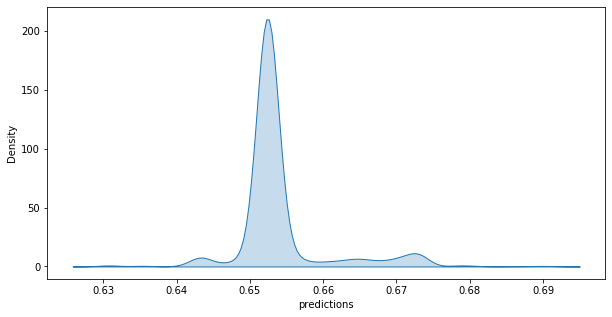

In [405]:
plt.figure(figsize=(10,5))
plt.xlabel('predictions')
plt.ylabel('Density')
sns.kdeplot(pd.DataFrame(predictions)[0],shade=True)
plt.show()

In [406]:
threshold = np.arange(0.0, 1.0, 0.01)
AC = []

def best_threshold(threshold):
    ypred = model.predict(X_test)
    prediction = pd.DataFrame (ypred, columns = ['Decision'])
    prediction  = prediction['Decision'].apply(lambda Decision: 1 if Decision > threshold else 0)
    ac = accuracy_score(y_test, prediction)
    AC.append(ac)

for i in threshold:
    best_threshold(i)

In [407]:
threshold_prediction = pd.DataFrame({'threshold': threshold, 'AC': AC}, 
                                    columns=['threshold', 'AC'])

threshold_prediction[threshold_prediction['AC']==threshold_prediction['AC'].max()]

,threshold,AC
0,0.00,0.633445
1,0.01,0.633445
2,0.02,0.633445
3,0.03,0.633445
4,0.04,0.633445
...,...,...
59,0.59,0.633445
60,0.60,0.633445
61,0.61,0.633445
62,0.62,0.633445


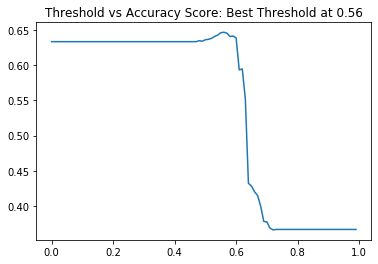

In [281]:
# Plot Best Threshold
sns.lineplot(x = threshold, y = AC, data = threshold_prediction) 
plt.title("Threshold vs Accuracy Score: Best Threshold at 0.56")
plt.show()

In [282]:
def predict(X_test,model):
    ypred = model.predict(X_test)
    prediction = pd.DataFrame (ypred, columns = ['Decision'])
    prediction  = prediction['Decision'].apply(lambda Decision: 1 if Decision > 0.62 else 0)
    return(prediction)

In [283]:
confusion_matrix(predict(X_test,model),y_test)

array([[184, 242],
       [364, 705]])

# Hyper-parameter Tuning

We will tune the following hyper-parameters:
* Number of Hidden Units.
* Learning rate.
* Activation function.
* Number of epochs

## 1. Learning Tuning

In [284]:
# Learning Rate
num_epochs = 60
eta = np.arange(0.0, 1.0, 0.01)
AC = []
for i in eta: 
    model = Sequential()
    model.add(Dense(hidden_units, input_dim=input_dim, activation=hidden_layer_act))
    model.add(Dense(hidden_units, activation=hidden_layer_act))
    model.add(Dense(1, activation=output_layer_act))
    sgd=optimizers.SGD(learning_rate=i)
    model.compile(loss='binary_crossentropy',optimizer=sgd, metrics=['acc'])
    model.fit(X_train, y_train, epochs=num_epochs, batch_size=len(X_train),  verbose=2)
    ypred = model.predict(X_test)
    prediction = pd.DataFrame (ypred, columns = ['Decision'])
    prediction  = prediction['Decision'].apply(lambda Decision: 1 if Decision > 0.58 else 0)
    ac = accuracy_score(y_test, prediction)
    AC.append(ac)

Epoch 1/60
1/1 - 1s - loss: 0.7402 - acc: 0.4970 - 638ms/epoch - 638ms/step
Epoch 2/60
1/1 - 0s - loss: 0.7402 - acc: 0.4970 - 5ms/epoch - 5ms/step
Epoch 3/60
1/1 - 0s - loss: 0.7402 - acc: 0.4970 - 4ms/epoch - 4ms/step
Epoch 4/60
1/1 - 0s - loss: 0.7402 - acc: 0.4970 - 4ms/epoch - 4ms/step
Epoch 5/60
1/1 - 0s - loss: 0.7402 - acc: 0.4970 - 3ms/epoch - 3ms/step
Epoch 6/60
1/1 - 0s - loss: 0.7402 - acc: 0.4970 - 5ms/epoch - 5ms/step
Epoch 7/60
1/1 - 0s - loss: 0.7402 - acc: 0.4970 - 5ms/epoch - 5ms/step
Epoch 8/60
1/1 - 0s - loss: 0.7402 - acc: 0.4970 - 5ms/epoch - 5ms/step
Epoch 9/60
1/1 - 0s - loss: 0.7402 - acc: 0.4970 - 4ms/epoch - 4ms/step
Epoch 10/60
1/1 - 0s - loss: 0.7402 - acc: 0.4970 - 3ms/epoch - 3ms/step
Epoch 11/60
1/1 - 0s - loss: 0.7402 - acc: 0.4970 - 4ms/epoch - 4ms/step
Epoch 12/60
1/1 - 0s - loss: 0.7402 - acc: 0.4970 - 4ms/epoch - 4ms/step
Epoch 13/60
1/1 - 0s - loss: 0.7402 - acc: 0.4970 - 4ms/epoch - 4ms/step
Epoch 14/60
1/1 - 0s - loss: 0.7402 - acc: 0.4970 - 2ms/

Epoch 54/60
1/1 - 0s - loss: 0.6647 - acc: 0.6337 - 2ms/epoch - 2ms/step
Epoch 55/60
1/1 - 0s - loss: 0.6646 - acc: 0.6337 - 2ms/epoch - 2ms/step
Epoch 56/60
1/1 - 0s - loss: 0.6645 - acc: 0.6337 - 4ms/epoch - 4ms/step
Epoch 57/60
1/1 - 0s - loss: 0.6644 - acc: 0.6337 - 2ms/epoch - 2ms/step
Epoch 58/60
1/1 - 0s - loss: 0.6643 - acc: 0.6337 - 3ms/epoch - 3ms/step
Epoch 59/60
1/1 - 0s - loss: 0.6642 - acc: 0.6337 - 2ms/epoch - 2ms/step
Epoch 60/60
1/1 - 0s - loss: 0.6641 - acc: 0.6337 - 3ms/epoch - 3ms/step
Epoch 1/60
1/1 - 0s - loss: 0.9217 - acc: 0.3613 - 393ms/epoch - 393ms/step
Epoch 2/60
1/1 - 0s - loss: 0.7872 - acc: 0.4856 - 2ms/epoch - 2ms/step
Epoch 3/60
1/1 - 0s - loss: 0.7595 - acc: 0.5059 - 2ms/epoch - 2ms/step
Epoch 4/60
1/1 - 0s - loss: 0.7340 - acc: 0.5136 - 2ms/epoch - 2ms/step
Epoch 5/60
1/1 - 0s - loss: 0.7125 - acc: 0.5281 - 3ms/epoch - 3ms/step
Epoch 6/60
1/1 - 0s - loss: 0.7015 - acc: 0.5455 - 2ms/epoch - 2ms/step
Epoch 7/60
1/1 - 0s - loss: 0.6931 - acc: 0.5490 - 3m

Epoch 47/60
1/1 - 0s - loss: 0.6557 - acc: 0.6335 - 2ms/epoch - 2ms/step
Epoch 48/60
1/1 - 0s - loss: 0.6555 - acc: 0.6337 - 2ms/epoch - 2ms/step
Epoch 49/60
1/1 - 0s - loss: 0.6554 - acc: 0.6339 - 2ms/epoch - 2ms/step
Epoch 50/60
1/1 - 0s - loss: 0.6553 - acc: 0.6340 - 2ms/epoch - 2ms/step
Epoch 51/60
1/1 - 0s - loss: 0.6551 - acc: 0.6344 - 2ms/epoch - 2ms/step
Epoch 52/60
1/1 - 0s - loss: 0.6550 - acc: 0.6345 - 2ms/epoch - 2ms/step
Epoch 53/60
1/1 - 0s - loss: 0.6549 - acc: 0.6342 - 2ms/epoch - 2ms/step
Epoch 54/60
1/1 - 0s - loss: 0.6547 - acc: 0.6345 - 2ms/epoch - 2ms/step
Epoch 55/60
1/1 - 0s - loss: 0.6546 - acc: 0.6345 - 2ms/epoch - 2ms/step
Epoch 56/60
1/1 - 0s - loss: 0.6545 - acc: 0.6347 - 2ms/epoch - 2ms/step
Epoch 57/60
1/1 - 0s - loss: 0.6544 - acc: 0.6347 - 2ms/epoch - 2ms/step
Epoch 58/60
1/1 - 0s - loss: 0.6543 - acc: 0.6347 - 2ms/epoch - 2ms/step
Epoch 59/60
1/1 - 0s - loss: 0.6542 - acc: 0.6347 - 2ms/epoch - 2ms/step
Epoch 60/60
1/1 - 0s - loss: 0.6541 - acc: 0.6347 -

Epoch 40/60
1/1 - 0s - loss: 0.6583 - acc: 0.6344 - 2ms/epoch - 2ms/step
Epoch 41/60
1/1 - 0s - loss: 0.6582 - acc: 0.6344 - 2ms/epoch - 2ms/step
Epoch 42/60
1/1 - 0s - loss: 0.6581 - acc: 0.6344 - 2ms/epoch - 2ms/step
Epoch 43/60
1/1 - 0s - loss: 0.6580 - acc: 0.6342 - 2ms/epoch - 2ms/step
Epoch 44/60
1/1 - 0s - loss: 0.6579 - acc: 0.6342 - 2ms/epoch - 2ms/step
Epoch 45/60
1/1 - 0s - loss: 0.6578 - acc: 0.6342 - 2ms/epoch - 2ms/step
Epoch 46/60
1/1 - 0s - loss: 0.6577 - acc: 0.6344 - 2ms/epoch - 2ms/step
Epoch 47/60
1/1 - 0s - loss: 0.6576 - acc: 0.6344 - 2ms/epoch - 2ms/step
Epoch 48/60
1/1 - 0s - loss: 0.6575 - acc: 0.6344 - 2ms/epoch - 2ms/step
Epoch 49/60
1/1 - 0s - loss: 0.6574 - acc: 0.6345 - 2ms/epoch - 2ms/step
Epoch 50/60
1/1 - 0s - loss: 0.6573 - acc: 0.6347 - 2ms/epoch - 2ms/step
Epoch 51/60
1/1 - 0s - loss: 0.6573 - acc: 0.6347 - 2ms/epoch - 2ms/step
Epoch 52/60
1/1 - 0s - loss: 0.6572 - acc: 0.6347 - 2ms/epoch - 2ms/step
Epoch 53/60
1/1 - 0s - loss: 0.6572 - acc: 0.6347 -

Epoch 33/60
1/1 - 0s - loss: 0.6446 - acc: 0.6452 - 3ms/epoch - 3ms/step
Epoch 34/60
1/1 - 0s - loss: 0.6443 - acc: 0.6461 - 2ms/epoch - 2ms/step
Epoch 35/60
1/1 - 0s - loss: 0.6441 - acc: 0.6468 - 2ms/epoch - 2ms/step
Epoch 36/60
1/1 - 0s - loss: 0.6438 - acc: 0.6471 - 3ms/epoch - 3ms/step
Epoch 37/60
1/1 - 0s - loss: 0.6436 - acc: 0.6484 - 2ms/epoch - 2ms/step
Epoch 38/60
1/1 - 0s - loss: 0.6434 - acc: 0.6457 - 2ms/epoch - 2ms/step
Epoch 39/60
1/1 - 0s - loss: 0.6433 - acc: 0.6508 - 3ms/epoch - 3ms/step
Epoch 40/60
1/1 - 0s - loss: 0.6438 - acc: 0.6402 - 2ms/epoch - 2ms/step
Epoch 41/60
1/1 - 0s - loss: 0.6430 - acc: 0.6456 - 2ms/epoch - 2ms/step
Epoch 42/60
1/1 - 0s - loss: 0.6422 - acc: 0.6514 - 2ms/epoch - 2ms/step
Epoch 43/60
1/1 - 0s - loss: 0.6418 - acc: 0.6519 - 2ms/epoch - 2ms/step
Epoch 44/60
1/1 - 0s - loss: 0.6415 - acc: 0.6518 - 2ms/epoch - 2ms/step
Epoch 45/60
1/1 - 0s - loss: 0.6411 - acc: 0.6511 - 2ms/epoch - 2ms/step
Epoch 46/60
1/1 - 0s - loss: 0.6406 - acc: 0.6566 -

Epoch 26/60
1/1 - 0s - loss: 0.6560 - acc: 0.6345 - 2ms/epoch - 2ms/step
Epoch 27/60
1/1 - 0s - loss: 0.6555 - acc: 0.6345 - 3ms/epoch - 3ms/step
Epoch 28/60
1/1 - 0s - loss: 0.6553 - acc: 0.6345 - 3ms/epoch - 3ms/step
Epoch 29/60
1/1 - 0s - loss: 0.6563 - acc: 0.6362 - 3ms/epoch - 3ms/step
Epoch 30/60
1/1 - 0s - loss: 0.6566 - acc: 0.6339 - 2ms/epoch - 2ms/step
Epoch 31/60
1/1 - 0s - loss: 0.6558 - acc: 0.6345 - 2ms/epoch - 2ms/step
Epoch 32/60
1/1 - 0s - loss: 0.6551 - acc: 0.6344 - 2ms/epoch - 2ms/step
Epoch 33/60
1/1 - 0s - loss: 0.6554 - acc: 0.6349 - 2ms/epoch - 2ms/step
Epoch 34/60
1/1 - 0s - loss: 0.6550 - acc: 0.6344 - 2ms/epoch - 2ms/step
Epoch 35/60
1/1 - 0s - loss: 0.6560 - acc: 0.6381 - 2ms/epoch - 2ms/step
Epoch 36/60
1/1 - 0s - loss: 0.6562 - acc: 0.6339 - 2ms/epoch - 2ms/step
Epoch 37/60
1/1 - 0s - loss: 0.6553 - acc: 0.6347 - 2ms/epoch - 2ms/step
Epoch 38/60
1/1 - 0s - loss: 0.6547 - acc: 0.6342 - 2ms/epoch - 2ms/step
Epoch 39/60
1/1 - 0s - loss: 0.6566 - acc: 0.6250 -

Epoch 19/60
1/1 - 0s - loss: 0.6560 - acc: 0.6339 - 2ms/epoch - 2ms/step
Epoch 20/60
1/1 - 0s - loss: 0.6611 - acc: 0.6339 - 2ms/epoch - 2ms/step
Epoch 21/60
1/1 - 0s - loss: 0.6563 - acc: 0.6339 - 2ms/epoch - 2ms/step
Epoch 22/60
1/1 - 0s - loss: 0.6557 - acc: 0.6337 - 3ms/epoch - 3ms/step
Epoch 23/60
1/1 - 0s - loss: 0.6554 - acc: 0.6339 - 2ms/epoch - 2ms/step
Epoch 24/60
1/1 - 0s - loss: 0.6551 - acc: 0.6337 - 2ms/epoch - 2ms/step
Epoch 25/60
1/1 - 0s - loss: 0.6550 - acc: 0.6340 - 2ms/epoch - 2ms/step
Epoch 26/60
1/1 - 0s - loss: 0.6548 - acc: 0.6339 - 2ms/epoch - 2ms/step
Epoch 27/60
1/1 - 0s - loss: 0.6546 - acc: 0.6339 - 2ms/epoch - 2ms/step
Epoch 28/60
1/1 - 0s - loss: 0.6545 - acc: 0.6339 - 2ms/epoch - 2ms/step
Epoch 29/60
1/1 - 0s - loss: 0.6540 - acc: 0.6337 - 2ms/epoch - 2ms/step
Epoch 30/60
1/1 - 0s - loss: 0.6527 - acc: 0.6339 - 2ms/epoch - 2ms/step
Epoch 31/60
1/1 - 0s - loss: 0.6541 - acc: 0.6339 - 2ms/epoch - 2ms/step
Epoch 32/60
1/1 - 0s - loss: 0.6555 - acc: 0.6340 -

Epoch 12/60
1/1 - 0s - loss: 0.6456 - acc: 0.6493 - 2ms/epoch - 2ms/step
Epoch 13/60
1/1 - 0s - loss: 0.6571 - acc: 0.6339 - 3ms/epoch - 3ms/step
Epoch 14/60
1/1 - 0s - loss: 0.6606 - acc: 0.6339 - 2ms/epoch - 2ms/step
Epoch 15/60
1/1 - 0s - loss: 0.6575 - acc: 0.6339 - 3ms/epoch - 3ms/step
Epoch 16/60
1/1 - 0s - loss: 0.6565 - acc: 0.6339 - 2ms/epoch - 2ms/step
Epoch 17/60
1/1 - 0s - loss: 0.6557 - acc: 0.6339 - 3ms/epoch - 3ms/step
Epoch 18/60
1/1 - 0s - loss: 0.6548 - acc: 0.6354 - 3ms/epoch - 3ms/step
Epoch 19/60
1/1 - 0s - loss: 0.6527 - acc: 0.6376 - 3ms/epoch - 3ms/step
Epoch 20/60
1/1 - 0s - loss: 0.6530 - acc: 0.6292 - 2ms/epoch - 2ms/step
Epoch 21/60
1/1 - 0s - loss: 0.6560 - acc: 0.6339 - 3ms/epoch - 3ms/step
Epoch 22/60
1/1 - 0s - loss: 0.6545 - acc: 0.6352 - 3ms/epoch - 3ms/step
Epoch 23/60
1/1 - 0s - loss: 0.6516 - acc: 0.6377 - 3ms/epoch - 3ms/step
Epoch 24/60
1/1 - 0s - loss: 0.6576 - acc: 0.6084 - 2ms/epoch - 2ms/step
Epoch 25/60
1/1 - 0s - loss: 0.6564 - acc: 0.6339 -

Epoch 5/60
1/1 - 0s - loss: 0.6583 - acc: 0.6339 - 3ms/epoch - 3ms/step
Epoch 6/60
1/1 - 0s - loss: 0.6574 - acc: 0.6339 - 2ms/epoch - 2ms/step
Epoch 7/60
1/1 - 0s - loss: 0.6568 - acc: 0.6339 - 2ms/epoch - 2ms/step
Epoch 8/60
1/1 - 0s - loss: 0.6563 - acc: 0.6339 - 3ms/epoch - 3ms/step
Epoch 9/60
1/1 - 0s - loss: 0.6560 - acc: 0.6339 - 2ms/epoch - 2ms/step
Epoch 10/60
1/1 - 0s - loss: 0.6557 - acc: 0.6339 - 2ms/epoch - 2ms/step
Epoch 11/60
1/1 - 0s - loss: 0.6555 - acc: 0.6339 - 2ms/epoch - 2ms/step
Epoch 12/60
1/1 - 0s - loss: 0.6554 - acc: 0.6339 - 3ms/epoch - 3ms/step
Epoch 13/60
1/1 - 0s - loss: 0.6553 - acc: 0.6339 - 2ms/epoch - 2ms/step
Epoch 14/60
1/1 - 0s - loss: 0.6552 - acc: 0.6330 - 2ms/epoch - 2ms/step
Epoch 15/60
1/1 - 0s - loss: 0.6552 - acc: 0.6327 - 3ms/epoch - 3ms/step
Epoch 16/60
1/1 - 0s - loss: 0.6551 - acc: 0.6327 - 3ms/epoch - 3ms/step
Epoch 17/60
1/1 - 0s - loss: 0.6551 - acc: 0.6327 - 2ms/epoch - 2ms/step
Epoch 18/60
1/1 - 0s - loss: 0.6550 - acc: 0.6329 - 2ms/

Epoch 58/60
1/1 - 0s - loss: 0.6564 - acc: 0.6329 - 2ms/epoch - 2ms/step
Epoch 59/60
1/1 - 0s - loss: 0.6564 - acc: 0.6329 - 2ms/epoch - 2ms/step
Epoch 60/60
1/1 - 0s - loss: 0.6563 - acc: 0.6329 - 2ms/epoch - 2ms/step
Epoch 1/60
1/1 - 0s - loss: 0.7058 - acc: 0.5862 - 259ms/epoch - 259ms/step
Epoch 2/60
1/1 - 0s - loss: 0.6787 - acc: 0.6198 - 2ms/epoch - 2ms/step
Epoch 3/60
1/1 - 0s - loss: 0.6671 - acc: 0.6312 - 3ms/epoch - 3ms/step
Epoch 4/60
1/1 - 0s - loss: 0.6628 - acc: 0.6339 - 3ms/epoch - 3ms/step
Epoch 5/60
1/1 - 0s - loss: 0.6613 - acc: 0.6339 - 3ms/epoch - 3ms/step
Epoch 6/60
1/1 - 0s - loss: 0.6602 - acc: 0.6339 - 3ms/epoch - 3ms/step
Epoch 7/60
1/1 - 0s - loss: 0.6599 - acc: 0.6339 - 4ms/epoch - 4ms/step
Epoch 8/60
1/1 - 0s - loss: 0.6590 - acc: 0.6339 - 4ms/epoch - 4ms/step
Epoch 9/60
1/1 - 0s - loss: 0.6582 - acc: 0.6339 - 4ms/epoch - 4ms/step
Epoch 10/60
1/1 - 0s - loss: 0.6587 - acc: 0.6317 - 5ms/epoch - 5ms/step
Epoch 11/60
1/1 - 0s - loss: 0.6580 - acc: 0.6339 - 4ms/

Epoch 51/60
1/1 - 0s - loss: 0.6546 - acc: 0.6335 - 2ms/epoch - 2ms/step
Epoch 52/60
1/1 - 0s - loss: 0.6546 - acc: 0.6332 - 2ms/epoch - 2ms/step
Epoch 53/60
1/1 - 0s - loss: 0.6545 - acc: 0.6335 - 2ms/epoch - 2ms/step
Epoch 54/60
1/1 - 0s - loss: 0.6545 - acc: 0.6334 - 2ms/epoch - 2ms/step
Epoch 55/60
1/1 - 0s - loss: 0.6545 - acc: 0.6337 - 2ms/epoch - 2ms/step
Epoch 56/60
1/1 - 0s - loss: 0.6545 - acc: 0.6334 - 2ms/epoch - 2ms/step
Epoch 57/60
1/1 - 0s - loss: 0.6544 - acc: 0.6337 - 2ms/epoch - 2ms/step
Epoch 58/60
1/1 - 0s - loss: 0.6544 - acc: 0.6334 - 2ms/epoch - 2ms/step
Epoch 59/60
1/1 - 0s - loss: 0.6544 - acc: 0.6337 - 2ms/epoch - 2ms/step
Epoch 60/60
1/1 - 0s - loss: 0.6544 - acc: 0.6334 - 2ms/epoch - 2ms/step
Epoch 1/60
1/1 - 0s - loss: 0.8587 - acc: 0.3661 - 243ms/epoch - 243ms/step
Epoch 2/60
1/1 - 0s - loss: 0.6840 - acc: 0.6339 - 2ms/epoch - 2ms/step
Epoch 3/60
1/1 - 0s - loss: 0.6602 - acc: 0.6339 - 5ms/epoch - 5ms/step
Epoch 4/60
1/1 - 0s - loss: 0.6586 - acc: 0.6339 -

Epoch 44/60
1/1 - 0s - loss: 0.6556 - acc: 0.6339 - 2ms/epoch - 2ms/step
Epoch 45/60
1/1 - 0s - loss: 0.6555 - acc: 0.6334 - 2ms/epoch - 2ms/step
Epoch 46/60
1/1 - 0s - loss: 0.6558 - acc: 0.6339 - 2ms/epoch - 2ms/step
Epoch 47/60
1/1 - 0s - loss: 0.6557 - acc: 0.6314 - 2ms/epoch - 2ms/step
Epoch 48/60
1/1 - 0s - loss: 0.6556 - acc: 0.6339 - 3ms/epoch - 3ms/step
Epoch 49/60
1/1 - 0s - loss: 0.6555 - acc: 0.6327 - 2ms/epoch - 2ms/step
Epoch 50/60
1/1 - 0s - loss: 0.6558 - acc: 0.6339 - 2ms/epoch - 2ms/step
Epoch 51/60
1/1 - 0s - loss: 0.6557 - acc: 0.6315 - 2ms/epoch - 2ms/step
Epoch 52/60
1/1 - 0s - loss: 0.6555 - acc: 0.6339 - 2ms/epoch - 2ms/step
Epoch 53/60
1/1 - 0s - loss: 0.6554 - acc: 0.6332 - 2ms/epoch - 2ms/step
Epoch 54/60
1/1 - 0s - loss: 0.6557 - acc: 0.6339 - 2ms/epoch - 2ms/step
Epoch 55/60
1/1 - 0s - loss: 0.6555 - acc: 0.6315 - 2ms/epoch - 2ms/step
Epoch 56/60
1/1 - 0s - loss: 0.6555 - acc: 0.6339 - 2ms/epoch - 2ms/step
Epoch 57/60
1/1 - 0s - loss: 0.6553 - acc: 0.6335 -

Epoch 37/60
1/1 - 0s - loss: 0.6546 - acc: 0.6339 - 2ms/epoch - 2ms/step
Epoch 38/60
1/1 - 0s - loss: 0.6565 - acc: 0.6339 - 2ms/epoch - 2ms/step
Epoch 39/60
1/1 - 0s - loss: 0.6551 - acc: 0.6339 - 2ms/epoch - 2ms/step
Epoch 40/60
1/1 - 0s - loss: 0.6548 - acc: 0.6339 - 2ms/epoch - 2ms/step
Epoch 41/60
1/1 - 0s - loss: 0.6547 - acc: 0.6339 - 2ms/epoch - 2ms/step
Epoch 42/60
1/1 - 0s - loss: 0.6546 - acc: 0.6339 - 2ms/epoch - 2ms/step
Epoch 43/60
1/1 - 0s - loss: 0.6545 - acc: 0.6339 - 2ms/epoch - 2ms/step
Epoch 44/60
1/1 - 0s - loss: 0.6543 - acc: 0.6339 - 2ms/epoch - 2ms/step
Epoch 45/60
1/1 - 0s - loss: 0.6546 - acc: 0.6339 - 2ms/epoch - 2ms/step
Epoch 46/60
1/1 - 0s - loss: 0.6541 - acc: 0.6339 - 3ms/epoch - 3ms/step
Epoch 47/60
1/1 - 0s - loss: 0.6539 - acc: 0.6339 - 2ms/epoch - 2ms/step
Epoch 48/60
1/1 - 0s - loss: 0.6533 - acc: 0.6339 - 2ms/epoch - 2ms/step
Epoch 49/60
1/1 - 0s - loss: 0.6528 - acc: 0.6339 - 2ms/epoch - 2ms/step
Epoch 50/60
1/1 - 0s - loss: 0.6516 - acc: 0.6339 -

Epoch 30/60
1/1 - 0s - loss: 0.6549 - acc: 0.6339 - 3ms/epoch - 3ms/step
Epoch 31/60
1/1 - 0s - loss: 0.6549 - acc: 0.6339 - 2ms/epoch - 2ms/step
Epoch 32/60
1/1 - 0s - loss: 0.6549 - acc: 0.6339 - 3ms/epoch - 3ms/step
Epoch 33/60
1/1 - 0s - loss: 0.6549 - acc: 0.6339 - 2ms/epoch - 2ms/step
Epoch 34/60
1/1 - 0s - loss: 0.6548 - acc: 0.6339 - 2ms/epoch - 2ms/step
Epoch 35/60
1/1 - 0s - loss: 0.6548 - acc: 0.6339 - 2ms/epoch - 2ms/step
Epoch 36/60
1/1 - 0s - loss: 0.6548 - acc: 0.6339 - 2ms/epoch - 2ms/step
Epoch 37/60
1/1 - 0s - loss: 0.6547 - acc: 0.6339 - 2ms/epoch - 2ms/step
Epoch 38/60
1/1 - 0s - loss: 0.6547 - acc: 0.6339 - 2ms/epoch - 2ms/step
Epoch 39/60
1/1 - 0s - loss: 0.6547 - acc: 0.6339 - 2ms/epoch - 2ms/step
Epoch 40/60
1/1 - 0s - loss: 0.6546 - acc: 0.6339 - 2ms/epoch - 2ms/step
Epoch 41/60
1/1 - 0s - loss: 0.6546 - acc: 0.6339 - 2ms/epoch - 2ms/step
Epoch 42/60
1/1 - 0s - loss: 0.6546 - acc: 0.6339 - 2ms/epoch - 2ms/step
Epoch 43/60
1/1 - 0s - loss: 0.6545 - acc: 0.6339 -

Epoch 23/60
1/1 - 0s - loss: 0.6580 - acc: 0.6339 - 2ms/epoch - 2ms/step
Epoch 24/60
1/1 - 0s - loss: 0.6527 - acc: 0.6362 - 2ms/epoch - 2ms/step
Epoch 25/60
1/1 - 0s - loss: 0.6507 - acc: 0.6352 - 2ms/epoch - 2ms/step
Epoch 26/60
1/1 - 0s - loss: 0.6491 - acc: 0.6422 - 2ms/epoch - 2ms/step
Epoch 27/60
1/1 - 0s - loss: 0.6533 - acc: 0.6352 - 2ms/epoch - 2ms/step
Epoch 28/60
1/1 - 0s - loss: 0.6620 - acc: 0.6451 - 2ms/epoch - 2ms/step
Epoch 29/60
1/1 - 0s - loss: 0.6655 - acc: 0.6339 - 2ms/epoch - 2ms/step
Epoch 30/60
1/1 - 0s - loss: 0.6621 - acc: 0.6436 - 2ms/epoch - 2ms/step
Epoch 31/60
1/1 - 0s - loss: 0.6601 - acc: 0.6339 - 3ms/epoch - 3ms/step
Epoch 32/60
1/1 - 0s - loss: 0.6597 - acc: 0.6397 - 2ms/epoch - 2ms/step
Epoch 33/60
1/1 - 0s - loss: 0.6593 - acc: 0.6339 - 2ms/epoch - 2ms/step
Epoch 34/60
1/1 - 0s - loss: 0.6520 - acc: 0.6489 - 2ms/epoch - 2ms/step
Epoch 35/60
1/1 - 0s - loss: 0.6482 - acc: 0.6397 - 4ms/epoch - 4ms/step
Epoch 36/60
1/1 - 0s - loss: 0.6541 - acc: 0.6180 -

Epoch 16/60
1/1 - 0s - loss: 0.6538 - acc: 0.6339 - 3ms/epoch - 3ms/step
Epoch 17/60
1/1 - 0s - loss: 0.6535 - acc: 0.6339 - 3ms/epoch - 3ms/step
Epoch 18/60
1/1 - 0s - loss: 0.6525 - acc: 0.6339 - 3ms/epoch - 3ms/step
Epoch 19/60
1/1 - 0s - loss: 0.6533 - acc: 0.6339 - 2ms/epoch - 2ms/step
Epoch 20/60
1/1 - 0s - loss: 0.6562 - acc: 0.6339 - 2ms/epoch - 2ms/step
Epoch 21/60
1/1 - 0s - loss: 0.6551 - acc: 0.6339 - 2ms/epoch - 2ms/step
Epoch 22/60
1/1 - 0s - loss: 0.6537 - acc: 0.6339 - 3ms/epoch - 3ms/step
Epoch 23/60
1/1 - 0s - loss: 0.6533 - acc: 0.6339 - 2ms/epoch - 2ms/step
Epoch 24/60
1/1 - 0s - loss: 0.6513 - acc: 0.6339 - 2ms/epoch - 2ms/step
Epoch 25/60
1/1 - 0s - loss: 0.6560 - acc: 0.6339 - 2ms/epoch - 2ms/step
Epoch 26/60
1/1 - 0s - loss: 0.6543 - acc: 0.6339 - 3ms/epoch - 3ms/step
Epoch 27/60
1/1 - 0s - loss: 0.6538 - acc: 0.6339 - 2ms/epoch - 2ms/step
Epoch 28/60
1/1 - 0s - loss: 0.6562 - acc: 0.6339 - 2ms/epoch - 2ms/step
Epoch 29/60
1/1 - 0s - loss: 0.6543 - acc: 0.6339 -

Epoch 9/60
1/1 - 0s - loss: 0.6533 - acc: 0.6339 - 2ms/epoch - 2ms/step
Epoch 10/60
1/1 - 0s - loss: 0.6524 - acc: 0.6339 - 2ms/epoch - 2ms/step
Epoch 11/60
1/1 - 0s - loss: 0.6527 - acc: 0.6339 - 2ms/epoch - 2ms/step
Epoch 12/60
1/1 - 0s - loss: 0.6546 - acc: 0.6339 - 2ms/epoch - 2ms/step
Epoch 13/60
1/1 - 0s - loss: 0.6517 - acc: 0.6339 - 3ms/epoch - 3ms/step
Epoch 14/60
1/1 - 0s - loss: 0.6536 - acc: 0.6339 - 2ms/epoch - 2ms/step
Epoch 15/60
1/1 - 0s - loss: 0.6533 - acc: 0.6339 - 2ms/epoch - 2ms/step
Epoch 16/60
1/1 - 0s - loss: 0.6535 - acc: 0.6342 - 2ms/epoch - 2ms/step
Epoch 17/60
1/1 - 0s - loss: 0.6574 - acc: 0.6339 - 3ms/epoch - 3ms/step
Epoch 18/60
1/1 - 0s - loss: 0.6630 - acc: 0.6339 - 3ms/epoch - 3ms/step
Epoch 19/60
1/1 - 0s - loss: 0.6543 - acc: 0.6339 - 2ms/epoch - 2ms/step
Epoch 20/60
1/1 - 0s - loss: 0.6553 - acc: 0.6340 - 2ms/epoch - 2ms/step
Epoch 21/60
1/1 - 0s - loss: 0.6542 - acc: 0.6339 - 2ms/epoch - 2ms/step
Epoch 22/60
1/1 - 0s - loss: 0.6533 - acc: 0.6339 - 

Epoch 2/60
1/1 - 0s - loss: 0.6552 - acc: 0.6335 - 2ms/epoch - 2ms/step
Epoch 3/60
1/1 - 0s - loss: 0.6533 - acc: 0.6334 - 2ms/epoch - 2ms/step
Epoch 4/60
1/1 - 0s - loss: 0.6535 - acc: 0.6337 - 2ms/epoch - 2ms/step
Epoch 5/60
1/1 - 0s - loss: 0.6586 - acc: 0.6334 - 2ms/epoch - 2ms/step
Epoch 6/60
1/1 - 0s - loss: 0.6589 - acc: 0.6335 - 2ms/epoch - 2ms/step
Epoch 7/60
1/1 - 0s - loss: 0.6572 - acc: 0.6350 - 3ms/epoch - 3ms/step
Epoch 8/60
1/1 - 0s - loss: 0.6616 - acc: 0.6339 - 3ms/epoch - 3ms/step
Epoch 9/60
1/1 - 0s - loss: 0.6551 - acc: 0.6339 - 3ms/epoch - 3ms/step
Epoch 10/60
1/1 - 0s - loss: 0.6512 - acc: 0.6335 - 2ms/epoch - 2ms/step
Epoch 11/60
1/1 - 0s - loss: 0.6503 - acc: 0.6332 - 3ms/epoch - 3ms/step
Epoch 12/60
1/1 - 0s - loss: 0.6551 - acc: 0.6332 - 2ms/epoch - 2ms/step
Epoch 13/60
1/1 - 0s - loss: 0.6513 - acc: 0.6334 - 2ms/epoch - 2ms/step
Epoch 14/60
1/1 - 0s - loss: 0.6505 - acc: 0.6330 - 2ms/epoch - 2ms/step
Epoch 15/60
1/1 - 0s - loss: 0.6521 - acc: 0.6334 - 2ms/epo

Epoch 55/60
1/1 - 0s - loss: 0.6538 - acc: 0.6339 - 2ms/epoch - 2ms/step
Epoch 56/60
1/1 - 0s - loss: 0.6537 - acc: 0.6339 - 3ms/epoch - 3ms/step
Epoch 57/60
1/1 - 0s - loss: 0.6537 - acc: 0.6339 - 2ms/epoch - 2ms/step
Epoch 58/60
1/1 - 0s - loss: 0.6534 - acc: 0.6339 - 2ms/epoch - 2ms/step
Epoch 59/60
1/1 - 0s - loss: 0.6534 - acc: 0.6339 - 2ms/epoch - 2ms/step
Epoch 60/60
1/1 - 0s - loss: 0.6533 - acc: 0.6339 - 3ms/epoch - 3ms/step
Epoch 1/60
1/1 - 0s - loss: 0.9991 - acc: 0.3661 - 250ms/epoch - 250ms/step
Epoch 2/60
1/1 - 0s - loss: 0.7055 - acc: 0.6255 - 2ms/epoch - 2ms/step
Epoch 3/60
1/1 - 0s - loss: 0.6621 - acc: 0.6272 - 2ms/epoch - 2ms/step
Epoch 4/60
1/1 - 0s - loss: 0.6585 - acc: 0.6342 - 2ms/epoch - 2ms/step
Epoch 5/60
1/1 - 0s - loss: 0.6574 - acc: 0.6340 - 2ms/epoch - 2ms/step
Epoch 6/60
1/1 - 0s - loss: 0.6569 - acc: 0.6339 - 2ms/epoch - 2ms/step
Epoch 7/60
1/1 - 0s - loss: 0.6563 - acc: 0.6340 - 2ms/epoch - 2ms/step
Epoch 8/60
1/1 - 0s - loss: 0.6553 - acc: 0.6345 - 2ms

Epoch 48/60
1/1 - 0s - loss: 0.6534 - acc: 0.6339 - 2ms/epoch - 2ms/step
Epoch 49/60
1/1 - 0s - loss: 0.6564 - acc: 0.6339 - 2ms/epoch - 2ms/step
Epoch 50/60
1/1 - 0s - loss: 0.6533 - acc: 0.6339 - 2ms/epoch - 2ms/step
Epoch 51/60
1/1 - 0s - loss: 0.6506 - acc: 0.6339 - 2ms/epoch - 2ms/step
Epoch 52/60
1/1 - 0s - loss: 0.6563 - acc: 0.6339 - 2ms/epoch - 2ms/step
Epoch 53/60
1/1 - 0s - loss: 0.6555 - acc: 0.6339 - 2ms/epoch - 2ms/step
Epoch 54/60
1/1 - 0s - loss: 0.6553 - acc: 0.6339 - 2ms/epoch - 2ms/step
Epoch 55/60
1/1 - 0s - loss: 0.6553 - acc: 0.6339 - 2ms/epoch - 2ms/step
Epoch 56/60
1/1 - 0s - loss: 0.6551 - acc: 0.6339 - 2ms/epoch - 2ms/step
Epoch 57/60
1/1 - 0s - loss: 0.6550 - acc: 0.6339 - 2ms/epoch - 2ms/step
Epoch 58/60
1/1 - 0s - loss: 0.6547 - acc: 0.6339 - 3ms/epoch - 3ms/step
Epoch 59/60
1/1 - 0s - loss: 0.6550 - acc: 0.6339 - 2ms/epoch - 2ms/step
Epoch 60/60
1/1 - 0s - loss: 0.6543 - acc: 0.6339 - 2ms/epoch - 2ms/step
Epoch 1/60
1/1 - 0s - loss: 0.6681 - acc: 0.6324 - 

Epoch 41/60
1/1 - 0s - loss: 0.6537 - acc: 0.6339 - 2ms/epoch - 2ms/step
Epoch 42/60
1/1 - 0s - loss: 0.6535 - acc: 0.6339 - 2ms/epoch - 2ms/step
Epoch 43/60
1/1 - 0s - loss: 0.6535 - acc: 0.6339 - 2ms/epoch - 2ms/step
Epoch 44/60
1/1 - 0s - loss: 0.6534 - acc: 0.6339 - 3ms/epoch - 3ms/step
Epoch 45/60
1/1 - 0s - loss: 0.6534 - acc: 0.6339 - 2ms/epoch - 2ms/step
Epoch 46/60
1/1 - 0s - loss: 0.6533 - acc: 0.6339 - 3ms/epoch - 3ms/step
Epoch 47/60
1/1 - 0s - loss: 0.6532 - acc: 0.6339 - 2ms/epoch - 2ms/step
Epoch 48/60
1/1 - 0s - loss: 0.6533 - acc: 0.6339 - 3ms/epoch - 3ms/step
Epoch 49/60
1/1 - 0s - loss: 0.6532 - acc: 0.6339 - 2ms/epoch - 2ms/step
Epoch 50/60
1/1 - 0s - loss: 0.6531 - acc: 0.6339 - 2ms/epoch - 2ms/step
Epoch 51/60
1/1 - 0s - loss: 0.6531 - acc: 0.6339 - 2ms/epoch - 2ms/step
Epoch 52/60
1/1 - 0s - loss: 0.6532 - acc: 0.6339 - 3ms/epoch - 3ms/step
Epoch 53/60
1/1 - 0s - loss: 0.6530 - acc: 0.6339 - 2ms/epoch - 2ms/step
Epoch 54/60
1/1 - 0s - loss: 0.6530 - acc: 0.6339 -

Epoch 34/60
1/1 - 0s - loss: 0.6544 - acc: 0.6339 - 3ms/epoch - 3ms/step
Epoch 35/60
1/1 - 0s - loss: 0.6541 - acc: 0.6339 - 2ms/epoch - 2ms/step
Epoch 36/60
1/1 - 0s - loss: 0.6543 - acc: 0.6339 - 3ms/epoch - 3ms/step
Epoch 37/60
1/1 - 0s - loss: 0.6540 - acc: 0.6339 - 2ms/epoch - 2ms/step
Epoch 38/60
1/1 - 0s - loss: 0.6542 - acc: 0.6339 - 2ms/epoch - 2ms/step
Epoch 39/60
1/1 - 0s - loss: 0.6540 - acc: 0.6339 - 3ms/epoch - 3ms/step
Epoch 40/60
1/1 - 0s - loss: 0.6541 - acc: 0.6339 - 2ms/epoch - 2ms/step
Epoch 41/60
1/1 - 0s - loss: 0.6539 - acc: 0.6339 - 2ms/epoch - 2ms/step
Epoch 42/60
1/1 - 0s - loss: 0.6540 - acc: 0.6339 - 2ms/epoch - 2ms/step
Epoch 43/60
1/1 - 0s - loss: 0.6538 - acc: 0.6339 - 2ms/epoch - 2ms/step
Epoch 44/60
1/1 - 0s - loss: 0.6539 - acc: 0.6339 - 2ms/epoch - 2ms/step
Epoch 45/60
1/1 - 0s - loss: 0.6537 - acc: 0.6339 - 2ms/epoch - 2ms/step
Epoch 46/60
1/1 - 0s - loss: 0.6538 - acc: 0.6339 - 2ms/epoch - 2ms/step
Epoch 47/60
1/1 - 0s - loss: 0.6537 - acc: 0.6339 -

Epoch 27/60
1/1 - 0s - loss: 0.6591 - acc: 0.6377 - 2ms/epoch - 2ms/step
Epoch 28/60
1/1 - 0s - loss: 0.6557 - acc: 0.6339 - 2ms/epoch - 2ms/step
Epoch 29/60
1/1 - 0s - loss: 0.6509 - acc: 0.6339 - 3ms/epoch - 3ms/step
Epoch 30/60
1/1 - 0s - loss: 0.6500 - acc: 0.6339 - 2ms/epoch - 2ms/step
Epoch 31/60
1/1 - 0s - loss: 0.6488 - acc: 0.6339 - 2ms/epoch - 2ms/step
Epoch 32/60
1/1 - 0s - loss: 0.6483 - acc: 0.6339 - 2ms/epoch - 2ms/step
Epoch 33/60
1/1 - 0s - loss: 0.6665 - acc: 0.5986 - 2ms/epoch - 2ms/step
Epoch 34/60
1/1 - 0s - loss: 0.6662 - acc: 0.6339 - 2ms/epoch - 2ms/step
Epoch 35/60
1/1 - 0s - loss: 0.6578 - acc: 0.6340 - 2ms/epoch - 2ms/step
Epoch 36/60
1/1 - 0s - loss: 0.6548 - acc: 0.6339 - 2ms/epoch - 2ms/step
Epoch 37/60
1/1 - 0s - loss: 0.6531 - acc: 0.6339 - 2ms/epoch - 2ms/step
Epoch 38/60
1/1 - 0s - loss: 0.6522 - acc: 0.6339 - 2ms/epoch - 2ms/step
Epoch 39/60
1/1 - 0s - loss: 0.6507 - acc: 0.6339 - 2ms/epoch - 2ms/step
Epoch 40/60
1/1 - 0s - loss: 0.6547 - acc: 0.6339 -

Epoch 20/60
1/1 - 0s - loss: 0.6553 - acc: 0.6339 - 2ms/epoch - 2ms/step
Epoch 21/60
1/1 - 0s - loss: 0.6554 - acc: 0.6339 - 2ms/epoch - 2ms/step
Epoch 22/60
1/1 - 0s - loss: 0.6551 - acc: 0.6339 - 2ms/epoch - 2ms/step
Epoch 23/60
1/1 - 0s - loss: 0.6551 - acc: 0.6339 - 2ms/epoch - 2ms/step
Epoch 24/60
1/1 - 0s - loss: 0.6551 - acc: 0.6339 - 2ms/epoch - 2ms/step
Epoch 25/60
1/1 - 0s - loss: 0.6554 - acc: 0.6339 - 2ms/epoch - 2ms/step
Epoch 26/60
1/1 - 0s - loss: 0.6551 - acc: 0.6339 - 2ms/epoch - 2ms/step
Epoch 27/60
1/1 - 0s - loss: 0.6550 - acc: 0.6339 - 3ms/epoch - 3ms/step
Epoch 28/60
1/1 - 0s - loss: 0.6553 - acc: 0.6339 - 2ms/epoch - 2ms/step
Epoch 29/60
1/1 - 0s - loss: 0.6549 - acc: 0.6339 - 2ms/epoch - 2ms/step
Epoch 30/60
1/1 - 0s - loss: 0.6550 - acc: 0.6339 - 2ms/epoch - 2ms/step
Epoch 31/60
1/1 - 0s - loss: 0.6554 - acc: 0.6339 - 2ms/epoch - 2ms/step
Epoch 32/60
1/1 - 0s - loss: 0.6552 - acc: 0.6339 - 3ms/epoch - 3ms/step
Epoch 33/60
1/1 - 0s - loss: 0.6549 - acc: 0.6339 -

Epoch 13/60
1/1 - 0s - loss: 0.6607 - acc: 0.6330 - 2ms/epoch - 2ms/step
Epoch 14/60
1/1 - 0s - loss: 0.6592 - acc: 0.6339 - 2ms/epoch - 2ms/step
Epoch 15/60
1/1 - 0s - loss: 0.6633 - acc: 0.6339 - 2ms/epoch - 2ms/step
Epoch 16/60
1/1 - 0s - loss: 0.6611 - acc: 0.6339 - 3ms/epoch - 3ms/step
Epoch 17/60
1/1 - 0s - loss: 0.6570 - acc: 0.6344 - 2ms/epoch - 2ms/step
Epoch 18/60
1/1 - 0s - loss: 0.6556 - acc: 0.6339 - 2ms/epoch - 2ms/step
Epoch 19/60
1/1 - 0s - loss: 0.6539 - acc: 0.6339 - 2ms/epoch - 2ms/step
Epoch 20/60
1/1 - 0s - loss: 0.6532 - acc: 0.6339 - 3ms/epoch - 3ms/step
Epoch 21/60
1/1 - 0s - loss: 0.6524 - acc: 0.6339 - 2ms/epoch - 2ms/step
Epoch 22/60
1/1 - 0s - loss: 0.6516 - acc: 0.6339 - 2ms/epoch - 2ms/step
Epoch 23/60
1/1 - 0s - loss: 0.6508 - acc: 0.6349 - 2ms/epoch - 2ms/step
Epoch 24/60
1/1 - 0s - loss: 0.6624 - acc: 0.6339 - 2ms/epoch - 2ms/step
Epoch 25/60
1/1 - 0s - loss: 0.6818 - acc: 0.5663 - 2ms/epoch - 2ms/step
Epoch 26/60
1/1 - 0s - loss: 0.7032 - acc: 0.6339 -

Epoch 6/60
1/1 - 0s - loss: 0.6579 - acc: 0.6339 - 2ms/epoch - 2ms/step
Epoch 7/60
1/1 - 0s - loss: 0.6570 - acc: 0.6339 - 2ms/epoch - 2ms/step
Epoch 8/60
1/1 - 0s - loss: 0.6567 - acc: 0.6339 - 2ms/epoch - 2ms/step
Epoch 9/60
1/1 - 0s - loss: 0.6566 - acc: 0.6339 - 2ms/epoch - 2ms/step
Epoch 10/60
1/1 - 0s - loss: 0.6565 - acc: 0.6339 - 2ms/epoch - 2ms/step
Epoch 11/60
1/1 - 0s - loss: 0.6564 - acc: 0.6339 - 2ms/epoch - 2ms/step
Epoch 12/60
1/1 - 0s - loss: 0.6564 - acc: 0.6339 - 2ms/epoch - 2ms/step
Epoch 13/60
1/1 - 0s - loss: 0.6563 - acc: 0.6339 - 2ms/epoch - 2ms/step
Epoch 14/60
1/1 - 0s - loss: 0.6562 - acc: 0.6339 - 2ms/epoch - 2ms/step
Epoch 15/60
1/1 - 0s - loss: 0.6562 - acc: 0.6339 - 2ms/epoch - 2ms/step
Epoch 16/60
1/1 - 0s - loss: 0.6561 - acc: 0.6339 - 2ms/epoch - 2ms/step
Epoch 17/60
1/1 - 0s - loss: 0.6561 - acc: 0.6339 - 2ms/epoch - 2ms/step
Epoch 18/60
1/1 - 0s - loss: 0.6560 - acc: 0.6339 - 2ms/epoch - 2ms/step
Epoch 19/60
1/1 - 0s - loss: 0.6560 - acc: 0.6339 - 2ms

Epoch 59/60
1/1 - 0s - loss: 0.6518 - acc: 0.6349 - 3ms/epoch - 3ms/step
Epoch 60/60
1/1 - 0s - loss: 0.6552 - acc: 0.6339 - 3ms/epoch - 3ms/step
Epoch 1/60
1/1 - 0s - loss: 0.7923 - acc: 0.4597 - 251ms/epoch - 251ms/step
Epoch 2/60
1/1 - 0s - loss: 0.8558 - acc: 0.6339 - 2ms/epoch - 2ms/step
Epoch 3/60
1/1 - 0s - loss: 0.7198 - acc: 0.3742 - 2ms/epoch - 2ms/step
Epoch 4/60
1/1 - 0s - loss: 0.6809 - acc: 0.6339 - 3ms/epoch - 3ms/step
Epoch 5/60
1/1 - 0s - loss: 0.6620 - acc: 0.6339 - 2ms/epoch - 2ms/step
Epoch 6/60
1/1 - 0s - loss: 0.6579 - acc: 0.6339 - 2ms/epoch - 2ms/step
Epoch 7/60
1/1 - 0s - loss: 0.6566 - acc: 0.6339 - 2ms/epoch - 2ms/step
Epoch 8/60
1/1 - 0s - loss: 0.6561 - acc: 0.6339 - 3ms/epoch - 3ms/step
Epoch 9/60
1/1 - 0s - loss: 0.6558 - acc: 0.6339 - 2ms/epoch - 2ms/step
Epoch 10/60
1/1 - 0s - loss: 0.6557 - acc: 0.6339 - 2ms/epoch - 2ms/step
Epoch 11/60
1/1 - 0s - loss: 0.6557 - acc: 0.6339 - 2ms/epoch - 2ms/step
Epoch 12/60
1/1 - 0s - loss: 0.6556 - acc: 0.6339 - 2ms/

Epoch 52/60
1/1 - 0s - loss: 0.6559 - acc: 0.6339 - 2ms/epoch - 2ms/step
Epoch 53/60
1/1 - 0s - loss: 0.6559 - acc: 0.6339 - 2ms/epoch - 2ms/step
Epoch 54/60
1/1 - 0s - loss: 0.6559 - acc: 0.6339 - 2ms/epoch - 2ms/step
Epoch 55/60
1/1 - 0s - loss: 0.6559 - acc: 0.6339 - 2ms/epoch - 2ms/step
Epoch 56/60
1/1 - 0s - loss: 0.6559 - acc: 0.6339 - 2ms/epoch - 2ms/step
Epoch 57/60
1/1 - 0s - loss: 0.6559 - acc: 0.6339 - 3ms/epoch - 3ms/step
Epoch 58/60
1/1 - 0s - loss: 0.6559 - acc: 0.6339 - 3ms/epoch - 3ms/step
Epoch 59/60
1/1 - 0s - loss: 0.6559 - acc: 0.6339 - 2ms/epoch - 2ms/step
Epoch 60/60
1/1 - 0s - loss: 0.6559 - acc: 0.6339 - 2ms/epoch - 2ms/step
Epoch 1/60
1/1 - 2s - loss: 0.6854 - acc: 0.6314 - 2s/epoch - 2s/step
Epoch 2/60
1/1 - 0s - loss: 0.7979 - acc: 0.4086 - 12ms/epoch - 12ms/step
Epoch 3/60
1/1 - 0s - loss: 0.9609 - acc: 0.6339 - 14ms/epoch - 14ms/step
Epoch 4/60
1/1 - 0s - loss: 0.7649 - acc: 0.3660 - 6ms/epoch - 6ms/step
Epoch 5/60
1/1 - 0s - loss: 0.7612 - acc: 0.6339 - 5m

Epoch 45/60
1/1 - 0s - loss: 0.6518 - acc: 0.6339 - 3ms/epoch - 3ms/step
Epoch 46/60
1/1 - 0s - loss: 0.6543 - acc: 0.6339 - 2ms/epoch - 2ms/step
Epoch 47/60
1/1 - 0s - loss: 0.6541 - acc: 0.6339 - 2ms/epoch - 2ms/step
Epoch 48/60
1/1 - 0s - loss: 0.6575 - acc: 0.6339 - 2ms/epoch - 2ms/step
Epoch 49/60
1/1 - 0s - loss: 0.6557 - acc: 0.6339 - 2ms/epoch - 2ms/step
Epoch 50/60
1/1 - 0s - loss: 0.6539 - acc: 0.6339 - 3ms/epoch - 3ms/step
Epoch 51/60
1/1 - 0s - loss: 0.6545 - acc: 0.6339 - 2ms/epoch - 2ms/step
Epoch 52/60
1/1 - 0s - loss: 0.6573 - acc: 0.6339 - 3ms/epoch - 3ms/step
Epoch 53/60
1/1 - 0s - loss: 0.6546 - acc: 0.6339 - 2ms/epoch - 2ms/step
Epoch 54/60
1/1 - 0s - loss: 0.6522 - acc: 0.6339 - 2ms/epoch - 2ms/step
Epoch 55/60
1/1 - 0s - loss: 0.6538 - acc: 0.6339 - 3ms/epoch - 3ms/step
Epoch 56/60
1/1 - 0s - loss: 0.6558 - acc: 0.6339 - 2ms/epoch - 2ms/step
Epoch 57/60
1/1 - 0s - loss: 0.6563 - acc: 0.6339 - 15ms/epoch - 15ms/step
Epoch 58/60
1/1 - 0s - loss: 0.6583 - acc: 0.6339

Epoch 38/60
1/1 - 0s - loss: 0.6544 - acc: 0.6339 - 2ms/epoch - 2ms/step
Epoch 39/60
1/1 - 0s - loss: 0.6546 - acc: 0.6339 - 2ms/epoch - 2ms/step
Epoch 40/60
1/1 - 0s - loss: 0.6543 - acc: 0.6339 - 3ms/epoch - 3ms/step
Epoch 41/60
1/1 - 0s - loss: 0.6546 - acc: 0.6339 - 3ms/epoch - 3ms/step
Epoch 42/60
1/1 - 0s - loss: 0.6543 - acc: 0.6339 - 2ms/epoch - 2ms/step
Epoch 43/60
1/1 - 0s - loss: 0.6544 - acc: 0.6339 - 3ms/epoch - 3ms/step
Epoch 44/60
1/1 - 0s - loss: 0.6543 - acc: 0.6339 - 3ms/epoch - 3ms/step
Epoch 45/60
1/1 - 0s - loss: 0.6546 - acc: 0.6339 - 3ms/epoch - 3ms/step
Epoch 46/60
1/1 - 0s - loss: 0.6541 - acc: 0.6339 - 2ms/epoch - 2ms/step
Epoch 47/60
1/1 - 0s - loss: 0.6541 - acc: 0.6339 - 2ms/epoch - 2ms/step
Epoch 48/60
1/1 - 0s - loss: 0.6541 - acc: 0.6339 - 2ms/epoch - 2ms/step
Epoch 49/60
1/1 - 0s - loss: 0.6540 - acc: 0.6339 - 2ms/epoch - 2ms/step
Epoch 50/60
1/1 - 0s - loss: 0.6539 - acc: 0.6339 - 2ms/epoch - 2ms/step
Epoch 51/60
1/1 - 0s - loss: 0.6539 - acc: 0.6339 -

Epoch 31/60
1/1 - 0s - loss: 0.6537 - acc: 0.6339 - 2ms/epoch - 2ms/step
Epoch 32/60
1/1 - 0s - loss: 0.6537 - acc: 0.6339 - 2ms/epoch - 2ms/step
Epoch 33/60
1/1 - 0s - loss: 0.6536 - acc: 0.6339 - 2ms/epoch - 2ms/step
Epoch 34/60
1/1 - 0s - loss: 0.6535 - acc: 0.6339 - 2ms/epoch - 2ms/step
Epoch 35/60
1/1 - 0s - loss: 0.6535 - acc: 0.6339 - 2ms/epoch - 2ms/step
Epoch 36/60
1/1 - 0s - loss: 0.6533 - acc: 0.6339 - 3ms/epoch - 3ms/step
Epoch 37/60
1/1 - 0s - loss: 0.6532 - acc: 0.6339 - 2ms/epoch - 2ms/step
Epoch 38/60
1/1 - 0s - loss: 0.6531 - acc: 0.6339 - 2ms/epoch - 2ms/step
Epoch 39/60
1/1 - 0s - loss: 0.6531 - acc: 0.6339 - 2ms/epoch - 2ms/step
Epoch 40/60
1/1 - 0s - loss: 0.6529 - acc: 0.6339 - 2ms/epoch - 2ms/step
Epoch 41/60
1/1 - 0s - loss: 0.6529 - acc: 0.6339 - 3ms/epoch - 3ms/step
Epoch 42/60
1/1 - 0s - loss: 0.6527 - acc: 0.6339 - 2ms/epoch - 2ms/step
Epoch 43/60
1/1 - 0s - loss: 0.6527 - acc: 0.6339 - 2ms/epoch - 2ms/step
Epoch 44/60
1/1 - 0s - loss: 0.6526 - acc: 0.6339 -

Epoch 24/60
1/1 - 0s - loss: 0.6553 - acc: 0.6339 - 3ms/epoch - 3ms/step
Epoch 25/60
1/1 - 0s - loss: 0.6543 - acc: 0.6339 - 4ms/epoch - 4ms/step
Epoch 26/60
1/1 - 0s - loss: 0.6535 - acc: 0.6339 - 3ms/epoch - 3ms/step
Epoch 27/60
1/1 - 0s - loss: 0.6525 - acc: 0.6339 - 4ms/epoch - 4ms/step
Epoch 28/60
1/1 - 0s - loss: 0.6504 - acc: 0.6339 - 4ms/epoch - 4ms/step
Epoch 29/60
1/1 - 0s - loss: 0.6607 - acc: 0.6339 - 3ms/epoch - 3ms/step
Epoch 30/60
1/1 - 0s - loss: 0.6572 - acc: 0.6339 - 3ms/epoch - 3ms/step
Epoch 31/60
1/1 - 0s - loss: 0.6562 - acc: 0.6339 - 3ms/epoch - 3ms/step
Epoch 32/60
1/1 - 0s - loss: 0.6553 - acc: 0.6339 - 2ms/epoch - 2ms/step
Epoch 33/60
1/1 - 0s - loss: 0.6537 - acc: 0.6339 - 3ms/epoch - 3ms/step
Epoch 34/60
1/1 - 0s - loss: 0.6535 - acc: 0.6339 - 3ms/epoch - 3ms/step
Epoch 35/60
1/1 - 0s - loss: 0.6522 - acc: 0.6339 - 3ms/epoch - 3ms/step
Epoch 36/60
1/1 - 0s - loss: 0.6494 - acc: 0.6339 - 8ms/epoch - 8ms/step
Epoch 37/60
1/1 - 0s - loss: 0.6564 - acc: 0.6339 -

Epoch 17/60
1/1 - 0s - loss: 0.6564 - acc: 0.6339 - 2ms/epoch - 2ms/step
Epoch 18/60
1/1 - 0s - loss: 0.6564 - acc: 0.6339 - 2ms/epoch - 2ms/step
Epoch 19/60
1/1 - 0s - loss: 0.6564 - acc: 0.6339 - 2ms/epoch - 2ms/step
Epoch 20/60
1/1 - 0s - loss: 0.6564 - acc: 0.6339 - 3ms/epoch - 3ms/step
Epoch 21/60
1/1 - 0s - loss: 0.6563 - acc: 0.6339 - 2ms/epoch - 2ms/step
Epoch 22/60
1/1 - 0s - loss: 0.6564 - acc: 0.6339 - 2ms/epoch - 2ms/step
Epoch 23/60
1/1 - 0s - loss: 0.6563 - acc: 0.6339 - 2ms/epoch - 2ms/step
Epoch 24/60
1/1 - 0s - loss: 0.6563 - acc: 0.6339 - 3ms/epoch - 3ms/step
Epoch 25/60
1/1 - 0s - loss: 0.6563 - acc: 0.6339 - 2ms/epoch - 2ms/step
Epoch 26/60
1/1 - 0s - loss: 0.6563 - acc: 0.6339 - 2ms/epoch - 2ms/step
Epoch 27/60
1/1 - 0s - loss: 0.6563 - acc: 0.6339 - 2ms/epoch - 2ms/step
Epoch 28/60
1/1 - 0s - loss: 0.6565 - acc: 0.6339 - 2ms/epoch - 2ms/step
Epoch 29/60
1/1 - 0s - loss: 0.6564 - acc: 0.6339 - 2ms/epoch - 2ms/step
Epoch 30/60
1/1 - 0s - loss: 0.6563 - acc: 0.6339 -

Epoch 10/60
1/1 - 0s - loss: 0.6585 - acc: 0.6362 - 2ms/epoch - 2ms/step
Epoch 11/60
1/1 - 0s - loss: 0.6510 - acc: 0.6339 - 3ms/epoch - 3ms/step
Epoch 12/60
1/1 - 0s - loss: 0.6810 - acc: 0.5619 - 3ms/epoch - 3ms/step
Epoch 13/60
1/1 - 0s - loss: 0.6984 - acc: 0.6339 - 2ms/epoch - 2ms/step
Epoch 14/60
1/1 - 0s - loss: 0.6871 - acc: 0.5529 - 2ms/epoch - 2ms/step
Epoch 15/60
1/1 - 0s - loss: 0.6871 - acc: 0.6339 - 2ms/epoch - 2ms/step
Epoch 16/60
1/1 - 0s - loss: 0.6722 - acc: 0.6330 - 2ms/epoch - 2ms/step
Epoch 17/60
1/1 - 0s - loss: 0.6674 - acc: 0.6339 - 2ms/epoch - 2ms/step
Epoch 18/60
1/1 - 0s - loss: 0.6612 - acc: 0.6339 - 2ms/epoch - 2ms/step
Epoch 19/60
1/1 - 0s - loss: 0.6591 - acc: 0.6339 - 2ms/epoch - 2ms/step
Epoch 20/60
1/1 - 0s - loss: 0.6572 - acc: 0.6339 - 2ms/epoch - 2ms/step
Epoch 21/60
1/1 - 0s - loss: 0.6561 - acc: 0.6339 - 2ms/epoch - 2ms/step
Epoch 22/60
1/1 - 0s - loss: 0.6553 - acc: 0.6339 - 2ms/epoch - 2ms/step
Epoch 23/60
1/1 - 0s - loss: 0.6548 - acc: 0.6339 -

Epoch 3/60
1/1 - 0s - loss: 0.8103 - acc: 0.3661 - 5ms/epoch - 5ms/step
Epoch 4/60
1/1 - 0s - loss: 0.8005 - acc: 0.6339 - 9ms/epoch - 9ms/step
Epoch 5/60
1/1 - 0s - loss: 0.6855 - acc: 0.6245 - 4ms/epoch - 4ms/step
Epoch 6/60
1/1 - 0s - loss: 0.6710 - acc: 0.6339 - 4ms/epoch - 4ms/step
Epoch 7/60
1/1 - 0s - loss: 0.6612 - acc: 0.6339 - 12ms/epoch - 12ms/step
Epoch 8/60
1/1 - 0s - loss: 0.6583 - acc: 0.6339 - 7ms/epoch - 7ms/step
Epoch 9/60
1/1 - 0s - loss: 0.6568 - acc: 0.6339 - 5ms/epoch - 5ms/step
Epoch 10/60
1/1 - 0s - loss: 0.6562 - acc: 0.6339 - 4ms/epoch - 4ms/step
Epoch 11/60
1/1 - 0s - loss: 0.6560 - acc: 0.6339 - 2ms/epoch - 2ms/step
Epoch 12/60
1/1 - 0s - loss: 0.6558 - acc: 0.6339 - 3ms/epoch - 3ms/step
Epoch 13/60
1/1 - 0s - loss: 0.6557 - acc: 0.6339 - 2ms/epoch - 2ms/step
Epoch 14/60
1/1 - 0s - loss: 0.6556 - acc: 0.6339 - 3ms/epoch - 3ms/step
Epoch 15/60
1/1 - 0s - loss: 0.6555 - acc: 0.6339 - 2ms/epoch - 2ms/step
Epoch 16/60
1/1 - 0s - loss: 0.6552 - acc: 0.6339 - 3ms/

Epoch 56/60
1/1 - 0s - loss: 0.6526 - acc: 0.6339 - 2ms/epoch - 2ms/step
Epoch 57/60
1/1 - 0s - loss: 0.6502 - acc: 0.6339 - 2ms/epoch - 2ms/step
Epoch 58/60
1/1 - 0s - loss: 0.6558 - acc: 0.6339 - 2ms/epoch - 2ms/step
Epoch 59/60
1/1 - 0s - loss: 0.6557 - acc: 0.6339 - 2ms/epoch - 2ms/step
Epoch 60/60
1/1 - 0s - loss: 0.6554 - acc: 0.6339 - 2ms/epoch - 2ms/step
Epoch 1/60
1/1 - 0s - loss: 0.7033 - acc: 0.5254 - 264ms/epoch - 264ms/step
Epoch 2/60
1/1 - 0s - loss: 0.7632 - acc: 0.6339 - 4ms/epoch - 4ms/step
Epoch 3/60
1/1 - 0s - loss: 0.7943 - acc: 0.3907 - 3ms/epoch - 3ms/step
Epoch 4/60
1/1 - 0s - loss: 0.8235 - acc: 0.6339 - 3ms/epoch - 3ms/step
Epoch 5/60
1/1 - 0s - loss: 0.6917 - acc: 0.4287 - 3ms/epoch - 3ms/step
Epoch 6/60
1/1 - 0s - loss: 0.6739 - acc: 0.6339 - 3ms/epoch - 3ms/step
Epoch 7/60
1/1 - 0s - loss: 0.6618 - acc: 0.6339 - 3ms/epoch - 3ms/step
Epoch 8/60
1/1 - 0s - loss: 0.6591 - acc: 0.6339 - 3ms/epoch - 3ms/step
Epoch 9/60
1/1 - 0s - loss: 0.6571 - acc: 0.6339 - 3ms/

Epoch 49/60
1/1 - 0s - loss: 0.6539 - acc: 0.6339 - 2ms/epoch - 2ms/step
Epoch 50/60
1/1 - 0s - loss: 0.6538 - acc: 0.6339 - 2ms/epoch - 2ms/step
Epoch 51/60
1/1 - 0s - loss: 0.6530 - acc: 0.6339 - 2ms/epoch - 2ms/step
Epoch 52/60
1/1 - 0s - loss: 0.6518 - acc: 0.6339 - 2ms/epoch - 2ms/step
Epoch 53/60
1/1 - 0s - loss: 0.6556 - acc: 0.6339 - 2ms/epoch - 2ms/step
Epoch 54/60
1/1 - 0s - loss: 0.6546 - acc: 0.6339 - 2ms/epoch - 2ms/step
Epoch 55/60
1/1 - 0s - loss: 0.6543 - acc: 0.6339 - 2ms/epoch - 2ms/step
Epoch 56/60
1/1 - 0s - loss: 0.6537 - acc: 0.6339 - 2ms/epoch - 2ms/step
Epoch 57/60
1/1 - 0s - loss: 0.6516 - acc: 0.6339 - 3ms/epoch - 3ms/step
Epoch 58/60
1/1 - 0s - loss: 0.6571 - acc: 0.6339 - 2ms/epoch - 2ms/step
Epoch 59/60
1/1 - 0s - loss: 0.6544 - acc: 0.6339 - 3ms/epoch - 3ms/step
Epoch 60/60
1/1 - 0s - loss: 0.6519 - acc: 0.6339 - 2ms/epoch - 2ms/step
Epoch 1/60
1/1 - 0s - loss: 1.0115 - acc: 0.3661 - 268ms/epoch - 268ms/step
Epoch 2/60
1/1 - 0s - loss: 1.2541 - acc: 0.6339

Epoch 42/60
1/1 - 0s - loss: 0.6553 - acc: 0.6339 - 2ms/epoch - 2ms/step
Epoch 43/60
1/1 - 0s - loss: 0.6552 - acc: 0.6339 - 2ms/epoch - 2ms/step
Epoch 44/60
1/1 - 0s - loss: 0.6552 - acc: 0.6339 - 2ms/epoch - 2ms/step
Epoch 45/60
1/1 - 0s - loss: 0.6556 - acc: 0.6339 - 2ms/epoch - 2ms/step
Epoch 46/60
1/1 - 0s - loss: 0.6552 - acc: 0.6339 - 2ms/epoch - 2ms/step
Epoch 47/60
1/1 - 0s - loss: 0.6553 - acc: 0.6339 - 2ms/epoch - 2ms/step
Epoch 48/60
1/1 - 0s - loss: 0.6553 - acc: 0.6339 - 2ms/epoch - 2ms/step
Epoch 49/60
1/1 - 0s - loss: 0.6550 - acc: 0.6339 - 2ms/epoch - 2ms/step
Epoch 50/60
1/1 - 0s - loss: 0.6553 - acc: 0.6339 - 2ms/epoch - 2ms/step
Epoch 51/60
1/1 - 0s - loss: 0.6551 - acc: 0.6339 - 2ms/epoch - 2ms/step
Epoch 52/60
1/1 - 0s - loss: 0.6553 - acc: 0.6339 - 2ms/epoch - 2ms/step
Epoch 53/60
1/1 - 0s - loss: 0.6552 - acc: 0.6339 - 3ms/epoch - 3ms/step
Epoch 54/60
1/1 - 0s - loss: 0.6553 - acc: 0.6339 - 2ms/epoch - 2ms/step
Epoch 55/60
1/1 - 0s - loss: 0.6551 - acc: 0.6339 -

Epoch 35/60
1/1 - 0s - loss: 0.6557 - acc: 0.6339 - 2ms/epoch - 2ms/step
Epoch 36/60
1/1 - 0s - loss: 0.6556 - acc: 0.6339 - 2ms/epoch - 2ms/step
Epoch 37/60
1/1 - 0s - loss: 0.6557 - acc: 0.6339 - 2ms/epoch - 2ms/step
Epoch 38/60
1/1 - 0s - loss: 0.6555 - acc: 0.6339 - 2ms/epoch - 2ms/step
Epoch 39/60
1/1 - 0s - loss: 0.6556 - acc: 0.6339 - 2ms/epoch - 2ms/step
Epoch 40/60
1/1 - 0s - loss: 0.6555 - acc: 0.6339 - 2ms/epoch - 2ms/step
Epoch 41/60
1/1 - 0s - loss: 0.6556 - acc: 0.6339 - 2ms/epoch - 2ms/step
Epoch 42/60
1/1 - 0s - loss: 0.6555 - acc: 0.6339 - 2ms/epoch - 2ms/step
Epoch 43/60
1/1 - 0s - loss: 0.6556 - acc: 0.6339 - 2ms/epoch - 2ms/step
Epoch 44/60
1/1 - 0s - loss: 0.6555 - acc: 0.6339 - 2ms/epoch - 2ms/step
Epoch 45/60
1/1 - 0s - loss: 0.6556 - acc: 0.6339 - 2ms/epoch - 2ms/step
Epoch 46/60
1/1 - 0s - loss: 0.6555 - acc: 0.6339 - 2ms/epoch - 2ms/step
Epoch 47/60
1/1 - 0s - loss: 0.6556 - acc: 0.6339 - 2ms/epoch - 2ms/step
Epoch 48/60
1/1 - 0s - loss: 0.6556 - acc: 0.6339 -

Epoch 28/60
1/1 - 0s - loss: 0.6598 - acc: 0.6339 - 2ms/epoch - 2ms/step
Epoch 29/60
1/1 - 0s - loss: 0.6581 - acc: 0.6339 - 3ms/epoch - 3ms/step
Epoch 30/60
1/1 - 0s - loss: 0.6609 - acc: 0.6339 - 2ms/epoch - 2ms/step
Epoch 31/60
1/1 - 0s - loss: 0.6589 - acc: 0.6339 - 2ms/epoch - 2ms/step
Epoch 32/60
1/1 - 0s - loss: 0.6563 - acc: 0.6339 - 2ms/epoch - 2ms/step
Epoch 33/60
1/1 - 0s - loss: 0.6596 - acc: 0.6339 - 3ms/epoch - 3ms/step
Epoch 34/60
1/1 - 0s - loss: 0.6580 - acc: 0.6339 - 2ms/epoch - 2ms/step
Epoch 35/60
1/1 - 0s - loss: 0.6569 - acc: 0.6339 - 4ms/epoch - 4ms/step
Epoch 36/60
1/1 - 0s - loss: 0.6562 - acc: 0.6339 - 4ms/epoch - 4ms/step
Epoch 37/60
1/1 - 0s - loss: 0.6557 - acc: 0.6339 - 3ms/epoch - 3ms/step
Epoch 38/60
1/1 - 0s - loss: 0.6553 - acc: 0.6339 - 3ms/epoch - 3ms/step
Epoch 39/60
1/1 - 0s - loss: 0.6551 - acc: 0.6339 - 3ms/epoch - 3ms/step
Epoch 40/60
1/1 - 0s - loss: 0.6545 - acc: 0.6339 - 5ms/epoch - 5ms/step
Epoch 41/60
1/1 - 0s - loss: 0.6526 - acc: 0.6339 -

Epoch 21/60
1/1 - 0s - loss: 0.6563 - acc: 0.6339 - 2ms/epoch - 2ms/step
Epoch 22/60
1/1 - 0s - loss: 0.6562 - acc: 0.6339 - 3ms/epoch - 3ms/step
Epoch 23/60
1/1 - 0s - loss: 0.6563 - acc: 0.6339 - 2ms/epoch - 2ms/step
Epoch 24/60
1/1 - 0s - loss: 0.6562 - acc: 0.6339 - 2ms/epoch - 2ms/step
Epoch 25/60
1/1 - 0s - loss: 0.6562 - acc: 0.6339 - 2ms/epoch - 2ms/step
Epoch 26/60
1/1 - 0s - loss: 0.6562 - acc: 0.6339 - 2ms/epoch - 2ms/step
Epoch 27/60
1/1 - 0s - loss: 0.6562 - acc: 0.6339 - 2ms/epoch - 2ms/step
Epoch 28/60
1/1 - 0s - loss: 0.6562 - acc: 0.6339 - 2ms/epoch - 2ms/step
Epoch 29/60
1/1 - 0s - loss: 0.6562 - acc: 0.6339 - 2ms/epoch - 2ms/step
Epoch 30/60
1/1 - 0s - loss: 0.6562 - acc: 0.6339 - 3ms/epoch - 3ms/step
Epoch 31/60
1/1 - 0s - loss: 0.6562 - acc: 0.6339 - 3ms/epoch - 3ms/step
Epoch 32/60
1/1 - 0s - loss: 0.6562 - acc: 0.6339 - 2ms/epoch - 2ms/step
Epoch 33/60
1/1 - 0s - loss: 0.6562 - acc: 0.6339 - 3ms/epoch - 3ms/step
Epoch 34/60
1/1 - 0s - loss: 0.6562 - acc: 0.6339 -

Epoch 14/60
1/1 - 0s - loss: 0.6536 - acc: 0.6339 - 2ms/epoch - 2ms/step
Epoch 15/60
1/1 - 0s - loss: 0.6550 - acc: 0.6339 - 2ms/epoch - 2ms/step
Epoch 16/60
1/1 - 0s - loss: 0.6546 - acc: 0.6339 - 2ms/epoch - 2ms/step
Epoch 17/60
1/1 - 0s - loss: 0.6567 - acc: 0.6339 - 2ms/epoch - 2ms/step
Epoch 18/60
1/1 - 0s - loss: 0.6541 - acc: 0.6339 - 2ms/epoch - 2ms/step
Epoch 19/60
1/1 - 0s - loss: 0.6550 - acc: 0.6339 - 2ms/epoch - 2ms/step
Epoch 20/60
1/1 - 0s - loss: 0.6542 - acc: 0.6339 - 2ms/epoch - 2ms/step
Epoch 21/60
1/1 - 0s - loss: 0.6525 - acc: 0.6339 - 2ms/epoch - 2ms/step
Epoch 22/60
1/1 - 0s - loss: 0.6543 - acc: 0.6339 - 2ms/epoch - 2ms/step
Epoch 23/60
1/1 - 0s - loss: 0.6564 - acc: 0.6339 - 2ms/epoch - 2ms/step
Epoch 24/60
1/1 - 0s - loss: 0.6540 - acc: 0.6339 - 2ms/epoch - 2ms/step
Epoch 25/60
1/1 - 0s - loss: 0.6527 - acc: 0.6339 - 2ms/epoch - 2ms/step
Epoch 26/60
1/1 - 0s - loss: 0.6586 - acc: 0.6339 - 2ms/epoch - 2ms/step
Epoch 27/60
1/1 - 0s - loss: 0.6559 - acc: 0.6339 -

Epoch 7/60
1/1 - 0s - loss: 0.6575 - acc: 0.6339 - 2ms/epoch - 2ms/step
Epoch 8/60
1/1 - 0s - loss: 0.6562 - acc: 0.6339 - 2ms/epoch - 2ms/step
Epoch 9/60
1/1 - 0s - loss: 0.6555 - acc: 0.6339 - 2ms/epoch - 2ms/step
Epoch 10/60
1/1 - 0s - loss: 0.6552 - acc: 0.6339 - 2ms/epoch - 2ms/step
Epoch 11/60
1/1 - 0s - loss: 0.6549 - acc: 0.6339 - 3ms/epoch - 3ms/step
Epoch 12/60
1/1 - 0s - loss: 0.6547 - acc: 0.6339 - 2ms/epoch - 2ms/step
Epoch 13/60
1/1 - 0s - loss: 0.6545 - acc: 0.6339 - 3ms/epoch - 3ms/step
Epoch 14/60
1/1 - 0s - loss: 0.6544 - acc: 0.6339 - 4ms/epoch - 4ms/step
Epoch 15/60
1/1 - 0s - loss: 0.6543 - acc: 0.6339 - 3ms/epoch - 3ms/step
Epoch 16/60
1/1 - 0s - loss: 0.6542 - acc: 0.6339 - 3ms/epoch - 3ms/step
Epoch 17/60
1/1 - 0s - loss: 0.6539 - acc: 0.6339 - 3ms/epoch - 3ms/step
Epoch 18/60
1/1 - 0s - loss: 0.6537 - acc: 0.6339 - 3ms/epoch - 3ms/step
Epoch 19/60
1/1 - 0s - loss: 0.6535 - acc: 0.6339 - 3ms/epoch - 3ms/step
Epoch 20/60
1/1 - 0s - loss: 0.6535 - acc: 0.6339 - 3m

Epoch 60/60
1/1 - 0s - loss: 0.6589 - acc: 0.6339 - 2ms/epoch - 2ms/step
Epoch 1/60
1/1 - 0s - loss: 0.7334 - acc: 0.4506 - 253ms/epoch - 253ms/step
Epoch 2/60
1/1 - 0s - loss: 0.9302 - acc: 0.6339 - 3ms/epoch - 3ms/step
Epoch 3/60
1/1 - 0s - loss: 0.9414 - acc: 0.3661 - 3ms/epoch - 3ms/step
Epoch 4/60
1/1 - 0s - loss: 0.9540 - acc: 0.6339 - 2ms/epoch - 2ms/step
Epoch 5/60
1/1 - 0s - loss: 0.7354 - acc: 0.3661 - 2ms/epoch - 2ms/step
Epoch 6/60
1/1 - 0s - loss: 0.6969 - acc: 0.6339 - 2ms/epoch - 2ms/step
Epoch 7/60
1/1 - 0s - loss: 0.6706 - acc: 0.6339 - 2ms/epoch - 2ms/step
Epoch 8/60
1/1 - 0s - loss: 0.6623 - acc: 0.6339 - 2ms/epoch - 2ms/step
Epoch 9/60
1/1 - 0s - loss: 0.6584 - acc: 0.6339 - 2ms/epoch - 2ms/step
Epoch 10/60
1/1 - 0s - loss: 0.6567 - acc: 0.6339 - 16ms/epoch - 16ms/step
Epoch 11/60
1/1 - 0s - loss: 0.6558 - acc: 0.6339 - 7ms/epoch - 7ms/step
Epoch 12/60
1/1 - 0s - loss: 0.6554 - acc: 0.6339 - 5ms/epoch - 5ms/step
Epoch 13/60
1/1 - 0s - loss: 0.6552 - acc: 0.6339 - 2m

Epoch 53/60
1/1 - 0s - loss: 0.6537 - acc: 0.6339 - 2ms/epoch - 2ms/step
Epoch 54/60
1/1 - 0s - loss: 0.6525 - acc: 0.6339 - 2ms/epoch - 2ms/step
Epoch 55/60
1/1 - 0s - loss: 0.6514 - acc: 0.6339 - 2ms/epoch - 2ms/step
Epoch 56/60
1/1 - 0s - loss: 0.6530 - acc: 0.6339 - 2ms/epoch - 2ms/step
Epoch 57/60
1/1 - 0s - loss: 0.6629 - acc: 0.6339 - 2ms/epoch - 2ms/step
Epoch 58/60
1/1 - 0s - loss: 0.6598 - acc: 0.6340 - 2ms/epoch - 2ms/step
Epoch 59/60
1/1 - 0s - loss: 0.6577 - acc: 0.6339 - 2ms/epoch - 2ms/step
Epoch 60/60
1/1 - 0s - loss: 0.6567 - acc: 0.6339 - 2ms/epoch - 2ms/step
Epoch 1/60
1/1 - 0s - loss: 0.6715 - acc: 0.6310 - 253ms/epoch - 253ms/step
Epoch 2/60
1/1 - 0s - loss: 0.6915 - acc: 0.5591 - 2ms/epoch - 2ms/step
Epoch 3/60
1/1 - 0s - loss: 0.9142 - acc: 0.6339 - 2ms/epoch - 2ms/step
Epoch 4/60
1/1 - 0s - loss: 0.9982 - acc: 0.3698 - 3ms/epoch - 3ms/step
Epoch 5/60
1/1 - 0s - loss: 1.1666 - acc: 0.6339 - 2ms/epoch - 2ms/step
Epoch 6/60
1/1 - 0s - loss: 0.7615 - acc: 0.3778 - 2

Epoch 46/60
1/1 - 0s - loss: 0.6546 - acc: 0.6339 - 2ms/epoch - 2ms/step
Epoch 47/60
1/1 - 0s - loss: 0.6537 - acc: 0.6339 - 2ms/epoch - 2ms/step
Epoch 48/60
1/1 - 0s - loss: 0.6528 - acc: 0.6339 - 2ms/epoch - 2ms/step
Epoch 49/60
1/1 - 0s - loss: 0.6523 - acc: 0.6339 - 2ms/epoch - 2ms/step
Epoch 50/60
1/1 - 0s - loss: 0.6521 - acc: 0.6339 - 2ms/epoch - 2ms/step
Epoch 51/60
1/1 - 0s - loss: 0.6526 - acc: 0.6340 - 2ms/epoch - 2ms/step
Epoch 52/60
1/1 - 0s - loss: 0.6576 - acc: 0.6409 - 2ms/epoch - 2ms/step
Epoch 53/60
1/1 - 0s - loss: 0.6573 - acc: 0.6339 - 2ms/epoch - 2ms/step
Epoch 54/60
1/1 - 0s - loss: 0.6558 - acc: 0.6347 - 2ms/epoch - 2ms/step
Epoch 55/60
1/1 - 0s - loss: 0.6551 - acc: 0.6339 - 2ms/epoch - 2ms/step
Epoch 56/60
1/1 - 0s - loss: 0.6503 - acc: 0.6347 - 2ms/epoch - 2ms/step
Epoch 57/60
1/1 - 0s - loss: 0.6525 - acc: 0.6342 - 2ms/epoch - 2ms/step
Epoch 58/60
1/1 - 0s - loss: 0.6966 - acc: 0.4547 - 2ms/epoch - 2ms/step
Epoch 59/60
1/1 - 0s - loss: 0.6872 - acc: 0.6339 -

Epoch 39/60
1/1 - 0s - loss: 0.6554 - acc: 0.6339 - 2ms/epoch - 2ms/step
Epoch 40/60
1/1 - 0s - loss: 0.6554 - acc: 0.6339 - 3ms/epoch - 3ms/step
Epoch 41/60
1/1 - 0s - loss: 0.6553 - acc: 0.6339 - 2ms/epoch - 2ms/step
Epoch 42/60
1/1 - 0s - loss: 0.6554 - acc: 0.6339 - 4ms/epoch - 4ms/step
Epoch 43/60
1/1 - 0s - loss: 0.6553 - acc: 0.6339 - 3ms/epoch - 3ms/step
Epoch 44/60
1/1 - 0s - loss: 0.6553 - acc: 0.6339 - 4ms/epoch - 4ms/step
Epoch 45/60
1/1 - 0s - loss: 0.6552 - acc: 0.6339 - 4ms/epoch - 4ms/step
Epoch 46/60
1/1 - 0s - loss: 0.6552 - acc: 0.6339 - 4ms/epoch - 4ms/step
Epoch 47/60
1/1 - 0s - loss: 0.6552 - acc: 0.6339 - 4ms/epoch - 4ms/step
Epoch 48/60
1/1 - 0s - loss: 0.6552 - acc: 0.6339 - 4ms/epoch - 4ms/step
Epoch 49/60
1/1 - 0s - loss: 0.6552 - acc: 0.6339 - 3ms/epoch - 3ms/step
Epoch 50/60
1/1 - 0s - loss: 0.6552 - acc: 0.6339 - 3ms/epoch - 3ms/step
Epoch 51/60
1/1 - 0s - loss: 0.6551 - acc: 0.6339 - 2ms/epoch - 2ms/step
Epoch 52/60
1/1 - 0s - loss: 0.6551 - acc: 0.6339 -

Epoch 32/60
1/1 - 0s - loss: 0.6549 - acc: 0.6339 - 2ms/epoch - 2ms/step
Epoch 33/60
1/1 - 0s - loss: 0.6549 - acc: 0.6339 - 2ms/epoch - 2ms/step
Epoch 34/60
1/1 - 0s - loss: 0.6547 - acc: 0.6339 - 2ms/epoch - 2ms/step
Epoch 35/60
1/1 - 0s - loss: 0.6543 - acc: 0.6339 - 2ms/epoch - 2ms/step
Epoch 36/60
1/1 - 0s - loss: 0.6539 - acc: 0.6339 - 2ms/epoch - 2ms/step
Epoch 37/60
1/1 - 0s - loss: 0.6535 - acc: 0.6339 - 2ms/epoch - 2ms/step
Epoch 38/60
1/1 - 0s - loss: 0.6527 - acc: 0.6342 - 2ms/epoch - 2ms/step
Epoch 39/60
1/1 - 0s - loss: 0.6463 - acc: 0.6339 - 2ms/epoch - 2ms/step
Epoch 40/60
1/1 - 0s - loss: 0.6638 - acc: 0.6344 - 2ms/epoch - 2ms/step
Epoch 41/60
1/1 - 0s - loss: 0.6620 - acc: 0.6339 - 2ms/epoch - 2ms/step
Epoch 42/60
1/1 - 0s - loss: 0.6565 - acc: 0.6339 - 2ms/epoch - 2ms/step
Epoch 43/60
1/1 - 0s - loss: 0.6522 - acc: 0.6339 - 2ms/epoch - 2ms/step
Epoch 44/60
1/1 - 0s - loss: 0.6567 - acc: 0.6339 - 2ms/epoch - 2ms/step
Epoch 45/60
1/1 - 0s - loss: 0.6540 - acc: 0.6339 -

Epoch 25/60
1/1 - 0s - loss: 0.6569 - acc: 0.6339 - 2ms/epoch - 2ms/step
Epoch 26/60
1/1 - 0s - loss: 0.6558 - acc: 0.6339 - 2ms/epoch - 2ms/step
Epoch 27/60
1/1 - 0s - loss: 0.6553 - acc: 0.6339 - 2ms/epoch - 2ms/step
Epoch 28/60
1/1 - 0s - loss: 0.6550 - acc: 0.6339 - 2ms/epoch - 2ms/step
Epoch 29/60
1/1 - 0s - loss: 0.6546 - acc: 0.6339 - 2ms/epoch - 2ms/step
Epoch 30/60
1/1 - 0s - loss: 0.6543 - acc: 0.6339 - 2ms/epoch - 2ms/step
Epoch 31/60
1/1 - 0s - loss: 0.6542 - acc: 0.6339 - 2ms/epoch - 2ms/step
Epoch 32/60
1/1 - 0s - loss: 0.6541 - acc: 0.6339 - 2ms/epoch - 2ms/step
Epoch 33/60
1/1 - 0s - loss: 0.6539 - acc: 0.6339 - 2ms/epoch - 2ms/step
Epoch 34/60
1/1 - 0s - loss: 0.6539 - acc: 0.6339 - 3ms/epoch - 3ms/step
Epoch 35/60
1/1 - 0s - loss: 0.6540 - acc: 0.6339 - 2ms/epoch - 2ms/step
Epoch 36/60
1/1 - 0s - loss: 0.6539 - acc: 0.6339 - 2ms/epoch - 2ms/step
Epoch 37/60
1/1 - 0s - loss: 0.6539 - acc: 0.6339 - 2ms/epoch - 2ms/step
Epoch 38/60
1/1 - 0s - loss: 0.6539 - acc: 0.6339 -

Epoch 18/60
1/1 - 0s - loss: 0.6565 - acc: 0.6339 - 2ms/epoch - 2ms/step
Epoch 19/60
1/1 - 0s - loss: 0.6564 - acc: 0.6339 - 2ms/epoch - 2ms/step
Epoch 20/60
1/1 - 0s - loss: 0.6563 - acc: 0.6339 - 2ms/epoch - 2ms/step
Epoch 21/60
1/1 - 0s - loss: 0.6562 - acc: 0.6339 - 2ms/epoch - 2ms/step
Epoch 22/60
1/1 - 0s - loss: 0.6562 - acc: 0.6339 - 2ms/epoch - 2ms/step
Epoch 23/60
1/1 - 0s - loss: 0.6561 - acc: 0.6339 - 2ms/epoch - 2ms/step
Epoch 24/60
1/1 - 0s - loss: 0.6561 - acc: 0.6339 - 2ms/epoch - 2ms/step
Epoch 25/60
1/1 - 0s - loss: 0.6560 - acc: 0.6339 - 2ms/epoch - 2ms/step
Epoch 26/60
1/1 - 0s - loss: 0.6560 - acc: 0.6339 - 2ms/epoch - 2ms/step
Epoch 27/60
1/1 - 0s - loss: 0.6559 - acc: 0.6339 - 2ms/epoch - 2ms/step
Epoch 28/60
1/1 - 0s - loss: 0.6558 - acc: 0.6339 - 2ms/epoch - 2ms/step
Epoch 29/60
1/1 - 0s - loss: 0.6558 - acc: 0.6339 - 2ms/epoch - 2ms/step
Epoch 30/60
1/1 - 0s - loss: 0.6557 - acc: 0.6339 - 2ms/epoch - 2ms/step
Epoch 31/60
1/1 - 0s - loss: 0.6557 - acc: 0.6339 -

Epoch 11/60
1/1 - 0s - loss: 0.6562 - acc: 0.6339 - 4ms/epoch - 4ms/step
Epoch 12/60
1/1 - 0s - loss: 0.6557 - acc: 0.6339 - 3ms/epoch - 3ms/step
Epoch 13/60
1/1 - 0s - loss: 0.6556 - acc: 0.6339 - 4ms/epoch - 4ms/step
Epoch 14/60
1/1 - 0s - loss: 0.6553 - acc: 0.6339 - 5ms/epoch - 5ms/step
Epoch 15/60
1/1 - 0s - loss: 0.6551 - acc: 0.6339 - 7ms/epoch - 7ms/step
Epoch 16/60
1/1 - 0s - loss: 0.6551 - acc: 0.6339 - 19ms/epoch - 19ms/step
Epoch 17/60
1/1 - 0s - loss: 0.6550 - acc: 0.6339 - 5ms/epoch - 5ms/step
Epoch 18/60
1/1 - 0s - loss: 0.6549 - acc: 0.6339 - 3ms/epoch - 3ms/step
Epoch 19/60
1/1 - 0s - loss: 0.6548 - acc: 0.6339 - 2ms/epoch - 2ms/step
Epoch 20/60
1/1 - 0s - loss: 0.6546 - acc: 0.6339 - 2ms/epoch - 2ms/step
Epoch 21/60
1/1 - 0s - loss: 0.6545 - acc: 0.6339 - 2ms/epoch - 2ms/step
Epoch 22/60
1/1 - 0s - loss: 0.6544 - acc: 0.6339 - 2ms/epoch - 2ms/step
Epoch 23/60
1/1 - 0s - loss: 0.6545 - acc: 0.6339 - 2ms/epoch - 2ms/step
Epoch 24/60
1/1 - 0s - loss: 0.6542 - acc: 0.6339

Epoch 4/60
1/1 - 0s - loss: 1.4006 - acc: 0.6339 - 2ms/epoch - 2ms/step
Epoch 5/60
1/1 - 0s - loss: 0.6991 - acc: 0.5514 - 2ms/epoch - 2ms/step
Epoch 6/60
1/1 - 0s - loss: 0.6974 - acc: 0.6339 - 2ms/epoch - 2ms/step
Epoch 7/60
1/1 - 0s - loss: 0.6717 - acc: 0.6339 - 2ms/epoch - 2ms/step
Epoch 8/60
1/1 - 0s - loss: 0.6665 - acc: 0.6339 - 2ms/epoch - 2ms/step
Epoch 9/60
1/1 - 0s - loss: 0.6603 - acc: 0.6339 - 3ms/epoch - 3ms/step
Epoch 10/60
1/1 - 0s - loss: 0.6584 - acc: 0.6339 - 2ms/epoch - 2ms/step
Epoch 11/60
1/1 - 0s - loss: 0.6572 - acc: 0.6339 - 2ms/epoch - 2ms/step
Epoch 12/60
1/1 - 0s - loss: 0.6567 - acc: 0.6339 - 2ms/epoch - 2ms/step
Epoch 13/60
1/1 - 0s - loss: 0.6564 - acc: 0.6339 - 2ms/epoch - 2ms/step
Epoch 14/60
1/1 - 0s - loss: 0.6562 - acc: 0.6339 - 2ms/epoch - 2ms/step
Epoch 15/60
1/1 - 0s - loss: 0.6561 - acc: 0.6339 - 2ms/epoch - 2ms/step
Epoch 16/60
1/1 - 0s - loss: 0.6560 - acc: 0.6339 - 2ms/epoch - 2ms/step
Epoch 17/60
1/1 - 0s - loss: 0.6560 - acc: 0.6339 - 2ms/e

Epoch 57/60
1/1 - 0s - loss: 0.6552 - acc: 0.6339 - 2ms/epoch - 2ms/step
Epoch 58/60
1/1 - 0s - loss: 0.6534 - acc: 0.6339 - 2ms/epoch - 2ms/step
Epoch 59/60
1/1 - 0s - loss: 0.6550 - acc: 0.6339 - 2ms/epoch - 2ms/step
Epoch 60/60
1/1 - 0s - loss: 0.6535 - acc: 0.6339 - 2ms/epoch - 2ms/step
Epoch 1/60
1/1 - 0s - loss: 0.7736 - acc: 0.5942 - 256ms/epoch - 256ms/step
Epoch 2/60
1/1 - 0s - loss: 1.0992 - acc: 0.3661 - 2ms/epoch - 2ms/step
Epoch 3/60
1/1 - 0s - loss: 1.3285 - acc: 0.6339 - 2ms/epoch - 2ms/step
Epoch 4/60
1/1 - 0s - loss: 0.7960 - acc: 0.3661 - 2ms/epoch - 2ms/step
Epoch 5/60
1/1 - 0s - loss: 0.8490 - acc: 0.6339 - 2ms/epoch - 2ms/step
Epoch 6/60
1/1 - 0s - loss: 0.6893 - acc: 0.6292 - 2ms/epoch - 2ms/step
Epoch 7/60
1/1 - 0s - loss: 0.6692 - acc: 0.6339 - 2ms/epoch - 2ms/step
Epoch 8/60
1/1 - 0s - loss: 0.6593 - acc: 0.6339 - 2ms/epoch - 2ms/step
Epoch 9/60
1/1 - 0s - loss: 0.6575 - acc: 0.6339 - 2ms/epoch - 2ms/step
Epoch 10/60
1/1 - 0s - loss: 0.6570 - acc: 0.6339 - 2ms/

Epoch 50/60
1/1 - 0s - loss: 0.6508 - acc: 0.6339 - 2ms/epoch - 2ms/step
Epoch 51/60
1/1 - 0s - loss: 0.6537 - acc: 0.6339 - 2ms/epoch - 2ms/step
Epoch 52/60
1/1 - 0s - loss: 0.6564 - acc: 0.6339 - 2ms/epoch - 2ms/step
Epoch 53/60
1/1 - 0s - loss: 0.6635 - acc: 0.6339 - 2ms/epoch - 2ms/step
Epoch 54/60
1/1 - 0s - loss: 0.6561 - acc: 0.6339 - 2ms/epoch - 2ms/step
Epoch 55/60
1/1 - 0s - loss: 0.6543 - acc: 0.6339 - 2ms/epoch - 2ms/step
Epoch 56/60
1/1 - 0s - loss: 0.6522 - acc: 0.6339 - 2ms/epoch - 2ms/step
Epoch 57/60
1/1 - 0s - loss: 0.6554 - acc: 0.6339 - 2ms/epoch - 2ms/step
Epoch 58/60
1/1 - 0s - loss: 0.6528 - acc: 0.6339 - 3ms/epoch - 3ms/step
Epoch 59/60
1/1 - 0s - loss: 0.6489 - acc: 0.6339 - 2ms/epoch - 2ms/step
Epoch 60/60
1/1 - 0s - loss: 0.6527 - acc: 0.6345 - 2ms/epoch - 2ms/step


In [285]:
import numpy
from sklearn.model_selection import GridSearchCV
from keras.wrappers.scikit_learn import KerasClassifier

In [286]:
eta = np.arange(0.0, 1.0, 0.01)
threshold_prediction = pd.DataFrame({'eta': eta, 'AC': AC}, 
                                    columns=['eta', 'AC'])

threshold_prediction[threshold_prediction['AC']==threshold_prediction['AC'].max()]

,eta,AC
6,0.06,0.649498


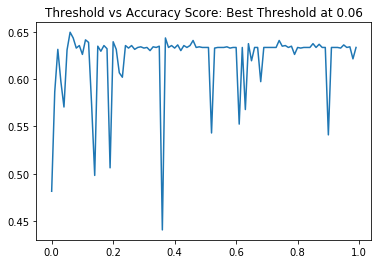

In [288]:
# Plot Best Threshold
sns.lineplot(x = threshold, y = AC, data = threshold_prediction) 
plt.title("Threshold vs Accuracy Score: Best Threshold at 0.06")
plt.show()

In [289]:
model = Sequential()
model.add(Dense(hidden_units, input_dim=input_dim, activation=hidden_layer_act))
model.add(Dense(hidden_units, activation=hidden_layer_act))
model.add(Dense(1, activation=output_layer_act))
sgd=optimizers.SGD(learning_rate=0.02)
model.compile(loss='binary_crossentropy',optimizer=sgd, metrics=['acc'])
model.fit(X_train, y_train, epochs=num_epochs, batch_size=len(X_train),  verbose=2)
ypred = model.predict(X_test)
prediction = pd.DataFrame (ypred, columns = ['Decision'])
prediction  = prediction['Decision'].apply(lambda Decision: 1 if Decision > 0.58 else 0)
ac = accuracy_score(y_test, prediction)

Epoch 1/60
1/1 - 0s - loss: 0.6640 - acc: 0.6339 - 283ms/epoch - 283ms/step
Epoch 2/60
1/1 - 0s - loss: 0.6617 - acc: 0.6339 - 3ms/epoch - 3ms/step
Epoch 3/60
1/1 - 0s - loss: 0.6606 - acc: 0.6339 - 3ms/epoch - 3ms/step
Epoch 4/60
1/1 - 0s - loss: 0.6600 - acc: 0.6339 - 2ms/epoch - 2ms/step
Epoch 5/60
1/1 - 0s - loss: 0.6596 - acc: 0.6339 - 2ms/epoch - 2ms/step
Epoch 6/60
1/1 - 0s - loss: 0.6591 - acc: 0.6339 - 3ms/epoch - 3ms/step
Epoch 7/60
1/1 - 0s - loss: 0.6588 - acc: 0.6339 - 4ms/epoch - 4ms/step
Epoch 8/60
1/1 - 0s - loss: 0.6584 - acc: 0.6339 - 4ms/epoch - 4ms/step
Epoch 9/60
1/1 - 0s - loss: 0.6581 - acc: 0.6339 - 4ms/epoch - 4ms/step
Epoch 10/60
1/1 - 0s - loss: 0.6579 - acc: 0.6339 - 5ms/epoch - 5ms/step
Epoch 11/60
1/1 - 0s - loss: 0.6577 - acc: 0.6339 - 3ms/epoch - 3ms/step
Epoch 12/60
1/1 - 0s - loss: 0.6575 - acc: 0.6339 - 4ms/epoch - 4ms/step
Epoch 13/60
1/1 - 0s - loss: 0.6573 - acc: 0.6339 - 3ms/epoch - 3ms/step
Epoch 14/60
1/1 - 0s - loss: 0.6572 - acc: 0.6339 - 4ms/

In [290]:
def predict(X_test,model):
    ypred = model.predict(X_test)
    prediction = pd.DataFrame (ypred, columns = ['Decision'])
    prediction  = prediction['Decision'].apply(lambda Decision: 1 if Decision > 0.62 else 0)
    return(prediction)

In [291]:
confusion_matrix(predict(X_test,model),y_test)

array([[118, 116],
       [430, 831]])

## 2. Class Weight

In [366]:
from sklearn.utils import class_weight
class_weights = class_weight.compute_class_weight('balanced', np.unique(y_train), y_train)
class_weights

/Users/yuchenlu/opt/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:72: FutureWarning: Pass classes=[0 1], y=3632    0
3729    1
2636    1
1309    1
4281    1
       ..
905     0
5192    1
3980    1
235     0
5157    1
Name: Decision, Length: 5976, dtype: int64 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  "will result in an error", FutureWarning)


array([1.36563071, 0.78880676])

In [396]:
# Defined Parameter
class_weight = {0:1,1: 0.95}
hidden_units= 20
learning_rate=0.06
num_epochs= 100
hidden_layer_act='tanh'
output_layer_act='sigmoid'
input_dim = X_train.shape[1]
model = Sequential()

# Model
model = Sequential()
model.add(Dense(hidden_units, input_dim=input_dim, activation=hidden_layer_act))
model.add(Dense(hidden_units, activation=hidden_layer_act))
model.add(Dense(1, activation=output_layer_act)) 


sgd=optimizers.SGD(learning_rate=learning_rate)
model.compile(loss='binary_crossentropy',optimizer=sgd, metrics=['acc'])
model.fit(X_train, y_train, epochs=num_epochs, batch_size=len(X_train),  verbose=2,class_weight=class_weight)
ypred = model.predict(X_test)
prediction = pd.DataFrame (ypred, columns = ['Decision'])
prediction  = prediction['Decision'].apply(lambda Decision: 1 if Decision > 0.58 else 0)
ac = accuracy_score(y_test, prediction)

Epoch 1/100
1/1 - 0s - loss: 0.7339 - acc: 0.3941 - 305ms/epoch - 305ms/step
Epoch 2/100
1/1 - 0s - loss: 0.6707 - acc: 0.5581 - 3ms/epoch - 3ms/step
Epoch 3/100
1/1 - 0s - loss: 0.6567 - acc: 0.5689 - 3ms/epoch - 3ms/step
Epoch 4/100
1/1 - 0s - loss: 0.6489 - acc: 0.6126 - 4ms/epoch - 4ms/step
Epoch 5/100
1/1 - 0s - loss: 0.6457 - acc: 0.6146 - 3ms/epoch - 3ms/step
Epoch 6/100
1/1 - 0s - loss: 0.6430 - acc: 0.6205 - 3ms/epoch - 3ms/step
Epoch 7/100
1/1 - 0s - loss: 0.6399 - acc: 0.6283 - 4ms/epoch - 4ms/step
Epoch 8/100
1/1 - 0s - loss: 0.6367 - acc: 0.6409 - 3ms/epoch - 3ms/step
Epoch 9/100
1/1 - 0s - loss: 0.6337 - acc: 0.6471 - 2ms/epoch - 2ms/step
Epoch 10/100
1/1 - 0s - loss: 0.6332 - acc: 0.6478 - 2ms/epoch - 2ms/step
Epoch 11/100
1/1 - 0s - loss: 0.6333 - acc: 0.6563 - 3ms/epoch - 3ms/step
Epoch 12/100
1/1 - 0s - loss: 0.6342 - acc: 0.6489 - 3ms/epoch - 3ms/step
Epoch 13/100
1/1 - 0s - loss: 0.6370 - acc: 0.6456 - 2ms/epoch - 2ms/step
Epoch 14/100
1/1 - 0s - loss: 0.6337 - acc:

In [397]:
confusion_matrix(predict(X_test,model),y_test)

array([[334, 506],
       [214, 441]])

In [398]:
# Submission Neuro Network Take one 
submission = pd.read_csv("Submission/sample_submission.csv")
prediction = predict(Test_data,model)
submission["Decision"] = prediction
submission["Decision"].value_counts()
# pd.DataFrame(submission).to_csv("NN_Base.csv",index=False)

0    1562
1     878
Name: Decision, dtype: int64

# Adding Class Weight doesn't improve performance as we expected, we add a regularzation term to the Neuro Network

In [343]:
# Defined Parameter
class_weight = {0: 1.19,1: 1}
hidden_units= 20
learning_rate=0.02
num_epochs= 100
hidden_layer_act='tanh'
output_layer_act='sigmoid'
input_dim = X_train.shape[1]
model = Sequential()

# Model Base Layer
model = Sequential()
model.add(Dense(hidden_units, input_dim=input_dim, activation=hidden_layer_act))
model.add(Dense(hidden_units, activation=hidden_layer_act))
model.add(Dense(1, activation=output_layer_act)) 
## Adding a regulariztion Layer
model.add(Dense(1, input_dim=input_dim,kernel_regularizer=regularizers.l1_l2(l1=0.01, l2=0.01))) 
## We need to further tune the parameter lambda and regularization l1 methods

sgd=optimizers.SGD(learning_rate=0.02)
model.compile(loss='binary_crossentropy',optimizer=sgd, metrics=['acc'])
 
# Train Model   
## Add Early Stopping  callbacks = [EarlyStopping(monitor='val_acc', patience=2)]
from keras.callbacks import EarlyStopping
model.fit(X_train, y_train, epochs=100, batch_size=len(X_train),
          verbose=2,class_weight=class_weight)
ypred = model.predict(X_test)
prediction = pd.DataFrame (ypred, columns = ['Decision'])
prediction  = prediction['Decision'].apply(lambda Decision: 1 if Decision > 0.58 else 0)
ac = accuracy_score(y_test, prediction)

Epoch 1/100
1/1 - 1s - loss: 9.7792 - acc: 0.3661 - 736ms/epoch - 736ms/step
Epoch 2/100
1/1 - 0s - loss: 9.7792 - acc: 0.3661 - 4ms/epoch - 4ms/step
Epoch 3/100
1/1 - 0s - loss: 9.7792 - acc: 0.3661 - 3ms/epoch - 3ms/step
Epoch 4/100
1/1 - 0s - loss: 9.7792 - acc: 0.3661 - 2ms/epoch - 2ms/step
Epoch 5/100
1/1 - 0s - loss: 9.7792 - acc: 0.3661 - 4ms/epoch - 4ms/step
Epoch 6/100
1/1 - 0s - loss: 9.7792 - acc: 0.3661 - 3ms/epoch - 3ms/step
Epoch 7/100
1/1 - 0s - loss: 9.7792 - acc: 0.3661 - 4ms/epoch - 4ms/step
Epoch 8/100
1/1 - 0s - loss: 9.7792 - acc: 0.3661 - 4ms/epoch - 4ms/step
Epoch 9/100
1/1 - 0s - loss: 9.7792 - acc: 0.3661 - 4ms/epoch - 4ms/step
Epoch 10/100
1/1 - 0s - loss: 9.7792 - acc: 0.3661 - 6ms/epoch - 6ms/step
Epoch 11/100
1/1 - 0s - loss: 9.7792 - acc: 0.3661 - 4ms/epoch - 4ms/step
Epoch 12/100
1/1 - 0s - loss: 9.7792 - acc: 0.3661 - 7ms/epoch - 7ms/step
Epoch 13/100
1/1 - 0s - loss: 9.7792 - acc: 0.3661 - 6ms/epoch - 6ms/step
Epoch 14/100
1/1 - 0s - loss: 9.7792 - acc:

In [344]:
confusion_matrix(predict(X_test,model),y_test)

array([[548, 947],
       [  0,   0]])

# 3. Eopoch Number

In [258]:
num_epochs = [10,100,1000,10000]
AC = []
class_weight = {0: 1.19,1: 1}
for i in num_epochs: 
    model = Sequential()
    model.add(Dense(hidden_units, input_dim=input_dim, activation=hidden_layer_act))
    model.add(Dense(hidden_units, activation=hidden_layer_act))
    model.add(Dense(1, activation=output_layer_act))
    sgd=optimizers.SGD(learning_rate= 0.02)
    model.compile(loss='binary_crossentropy',optimizer=sgd, metrics=['acc'])
    model.fit(X_train, y_train, epochs= i , batch_size=len(X_train),  verbose=2,class_weight=class_weight)
    ypred = model.predict(X_test)
    prediction = pd.DataFrame (ypred, columns = ['Decision'])
    prediction  = prediction['Decision'].apply(lambda Decision: 1 if Decision > 0.58 else 0)
    ac = accuracy_score(y_test, prediction)
    AC.append(ac)

Epoch 1/10
1/1 - 1s - loss: 0.8404 - acc: 0.3820 - 563ms/epoch - 563ms/step
Epoch 2/10
1/1 - 0s - loss: 0.8167 - acc: 0.3844 - 4ms/epoch - 4ms/step
Epoch 3/10
1/1 - 0s - loss: 0.7983 - acc: 0.3876 - 3ms/epoch - 3ms/step
Epoch 4/10
1/1 - 0s - loss: 0.7839 - acc: 0.3879 - 4ms/epoch - 4ms/step
Epoch 5/10
1/1 - 0s - loss: 0.7724 - acc: 0.3892 - 3ms/epoch - 3ms/step
Epoch 6/10
1/1 - 0s - loss: 0.7632 - acc: 0.4453 - 4ms/epoch - 4ms/step
Epoch 7/10
1/1 - 0s - loss: 0.7558 - acc: 0.4520 - 3ms/epoch - 3ms/step
Epoch 8/10
1/1 - 0s - loss: 0.7497 - acc: 0.4550 - 4ms/epoch - 4ms/step
Epoch 9/10
1/1 - 0s - loss: 0.7449 - acc: 0.4640 - 3ms/epoch - 3ms/step
Epoch 10/10
1/1 - 0s - loss: 0.7411 - acc: 0.4670 - 6ms/epoch - 6ms/step
Epoch 1/100
1/1 - 0s - loss: 0.7835 - acc: 0.5117 - 401ms/epoch - 401ms/step
Epoch 2/100
1/1 - 0s - loss: 0.7701 - acc: 0.5223 - 4ms/epoch - 4ms/step
Epoch 3/100
1/1 - 0s - loss: 0.7610 - acc: 0.5271 - 6ms/epoch - 6ms/step
Epoch 4/100
1/1 - 0s - loss: 0.7545 - acc: 0.5303 - 

Epoch 2/1000
1/1 - 0s - loss: 0.7359 - acc: 0.6011 - 2ms/epoch - 2ms/step
Epoch 3/1000
1/1 - 0s - loss: 0.7307 - acc: 0.6044 - 3ms/epoch - 3ms/step
Epoch 4/1000
1/1 - 0s - loss: 0.7277 - acc: 0.6066 - 3ms/epoch - 3ms/step
Epoch 5/1000
1/1 - 0s - loss: 0.7258 - acc: 0.6096 - 2ms/epoch - 2ms/step
Epoch 6/1000
1/1 - 0s - loss: 0.7241 - acc: 0.6124 - 3ms/epoch - 3ms/step
Epoch 7/1000
1/1 - 0s - loss: 0.7219 - acc: 0.6158 - 3ms/epoch - 3ms/step
Epoch 8/1000
1/1 - 0s - loss: 0.7194 - acc: 0.6213 - 2ms/epoch - 2ms/step
Epoch 9/1000
1/1 - 0s - loss: 0.7175 - acc: 0.6227 - 2ms/epoch - 2ms/step
Epoch 10/1000
1/1 - 0s - loss: 0.7152 - acc: 0.6268 - 3ms/epoch - 3ms/step
Epoch 11/1000
1/1 - 0s - loss: 0.7133 - acc: 0.6263 - 3ms/epoch - 3ms/step
Epoch 12/1000
1/1 - 0s - loss: 0.7126 - acc: 0.6287 - 3ms/epoch - 3ms/step
Epoch 13/1000
1/1 - 0s - loss: 0.7123 - acc: 0.6310 - 2ms/epoch - 2ms/step
Epoch 14/1000
1/1 - 0s - loss: 0.7122 - acc: 0.6314 - 3ms/epoch - 3ms/step
Epoch 15/1000
1/1 - 0s - loss: 0.

1/1 - 0s - loss: 0.7038 - acc: 0.6653 - 2ms/epoch - 2ms/step
Epoch 112/1000
1/1 - 0s - loss: 0.7037 - acc: 0.6616 - 3ms/epoch - 3ms/step
Epoch 113/1000
1/1 - 0s - loss: 0.7036 - acc: 0.6645 - 2ms/epoch - 2ms/step
Epoch 114/1000
1/1 - 0s - loss: 0.7033 - acc: 0.6611 - 2ms/epoch - 2ms/step
Epoch 115/1000
1/1 - 0s - loss: 0.7037 - acc: 0.6638 - 2ms/epoch - 2ms/step
Epoch 116/1000
1/1 - 0s - loss: 0.7036 - acc: 0.6613 - 2ms/epoch - 2ms/step
Epoch 117/1000
1/1 - 0s - loss: 0.7040 - acc: 0.6625 - 2ms/epoch - 2ms/step
Epoch 118/1000
1/1 - 0s - loss: 0.7041 - acc: 0.6598 - 2ms/epoch - 2ms/step
Epoch 119/1000
1/1 - 0s - loss: 0.7050 - acc: 0.6606 - 2ms/epoch - 2ms/step
Epoch 120/1000
1/1 - 0s - loss: 0.7047 - acc: 0.6586 - 2ms/epoch - 2ms/step
Epoch 121/1000
1/1 - 0s - loss: 0.7029 - acc: 0.6635 - 2ms/epoch - 2ms/step
Epoch 122/1000
1/1 - 0s - loss: 0.7047 - acc: 0.6638 - 2ms/epoch - 2ms/step
Epoch 123/1000
1/1 - 0s - loss: 0.7036 - acc: 0.6640 - 3ms/epoch - 3ms/step
Epoch 124/1000
1/1 - 0s - l

Epoch 219/1000
1/1 - 0s - loss: 0.6943 - acc: 0.6700 - 2ms/epoch - 2ms/step
Epoch 220/1000
1/1 - 0s - loss: 0.6933 - acc: 0.6660 - 2ms/epoch - 2ms/step
Epoch 221/1000
1/1 - 0s - loss: 0.6972 - acc: 0.6657 - 2ms/epoch - 2ms/step
Epoch 222/1000
1/1 - 0s - loss: 0.6934 - acc: 0.6670 - 2ms/epoch - 2ms/step
Epoch 223/1000
1/1 - 0s - loss: 0.6972 - acc: 0.6667 - 3ms/epoch - 3ms/step
Epoch 224/1000
1/1 - 0s - loss: 0.6930 - acc: 0.6662 - 3ms/epoch - 3ms/step
Epoch 225/1000
1/1 - 0s - loss: 0.6961 - acc: 0.6678 - 2ms/epoch - 2ms/step
Epoch 226/1000
1/1 - 0s - loss: 0.6930 - acc: 0.6698 - 2ms/epoch - 2ms/step
Epoch 227/1000
1/1 - 0s - loss: 0.6966 - acc: 0.6697 - 2ms/epoch - 2ms/step
Epoch 228/1000
1/1 - 0s - loss: 0.6927 - acc: 0.6655 - 2ms/epoch - 2ms/step
Epoch 229/1000
1/1 - 0s - loss: 0.6949 - acc: 0.6682 - 3ms/epoch - 3ms/step
Epoch 230/1000
1/1 - 0s - loss: 0.6926 - acc: 0.6720 - 3ms/epoch - 3ms/step
Epoch 231/1000
1/1 - 0s - loss: 0.6954 - acc: 0.6712 - 2ms/epoch - 2ms/step
Epoch 232/10

Epoch 327/1000
1/1 - 0s - loss: 0.6888 - acc: 0.6724 - 2ms/epoch - 2ms/step
Epoch 328/1000
1/1 - 0s - loss: 0.6883 - acc: 0.6675 - 2ms/epoch - 2ms/step
Epoch 329/1000
1/1 - 0s - loss: 0.6903 - acc: 0.6707 - 2ms/epoch - 2ms/step
Epoch 330/1000
1/1 - 0s - loss: 0.6880 - acc: 0.6662 - 2ms/epoch - 2ms/step
Epoch 331/1000
1/1 - 0s - loss: 0.6896 - acc: 0.6724 - 2ms/epoch - 2ms/step
Epoch 332/1000
1/1 - 0s - loss: 0.6887 - acc: 0.6660 - 2ms/epoch - 2ms/step
Epoch 333/1000
1/1 - 0s - loss: 0.6912 - acc: 0.6688 - 2ms/epoch - 2ms/step
Epoch 334/1000
1/1 - 0s - loss: 0.6877 - acc: 0.6705 - 2ms/epoch - 2ms/step
Epoch 335/1000
1/1 - 0s - loss: 0.6885 - acc: 0.6725 - 2ms/epoch - 2ms/step
Epoch 336/1000
1/1 - 0s - loss: 0.6881 - acc: 0.6680 - 2ms/epoch - 2ms/step
Epoch 337/1000
1/1 - 0s - loss: 0.6900 - acc: 0.6710 - 2ms/epoch - 2ms/step
Epoch 338/1000
1/1 - 0s - loss: 0.6878 - acc: 0.6677 - 2ms/epoch - 2ms/step
Epoch 339/1000
1/1 - 0s - loss: 0.6893 - acc: 0.6725 - 2ms/epoch - 2ms/step
Epoch 340/10

Epoch 435/1000
1/1 - 0s - loss: 0.6875 - acc: 0.6734 - 3ms/epoch - 3ms/step
Epoch 436/1000
1/1 - 0s - loss: 0.6867 - acc: 0.6647 - 3ms/epoch - 3ms/step
Epoch 437/1000
1/1 - 0s - loss: 0.6895 - acc: 0.6710 - 2ms/epoch - 2ms/step
Epoch 438/1000
1/1 - 0s - loss: 0.6854 - acc: 0.6668 - 2ms/epoch - 2ms/step
Epoch 439/1000
1/1 - 0s - loss: 0.6861 - acc: 0.6754 - 3ms/epoch - 3ms/step
Epoch 440/1000
1/1 - 0s - loss: 0.6858 - acc: 0.6688 - 3ms/epoch - 3ms/step
Epoch 441/1000
1/1 - 0s - loss: 0.6877 - acc: 0.6732 - 4ms/epoch - 4ms/step
Epoch 442/1000
1/1 - 0s - loss: 0.6857 - acc: 0.6638 - 3ms/epoch - 3ms/step
Epoch 443/1000
1/1 - 0s - loss: 0.6874 - acc: 0.6730 - 4ms/epoch - 4ms/step
Epoch 444/1000
1/1 - 0s - loss: 0.6865 - acc: 0.6643 - 18ms/epoch - 18ms/step
Epoch 445/1000
1/1 - 0s - loss: 0.6894 - acc: 0.6709 - 6ms/epoch - 6ms/step
Epoch 446/1000
1/1 - 0s - loss: 0.6853 - acc: 0.6672 - 4ms/epoch - 4ms/step
Epoch 447/1000
1/1 - 0s - loss: 0.6860 - acc: 0.6752 - 4ms/epoch - 4ms/step
Epoch 448/

Epoch 543/1000
1/1 - 0s - loss: 0.6857 - acc: 0.6730 - 2ms/epoch - 2ms/step
Epoch 544/1000
1/1 - 0s - loss: 0.6852 - acc: 0.6647 - 2ms/epoch - 2ms/step
Epoch 545/1000
1/1 - 0s - loss: 0.6884 - acc: 0.6709 - 3ms/epoch - 3ms/step
Epoch 546/1000
1/1 - 0s - loss: 0.6839 - acc: 0.6648 - 3ms/epoch - 3ms/step
Epoch 547/1000
1/1 - 0s - loss: 0.6843 - acc: 0.6759 - 2ms/epoch - 2ms/step
Epoch 548/1000
1/1 - 0s - loss: 0.6837 - acc: 0.6690 - 2ms/epoch - 2ms/step
Epoch 549/1000
1/1 - 0s - loss: 0.6851 - acc: 0.6734 - 3ms/epoch - 3ms/step
Epoch 550/1000
1/1 - 0s - loss: 0.6843 - acc: 0.6645 - 2ms/epoch - 2ms/step
Epoch 551/1000
1/1 - 0s - loss: 0.6868 - acc: 0.6715 - 2ms/epoch - 2ms/step
Epoch 552/1000
1/1 - 0s - loss: 0.6845 - acc: 0.6653 - 2ms/epoch - 2ms/step
Epoch 553/1000
1/1 - 0s - loss: 0.6872 - acc: 0.6715 - 3ms/epoch - 3ms/step
Epoch 554/1000
1/1 - 0s - loss: 0.6840 - acc: 0.6648 - 2ms/epoch - 2ms/step
Epoch 555/1000
1/1 - 0s - loss: 0.6861 - acc: 0.6722 - 2ms/epoch - 2ms/step
Epoch 556/10

Epoch 651/1000
1/1 - 0s - loss: 0.6832 - acc: 0.6752 - 3ms/epoch - 3ms/step
Epoch 652/1000
1/1 - 0s - loss: 0.6817 - acc: 0.6730 - 2ms/epoch - 2ms/step
Epoch 653/1000
1/1 - 0s - loss: 0.6823 - acc: 0.6744 - 2ms/epoch - 2ms/step
Epoch 654/1000
1/1 - 0s - loss: 0.6827 - acc: 0.6657 - 3ms/epoch - 3ms/step
Epoch 655/1000
1/1 - 0s - loss: 0.6852 - acc: 0.6722 - 2ms/epoch - 2ms/step
Epoch 656/1000
1/1 - 0s - loss: 0.6831 - acc: 0.6613 - 2ms/epoch - 2ms/step
Epoch 657/1000
1/1 - 0s - loss: 0.6862 - acc: 0.6715 - 3ms/epoch - 3ms/step
Epoch 658/1000
1/1 - 0s - loss: 0.6833 - acc: 0.6667 - 2ms/epoch - 2ms/step
Epoch 659/1000
1/1 - 0s - loss: 0.6862 - acc: 0.6724 - 2ms/epoch - 2ms/step
Epoch 660/1000
1/1 - 0s - loss: 0.6825 - acc: 0.6633 - 2ms/epoch - 2ms/step
Epoch 661/1000
1/1 - 0s - loss: 0.6840 - acc: 0.6742 - 3ms/epoch - 3ms/step
Epoch 662/1000
1/1 - 0s - loss: 0.6836 - acc: 0.6677 - 3ms/epoch - 3ms/step
Epoch 663/1000
1/1 - 0s - loss: 0.6865 - acc: 0.6707 - 2ms/epoch - 2ms/step
Epoch 664/10

Epoch 759/1000
1/1 - 0s - loss: 0.6800 - acc: 0.6725 - 3ms/epoch - 3ms/step
Epoch 760/1000
1/1 - 0s - loss: 0.6802 - acc: 0.6759 - 3ms/epoch - 3ms/step
Epoch 761/1000
1/1 - 0s - loss: 0.6808 - acc: 0.6693 - 3ms/epoch - 3ms/step
Epoch 762/1000
1/1 - 0s - loss: 0.6825 - acc: 0.6737 - 2ms/epoch - 2ms/step
Epoch 763/1000
1/1 - 0s - loss: 0.6829 - acc: 0.6620 - 2ms/epoch - 2ms/step
Epoch 764/1000
1/1 - 0s - loss: 0.6881 - acc: 0.6702 - 3ms/epoch - 3ms/step
Epoch 765/1000
1/1 - 0s - loss: 0.6805 - acc: 0.6692 - 3ms/epoch - 3ms/step
Epoch 766/1000
1/1 - 0s - loss: 0.6811 - acc: 0.6765 - 2ms/epoch - 2ms/step
Epoch 767/1000
1/1 - 0s - loss: 0.6822 - acc: 0.6653 - 2ms/epoch - 2ms/step
Epoch 768/1000
1/1 - 0s - loss: 0.6861 - acc: 0.6727 - 3ms/epoch - 3ms/step
Epoch 769/1000
1/1 - 0s - loss: 0.6813 - acc: 0.6630 - 2ms/epoch - 2ms/step
Epoch 770/1000
1/1 - 0s - loss: 0.6835 - acc: 0.6730 - 2ms/epoch - 2ms/step
Epoch 771/1000
1/1 - 0s - loss: 0.6831 - acc: 0.6657 - 2ms/epoch - 2ms/step
Epoch 772/10

Epoch 867/1000
1/1 - 0s - loss: 0.6866 - acc: 0.6707 - 2ms/epoch - 2ms/step
Epoch 868/1000
1/1 - 0s - loss: 0.6801 - acc: 0.6658 - 2ms/epoch - 2ms/step
Epoch 869/1000
1/1 - 0s - loss: 0.6811 - acc: 0.6769 - 2ms/epoch - 2ms/step
Epoch 870/1000
1/1 - 0s - loss: 0.6806 - acc: 0.6687 - 3ms/epoch - 3ms/step
Epoch 871/1000
1/1 - 0s - loss: 0.6830 - acc: 0.6730 - 2ms/epoch - 2ms/step
Epoch 872/1000
1/1 - 0s - loss: 0.6808 - acc: 0.6643 - 2ms/epoch - 2ms/step
Epoch 873/1000
1/1 - 0s - loss: 0.6841 - acc: 0.6730 - 2ms/epoch - 2ms/step
Epoch 874/1000
1/1 - 0s - loss: 0.6821 - acc: 0.6667 - 3ms/epoch - 3ms/step
Epoch 875/1000
1/1 - 0s - loss: 0.6859 - acc: 0.6695 - 2ms/epoch - 2ms/step
Epoch 876/1000
1/1 - 0s - loss: 0.6818 - acc: 0.6618 - 2ms/epoch - 2ms/step
Epoch 877/1000
1/1 - 0s - loss: 0.6816 - acc: 0.6734 - 2ms/epoch - 2ms/step
Epoch 878/1000
1/1 - 0s - loss: 0.6793 - acc: 0.6797 - 2ms/epoch - 2ms/step
Epoch 879/1000
1/1 - 0s - loss: 0.6791 - acc: 0.6732 - 2ms/epoch - 2ms/step
Epoch 880/10

Epoch 975/1000
1/1 - 0s - loss: 0.6809 - acc: 0.6613 - 4ms/epoch - 4ms/step
Epoch 976/1000
1/1 - 0s - loss: 0.6813 - acc: 0.6745 - 3ms/epoch - 3ms/step
Epoch 977/1000
1/1 - 0s - loss: 0.6786 - acc: 0.6790 - 2ms/epoch - 2ms/step
Epoch 978/1000
1/1 - 0s - loss: 0.6784 - acc: 0.6712 - 4ms/epoch - 4ms/step
Epoch 979/1000
1/1 - 0s - loss: 0.6788 - acc: 0.6779 - 3ms/epoch - 3ms/step
Epoch 980/1000
1/1 - 0s - loss: 0.6797 - acc: 0.6678 - 19ms/epoch - 19ms/step
Epoch 981/1000
1/1 - 0s - loss: 0.6829 - acc: 0.6742 - 19ms/epoch - 19ms/step
Epoch 982/1000
1/1 - 0s - loss: 0.6803 - acc: 0.6652 - 5ms/epoch - 5ms/step
Epoch 983/1000
1/1 - 0s - loss: 0.6846 - acc: 0.6734 - 3ms/epoch - 3ms/step
Epoch 984/1000
1/1 - 0s - loss: 0.6806 - acc: 0.6700 - 7ms/epoch - 7ms/step
Epoch 985/1000
1/1 - 0s - loss: 0.6839 - acc: 0.6714 - 2ms/epoch - 2ms/step
Epoch 986/1000
1/1 - 0s - loss: 0.6799 - acc: 0.6643 - 3ms/epoch - 3ms/step
Epoch 987/1000
1/1 - 0s - loss: 0.6807 - acc: 0.6745 - 3ms/epoch - 3ms/step
Epoch 98

Epoch 83/10000
1/1 - 0s - loss: 0.7148 - acc: 0.6424 - 3ms/epoch - 3ms/step
Epoch 84/10000
1/1 - 0s - loss: 0.7148 - acc: 0.6424 - 3ms/epoch - 3ms/step
Epoch 85/10000
1/1 - 0s - loss: 0.7147 - acc: 0.6427 - 3ms/epoch - 3ms/step
Epoch 86/10000
1/1 - 0s - loss: 0.7147 - acc: 0.6427 - 2ms/epoch - 2ms/step
Epoch 87/10000
1/1 - 0s - loss: 0.7146 - acc: 0.6432 - 3ms/epoch - 3ms/step
Epoch 88/10000
1/1 - 0s - loss: 0.7146 - acc: 0.6437 - 3ms/epoch - 3ms/step
Epoch 89/10000
1/1 - 0s - loss: 0.7145 - acc: 0.6441 - 2ms/epoch - 2ms/step
Epoch 90/10000
1/1 - 0s - loss: 0.7145 - acc: 0.6442 - 2ms/epoch - 2ms/step
Epoch 91/10000
1/1 - 0s - loss: 0.7144 - acc: 0.6441 - 3ms/epoch - 3ms/step
Epoch 92/10000
1/1 - 0s - loss: 0.7144 - acc: 0.6442 - 2ms/epoch - 2ms/step
Epoch 93/10000
1/1 - 0s - loss: 0.7143 - acc: 0.6439 - 2ms/epoch - 2ms/step
Epoch 94/10000
1/1 - 0s - loss: 0.7143 - acc: 0.6439 - 2ms/epoch - 2ms/step
Epoch 95/10000
1/1 - 0s - loss: 0.7142 - acc: 0.6441 - 3ms/epoch - 3ms/step
Epoch 96/100

Epoch 190/10000
1/1 - 0s - loss: 0.7098 - acc: 0.6496 - 2ms/epoch - 2ms/step
Epoch 191/10000
1/1 - 0s - loss: 0.7098 - acc: 0.6494 - 3ms/epoch - 3ms/step
Epoch 192/10000
1/1 - 0s - loss: 0.7097 - acc: 0.6496 - 2ms/epoch - 2ms/step
Epoch 193/10000
1/1 - 0s - loss: 0.7097 - acc: 0.6498 - 2ms/epoch - 2ms/step
Epoch 194/10000
1/1 - 0s - loss: 0.7096 - acc: 0.6499 - 3ms/epoch - 3ms/step
Epoch 195/10000
1/1 - 0s - loss: 0.7096 - acc: 0.6499 - 3ms/epoch - 3ms/step
Epoch 196/10000
1/1 - 0s - loss: 0.7095 - acc: 0.6501 - 2ms/epoch - 2ms/step
Epoch 197/10000
1/1 - 0s - loss: 0.7095 - acc: 0.6506 - 2ms/epoch - 2ms/step
Epoch 198/10000
1/1 - 0s - loss: 0.7094 - acc: 0.6508 - 3ms/epoch - 3ms/step
Epoch 199/10000
1/1 - 0s - loss: 0.7094 - acc: 0.6508 - 3ms/epoch - 3ms/step
Epoch 200/10000
1/1 - 0s - loss: 0.7094 - acc: 0.6509 - 2ms/epoch - 2ms/step
Epoch 201/10000
1/1 - 0s - loss: 0.7093 - acc: 0.6509 - 2ms/epoch - 2ms/step
Epoch 202/10000
1/1 - 0s - loss: 0.7093 - acc: 0.6511 - 4ms/epoch - 4ms/step

Epoch 297/10000
1/1 - 0s - loss: 0.7055 - acc: 0.6566 - 3ms/epoch - 3ms/step
Epoch 298/10000
1/1 - 0s - loss: 0.7054 - acc: 0.6566 - 3ms/epoch - 3ms/step
Epoch 299/10000
1/1 - 0s - loss: 0.7054 - acc: 0.6566 - 2ms/epoch - 2ms/step
Epoch 300/10000
1/1 - 0s - loss: 0.7053 - acc: 0.6566 - 3ms/epoch - 3ms/step
Epoch 301/10000
1/1 - 0s - loss: 0.7053 - acc: 0.6565 - 4ms/epoch - 4ms/step
Epoch 302/10000
1/1 - 0s - loss: 0.7053 - acc: 0.6565 - 3ms/epoch - 3ms/step
Epoch 303/10000
1/1 - 0s - loss: 0.7052 - acc: 0.6566 - 4ms/epoch - 4ms/step
Epoch 304/10000
1/1 - 0s - loss: 0.7052 - acc: 0.6566 - 4ms/epoch - 4ms/step
Epoch 305/10000
1/1 - 0s - loss: 0.7052 - acc: 0.6566 - 2ms/epoch - 2ms/step
Epoch 306/10000
1/1 - 0s - loss: 0.7051 - acc: 0.6566 - 3ms/epoch - 3ms/step
Epoch 307/10000
1/1 - 0s - loss: 0.7051 - acc: 0.6568 - 3ms/epoch - 3ms/step
Epoch 308/10000
1/1 - 0s - loss: 0.7050 - acc: 0.6568 - 2ms/epoch - 2ms/step
Epoch 309/10000
1/1 - 0s - loss: 0.7050 - acc: 0.6570 - 2ms/epoch - 2ms/step

Epoch 404/10000
1/1 - 0s - loss: 0.7016 - acc: 0.6632 - 4ms/epoch - 4ms/step
Epoch 405/10000
1/1 - 0s - loss: 0.7015 - acc: 0.6633 - 4ms/epoch - 4ms/step
Epoch 406/10000
1/1 - 0s - loss: 0.7015 - acc: 0.6635 - 2ms/epoch - 2ms/step
Epoch 407/10000
1/1 - 0s - loss: 0.7015 - acc: 0.6637 - 3ms/epoch - 3ms/step
Epoch 408/10000
1/1 - 0s - loss: 0.7014 - acc: 0.6637 - 3ms/epoch - 3ms/step
Epoch 409/10000
1/1 - 0s - loss: 0.7014 - acc: 0.6637 - 4ms/epoch - 4ms/step
Epoch 410/10000
1/1 - 0s - loss: 0.7013 - acc: 0.6640 - 2ms/epoch - 2ms/step
Epoch 411/10000
1/1 - 0s - loss: 0.7013 - acc: 0.6640 - 2ms/epoch - 2ms/step
Epoch 412/10000
1/1 - 0s - loss: 0.7013 - acc: 0.6640 - 4ms/epoch - 4ms/step
Epoch 413/10000
1/1 - 0s - loss: 0.7012 - acc: 0.6640 - 2ms/epoch - 2ms/step
Epoch 414/10000
1/1 - 0s - loss: 0.7012 - acc: 0.6640 - 3ms/epoch - 3ms/step
Epoch 415/10000
1/1 - 0s - loss: 0.7012 - acc: 0.6640 - 3ms/epoch - 3ms/step
Epoch 416/10000
1/1 - 0s - loss: 0.7011 - acc: 0.6642 - 3ms/epoch - 3ms/step

Epoch 511/10000
1/1 - 0s - loss: 0.6989 - acc: 0.6652 - 3ms/epoch - 3ms/step
Epoch 512/10000
1/1 - 0s - loss: 0.6984 - acc: 0.6623 - 3ms/epoch - 3ms/step
Epoch 513/10000
1/1 - 0s - loss: 0.6988 - acc: 0.6653 - 2ms/epoch - 2ms/step
Epoch 514/10000
1/1 - 0s - loss: 0.6983 - acc: 0.6625 - 2ms/epoch - 2ms/step
Epoch 515/10000
1/1 - 0s - loss: 0.6988 - acc: 0.6653 - 3ms/epoch - 3ms/step
Epoch 516/10000
1/1 - 0s - loss: 0.6982 - acc: 0.6628 - 3ms/epoch - 3ms/step
Epoch 517/10000
1/1 - 0s - loss: 0.6987 - acc: 0.6652 - 2ms/epoch - 2ms/step
Epoch 518/10000
1/1 - 0s - loss: 0.6982 - acc: 0.6630 - 2ms/epoch - 2ms/step
Epoch 519/10000
1/1 - 0s - loss: 0.6987 - acc: 0.6653 - 4ms/epoch - 4ms/step
Epoch 520/10000
1/1 - 0s - loss: 0.6981 - acc: 0.6628 - 2ms/epoch - 2ms/step
Epoch 521/10000
1/1 - 0s - loss: 0.6986 - acc: 0.6652 - 3ms/epoch - 3ms/step
Epoch 522/10000
1/1 - 0s - loss: 0.6980 - acc: 0.6628 - 3ms/epoch - 3ms/step
Epoch 523/10000
1/1 - 0s - loss: 0.6986 - acc: 0.6653 - 3ms/epoch - 3ms/step

Epoch 618/10000
1/1 - 0s - loss: 0.6948 - acc: 0.6643 - 3ms/epoch - 3ms/step
Epoch 619/10000
1/1 - 0s - loss: 0.6954 - acc: 0.6663 - 2ms/epoch - 2ms/step
Epoch 620/10000
1/1 - 0s - loss: 0.6948 - acc: 0.6638 - 3ms/epoch - 3ms/step
Epoch 621/10000
1/1 - 0s - loss: 0.6953 - acc: 0.6665 - 3ms/epoch - 3ms/step
Epoch 622/10000
1/1 - 0s - loss: 0.6947 - acc: 0.6640 - 3ms/epoch - 3ms/step
Epoch 623/10000
1/1 - 0s - loss: 0.6953 - acc: 0.6665 - 2ms/epoch - 2ms/step
Epoch 624/10000
1/1 - 0s - loss: 0.6946 - acc: 0.6642 - 3ms/epoch - 3ms/step
Epoch 625/10000
1/1 - 0s - loss: 0.6952 - acc: 0.6663 - 2ms/epoch - 2ms/step
Epoch 626/10000
1/1 - 0s - loss: 0.6945 - acc: 0.6638 - 2ms/epoch - 2ms/step
Epoch 627/10000
1/1 - 0s - loss: 0.6951 - acc: 0.6665 - 2ms/epoch - 2ms/step
Epoch 628/10000
1/1 - 0s - loss: 0.6945 - acc: 0.6637 - 3ms/epoch - 3ms/step
Epoch 629/10000
1/1 - 0s - loss: 0.6950 - acc: 0.6663 - 2ms/epoch - 2ms/step
Epoch 630/10000
1/1 - 0s - loss: 0.6944 - acc: 0.6635 - 2ms/epoch - 2ms/step

Epoch 725/10000
1/1 - 0s - loss: 0.6925 - acc: 0.6678 - 3ms/epoch - 3ms/step
Epoch 726/10000
1/1 - 0s - loss: 0.6912 - acc: 0.6698 - 2ms/epoch - 2ms/step
Epoch 727/10000
1/1 - 0s - loss: 0.6925 - acc: 0.6678 - 2ms/epoch - 2ms/step
Epoch 728/10000
1/1 - 0s - loss: 0.6912 - acc: 0.6697 - 3ms/epoch - 3ms/step
Epoch 729/10000
1/1 - 0s - loss: 0.6924 - acc: 0.6678 - 3ms/epoch - 3ms/step
Epoch 730/10000
1/1 - 0s - loss: 0.6911 - acc: 0.6698 - 2ms/epoch - 2ms/step
Epoch 731/10000
1/1 - 0s - loss: 0.6924 - acc: 0.6680 - 2ms/epoch - 2ms/step
Epoch 732/10000
1/1 - 0s - loss: 0.6911 - acc: 0.6700 - 3ms/epoch - 3ms/step
Epoch 733/10000
1/1 - 0s - loss: 0.6923 - acc: 0.6682 - 3ms/epoch - 3ms/step
Epoch 734/10000
1/1 - 0s - loss: 0.6910 - acc: 0.6700 - 2ms/epoch - 2ms/step
Epoch 735/10000
1/1 - 0s - loss: 0.6923 - acc: 0.6685 - 2ms/epoch - 2ms/step
Epoch 736/10000
1/1 - 0s - loss: 0.6910 - acc: 0.6703 - 2ms/epoch - 2ms/step
Epoch 737/10000
1/1 - 0s - loss: 0.6922 - acc: 0.6688 - 3ms/epoch - 3ms/step

Epoch 832/10000
1/1 - 0s - loss: 0.6886 - acc: 0.6709 - 3ms/epoch - 3ms/step
Epoch 833/10000
1/1 - 0s - loss: 0.6899 - acc: 0.6725 - 2ms/epoch - 2ms/step
Epoch 834/10000
1/1 - 0s - loss: 0.6886 - acc: 0.6709 - 2ms/epoch - 2ms/step
Epoch 835/10000
1/1 - 0s - loss: 0.6899 - acc: 0.6725 - 3ms/epoch - 3ms/step
Epoch 836/10000
1/1 - 0s - loss: 0.6885 - acc: 0.6710 - 2ms/epoch - 2ms/step
Epoch 837/10000
1/1 - 0s - loss: 0.6898 - acc: 0.6727 - 2ms/epoch - 2ms/step
Epoch 838/10000
1/1 - 0s - loss: 0.6885 - acc: 0.6710 - 2ms/epoch - 2ms/step
Epoch 839/10000
1/1 - 0s - loss: 0.6898 - acc: 0.6725 - 3ms/epoch - 3ms/step
Epoch 840/10000
1/1 - 0s - loss: 0.6885 - acc: 0.6714 - 3ms/epoch - 3ms/step
Epoch 841/10000
1/1 - 0s - loss: 0.6898 - acc: 0.6725 - 2ms/epoch - 2ms/step
Epoch 842/10000
1/1 - 0s - loss: 0.6884 - acc: 0.6715 - 2ms/epoch - 2ms/step
Epoch 843/10000
1/1 - 0s - loss: 0.6897 - acc: 0.6727 - 2ms/epoch - 2ms/step
Epoch 844/10000
1/1 - 0s - loss: 0.6884 - acc: 0.6714 - 3ms/epoch - 3ms/step

Epoch 939/10000
1/1 - 0s - loss: 0.6877 - acc: 0.6755 - 3ms/epoch - 3ms/step
Epoch 940/10000
1/1 - 0s - loss: 0.6863 - acc: 0.6729 - 2ms/epoch - 2ms/step
Epoch 941/10000
1/1 - 0s - loss: 0.6877 - acc: 0.6757 - 3ms/epoch - 3ms/step
Epoch 942/10000
1/1 - 0s - loss: 0.6863 - acc: 0.6729 - 3ms/epoch - 3ms/step
Epoch 943/10000
1/1 - 0s - loss: 0.6876 - acc: 0.6754 - 3ms/epoch - 3ms/step
Epoch 944/10000
1/1 - 0s - loss: 0.6862 - acc: 0.6729 - 2ms/epoch - 2ms/step
Epoch 945/10000
1/1 - 0s - loss: 0.6876 - acc: 0.6755 - 3ms/epoch - 3ms/step
Epoch 946/10000
1/1 - 0s - loss: 0.6862 - acc: 0.6729 - 3ms/epoch - 3ms/step
Epoch 947/10000
1/1 - 0s - loss: 0.6876 - acc: 0.6755 - 2ms/epoch - 2ms/step
Epoch 948/10000
1/1 - 0s - loss: 0.6862 - acc: 0.6730 - 2ms/epoch - 2ms/step
Epoch 949/10000
1/1 - 0s - loss: 0.6875 - acc: 0.6755 - 3ms/epoch - 3ms/step
Epoch 950/10000
1/1 - 0s - loss: 0.6861 - acc: 0.6725 - 3ms/epoch - 3ms/step
Epoch 951/10000
1/1 - 0s - loss: 0.6875 - acc: 0.6754 - 2ms/epoch - 2ms/step

Epoch 1045/10000
1/1 - 0s - loss: 0.6860 - acc: 0.6775 - 3ms/epoch - 3ms/step
Epoch 1046/10000
1/1 - 0s - loss: 0.6845 - acc: 0.6715 - 2ms/epoch - 2ms/step
Epoch 1047/10000
1/1 - 0s - loss: 0.6860 - acc: 0.6775 - 2ms/epoch - 2ms/step
Epoch 1048/10000
1/1 - 0s - loss: 0.6844 - acc: 0.6715 - 2ms/epoch - 2ms/step
Epoch 1049/10000
1/1 - 0s - loss: 0.6859 - acc: 0.6775 - 2ms/epoch - 2ms/step
Epoch 1050/10000
1/1 - 0s - loss: 0.6844 - acc: 0.6715 - 3ms/epoch - 3ms/step
Epoch 1051/10000
1/1 - 0s - loss: 0.6859 - acc: 0.6775 - 2ms/epoch - 2ms/step
Epoch 1052/10000
1/1 - 0s - loss: 0.6844 - acc: 0.6717 - 3ms/epoch - 3ms/step
Epoch 1053/10000
1/1 - 0s - loss: 0.6859 - acc: 0.6777 - 2ms/epoch - 2ms/step
Epoch 1054/10000
1/1 - 0s - loss: 0.6843 - acc: 0.6717 - 2ms/epoch - 2ms/step
Epoch 1055/10000
1/1 - 0s - loss: 0.6858 - acc: 0.6777 - 3ms/epoch - 3ms/step
Epoch 1056/10000
1/1 - 0s - loss: 0.6843 - acc: 0.6712 - 3ms/epoch - 3ms/step
Epoch 1057/10000
1/1 - 0s - loss: 0.6858 - acc: 0.6775 - 3ms/epo

1/1 - 0s - loss: 0.6829 - acc: 0.6727 - 3ms/epoch - 3ms/step
Epoch 1151/10000
1/1 - 0s - loss: 0.6846 - acc: 0.6779 - 3ms/epoch - 3ms/step
Epoch 1152/10000
1/1 - 0s - loss: 0.6829 - acc: 0.6734 - 3ms/epoch - 3ms/step
Epoch 1153/10000
1/1 - 0s - loss: 0.6845 - acc: 0.6779 - 3ms/epoch - 3ms/step
Epoch 1154/10000
1/1 - 0s - loss: 0.6828 - acc: 0.6734 - 2ms/epoch - 2ms/step
Epoch 1155/10000
1/1 - 0s - loss: 0.6845 - acc: 0.6779 - 3ms/epoch - 3ms/step
Epoch 1156/10000
1/1 - 0s - loss: 0.6828 - acc: 0.6735 - 3ms/epoch - 3ms/step
Epoch 1157/10000
1/1 - 0s - loss: 0.6845 - acc: 0.6777 - 2ms/epoch - 2ms/step
Epoch 1158/10000
1/1 - 0s - loss: 0.6828 - acc: 0.6737 - 2ms/epoch - 2ms/step
Epoch 1159/10000
1/1 - 0s - loss: 0.6845 - acc: 0.6777 - 3ms/epoch - 3ms/step
Epoch 1160/10000
1/1 - 0s - loss: 0.6828 - acc: 0.6739 - 3ms/epoch - 3ms/step
Epoch 1161/10000
1/1 - 0s - loss: 0.6844 - acc: 0.6777 - 2ms/epoch - 2ms/step
Epoch 1162/10000
1/1 - 0s - loss: 0.6827 - acc: 0.6739 - 3ms/epoch - 3ms/step
Epo

Epoch 1256/10000
1/1 - 0s - loss: 0.6814 - acc: 0.6735 - 3ms/epoch - 3ms/step
Epoch 1257/10000
1/1 - 0s - loss: 0.6827 - acc: 0.6806 - 3ms/epoch - 3ms/step
Epoch 1258/10000
1/1 - 0s - loss: 0.6817 - acc: 0.6740 - 3ms/epoch - 3ms/step
Epoch 1259/10000
1/1 - 0s - loss: 0.6838 - acc: 0.6785 - 3ms/epoch - 3ms/step
Epoch 1260/10000
1/1 - 0s - loss: 0.6813 - acc: 0.6737 - 3ms/epoch - 3ms/step
Epoch 1261/10000
1/1 - 0s - loss: 0.6826 - acc: 0.6801 - 2ms/epoch - 2ms/step
Epoch 1262/10000
1/1 - 0s - loss: 0.6817 - acc: 0.6742 - 3ms/epoch - 3ms/step
Epoch 1263/10000
1/1 - 0s - loss: 0.6838 - acc: 0.6784 - 2ms/epoch - 2ms/step
Epoch 1264/10000
1/1 - 0s - loss: 0.6813 - acc: 0.6737 - 2ms/epoch - 2ms/step
Epoch 1265/10000
1/1 - 0s - loss: 0.6826 - acc: 0.6801 - 2ms/epoch - 2ms/step
Epoch 1266/10000
1/1 - 0s - loss: 0.6817 - acc: 0.6747 - 5ms/epoch - 5ms/step
Epoch 1267/10000
1/1 - 0s - loss: 0.6837 - acc: 0.6785 - 2ms/epoch - 2ms/step
Epoch 1268/10000
1/1 - 0s - loss: 0.6812 - acc: 0.6735 - 2ms/epo

1/1 - 0s - loss: 0.6813 - acc: 0.6812 - 3ms/epoch - 3ms/step
Epoch 1362/10000
1/1 - 0s - loss: 0.6808 - acc: 0.6749 - 2ms/epoch - 2ms/step
Epoch 1363/10000
1/1 - 0s - loss: 0.6832 - acc: 0.6789 - 3ms/epoch - 3ms/step
Epoch 1364/10000
1/1 - 0s - loss: 0.6800 - acc: 0.6750 - 4ms/epoch - 4ms/step
Epoch 1365/10000
1/1 - 0s - loss: 0.6812 - acc: 0.6814 - 3ms/epoch - 3ms/step
Epoch 1366/10000
1/1 - 0s - loss: 0.6808 - acc: 0.6749 - 3ms/epoch - 3ms/step
Epoch 1367/10000
1/1 - 0s - loss: 0.6832 - acc: 0.6789 - 3ms/epoch - 3ms/step
Epoch 1368/10000
1/1 - 0s - loss: 0.6800 - acc: 0.6752 - 4ms/epoch - 4ms/step
Epoch 1369/10000
1/1 - 0s - loss: 0.6812 - acc: 0.6816 - 3ms/epoch - 3ms/step
Epoch 1370/10000
1/1 - 0s - loss: 0.6808 - acc: 0.6749 - 2ms/epoch - 2ms/step
Epoch 1371/10000
1/1 - 0s - loss: 0.6832 - acc: 0.6789 - 4ms/epoch - 4ms/step
Epoch 1372/10000
1/1 - 0s - loss: 0.6800 - acc: 0.6752 - 2ms/epoch - 2ms/step
Epoch 1373/10000
1/1 - 0s - loss: 0.6811 - acc: 0.6814 - 3ms/epoch - 3ms/step
Epo

Epoch 1467/10000
1/1 - 0s - loss: 0.6828 - acc: 0.6790 - 2ms/epoch - 2ms/step
Epoch 1468/10000
1/1 - 0s - loss: 0.6790 - acc: 0.6767 - 4ms/epoch - 4ms/step
Epoch 1469/10000
1/1 - 0s - loss: 0.6800 - acc: 0.6819 - 3ms/epoch - 3ms/step
Epoch 1470/10000
1/1 - 0s - loss: 0.6801 - acc: 0.6744 - 2ms/epoch - 2ms/step
Epoch 1471/10000
1/1 - 0s - loss: 0.6827 - acc: 0.6790 - 3ms/epoch - 3ms/step
Epoch 1472/10000
1/1 - 0s - loss: 0.6789 - acc: 0.6764 - 3ms/epoch - 3ms/step
Epoch 1473/10000
1/1 - 0s - loss: 0.6800 - acc: 0.6819 - 2ms/epoch - 2ms/step
Epoch 1474/10000
1/1 - 0s - loss: 0.6801 - acc: 0.6742 - 2ms/epoch - 2ms/step
Epoch 1475/10000
1/1 - 0s - loss: 0.6827 - acc: 0.6790 - 3ms/epoch - 3ms/step
Epoch 1476/10000
1/1 - 0s - loss: 0.6789 - acc: 0.6765 - 3ms/epoch - 3ms/step
Epoch 1477/10000
1/1 - 0s - loss: 0.6799 - acc: 0.6822 - 2ms/epoch - 2ms/step
Epoch 1478/10000
1/1 - 0s - loss: 0.6800 - acc: 0.6739 - 3ms/epoch - 3ms/step
Epoch 1479/10000
1/1 - 0s - loss: 0.6827 - acc: 0.6790 - 3ms/epo

1/1 - 0s - loss: 0.6779 - acc: 0.6757 - 3ms/epoch - 3ms/step
Epoch 1573/10000
1/1 - 0s - loss: 0.6792 - acc: 0.6822 - 2ms/epoch - 2ms/step
Epoch 1574/10000
1/1 - 0s - loss: 0.6793 - acc: 0.6735 - 3ms/epoch - 3ms/step
Epoch 1575/10000
1/1 - 0s - loss: 0.6825 - acc: 0.6807 - 3ms/epoch - 3ms/step
Epoch 1576/10000
1/1 - 0s - loss: 0.6781 - acc: 0.6774 - 3ms/epoch - 3ms/step
Epoch 1577/10000
1/1 - 0s - loss: 0.6784 - acc: 0.6807 - 3ms/epoch - 3ms/step
Epoch 1578/10000
1/1 - 0s - loss: 0.6785 - acc: 0.6780 - 3ms/epoch - 3ms/step
Epoch 1579/10000
1/1 - 0s - loss: 0.6813 - acc: 0.6807 - 4ms/epoch - 4ms/step
Epoch 1580/10000
1/1 - 0s - loss: 0.6779 - acc: 0.6757 - 3ms/epoch - 3ms/step
Epoch 1581/10000
1/1 - 0s - loss: 0.6790 - acc: 0.6824 - 3ms/epoch - 3ms/step
Epoch 1582/10000
1/1 - 0s - loss: 0.6792 - acc: 0.6734 - 3ms/epoch - 3ms/step
Epoch 1583/10000
1/1 - 0s - loss: 0.6825 - acc: 0.6809 - 2ms/epoch - 2ms/step
Epoch 1584/10000
1/1 - 0s - loss: 0.6781 - acc: 0.6774 - 3ms/epoch - 3ms/step
Epo

Epoch 1678/10000
1/1 - 0s - loss: 0.6775 - acc: 0.6790 - 5ms/epoch - 5ms/step
Epoch 1679/10000
1/1 - 0s - loss: 0.6807 - acc: 0.6827 - 3ms/epoch - 3ms/step
Epoch 1680/10000
1/1 - 0s - loss: 0.6771 - acc: 0.6767 - 2ms/epoch - 2ms/step
Epoch 1681/10000
1/1 - 0s - loss: 0.6779 - acc: 0.6831 - 3ms/epoch - 3ms/step
Epoch 1682/10000
1/1 - 0s - loss: 0.6786 - acc: 0.6739 - 4ms/epoch - 4ms/step
Epoch 1683/10000
1/1 - 0s - loss: 0.6823 - acc: 0.6816 - 3ms/epoch - 3ms/step
Epoch 1684/10000
1/1 - 0s - loss: 0.6774 - acc: 0.6797 - 2ms/epoch - 2ms/step
Epoch 1685/10000
1/1 - 0s - loss: 0.6771 - acc: 0.6804 - 3ms/epoch - 3ms/step
Epoch 1686/10000
1/1 - 0s - loss: 0.6768 - acc: 0.6804 - 3ms/epoch - 3ms/step
Epoch 1687/10000
1/1 - 0s - loss: 0.6794 - acc: 0.6822 - 3ms/epoch - 3ms/step
Epoch 1688/10000
1/1 - 0s - loss: 0.6772 - acc: 0.6799 - 3ms/epoch - 3ms/step
Epoch 1689/10000
1/1 - 0s - loss: 0.6793 - acc: 0.6836 - 4ms/epoch - 4ms/step
Epoch 1690/10000
1/1 - 0s - loss: 0.6777 - acc: 0.6775 - 2ms/epo

1/1 - 0s - loss: 0.6766 - acc: 0.6829 - 2ms/epoch - 2ms/step
Epoch 1784/10000
1/1 - 0s - loss: 0.6774 - acc: 0.6770 - 3ms/epoch - 3ms/step
Epoch 1785/10000
1/1 - 0s - loss: 0.6817 - acc: 0.6822 - 3ms/epoch - 3ms/step
Epoch 1786/10000
1/1 - 0s - loss: 0.6766 - acc: 0.6804 - 3ms/epoch - 3ms/step
Epoch 1787/10000
1/1 - 0s - loss: 0.6762 - acc: 0.6812 - 2ms/epoch - 2ms/step
Epoch 1788/10000
1/1 - 0s - loss: 0.6761 - acc: 0.6799 - 2ms/epoch - 2ms/step
Epoch 1789/10000
1/1 - 0s - loss: 0.6784 - acc: 0.6832 - 3ms/epoch - 3ms/step
Epoch 1790/10000
1/1 - 0s - loss: 0.6768 - acc: 0.6797 - 3ms/epoch - 3ms/step
Epoch 1791/10000
1/1 - 0s - loss: 0.6791 - acc: 0.6839 - 3ms/epoch - 3ms/step
Epoch 1792/10000
1/1 - 0s - loss: 0.6768 - acc: 0.6790 - 2ms/epoch - 2ms/step
Epoch 1793/10000
1/1 - 0s - loss: 0.6783 - acc: 0.6832 - 3ms/epoch - 3ms/step
Epoch 1794/10000
1/1 - 0s - loss: 0.6774 - acc: 0.6762 - 3ms/epoch - 3ms/step
Epoch 1795/10000
1/1 - 0s - loss: 0.6810 - acc: 0.6826 - 2ms/epoch - 2ms/step
Epo

Epoch 1889/10000
1/1 - 0s - loss: 0.6804 - acc: 0.6829 - 2ms/epoch - 2ms/step
Epoch 1890/10000
1/1 - 0s - loss: 0.6759 - acc: 0.6817 - 4ms/epoch - 4ms/step
Epoch 1891/10000
1/1 - 0s - loss: 0.6756 - acc: 0.6821 - 3ms/epoch - 3ms/step
Epoch 1892/10000
1/1 - 0s - loss: 0.6761 - acc: 0.6775 - 2ms/epoch - 2ms/step
Epoch 1893/10000
1/1 - 0s - loss: 0.6798 - acc: 0.6827 - 3ms/epoch - 3ms/step
Epoch 1894/10000
1/1 - 0s - loss: 0.6759 - acc: 0.6799 - 2ms/epoch - 2ms/step
Epoch 1895/10000
1/1 - 0s - loss: 0.6761 - acc: 0.6841 - 3ms/epoch - 3ms/step
Epoch 1896/10000
1/1 - 0s - loss: 0.6767 - acc: 0.6755 - 3ms/epoch - 3ms/step
Epoch 1897/10000
1/1 - 0s - loss: 0.6814 - acc: 0.6826 - 2ms/epoch - 2ms/step
Epoch 1898/10000
1/1 - 0s - loss: 0.6760 - acc: 0.6809 - 3ms/epoch - 3ms/step
Epoch 1899/10000
1/1 - 0s - loss: 0.6755 - acc: 0.6817 - 3ms/epoch - 3ms/step
Epoch 1900/10000
1/1 - 0s - loss: 0.6751 - acc: 0.6806 - 2ms/epoch - 2ms/step
Epoch 1901/10000
1/1 - 0s - loss: 0.6770 - acc: 0.6834 - 3ms/epo

1/1 - 0s - loss: 0.6756 - acc: 0.6772 - 2ms/epoch - 2ms/step
Epoch 1995/10000
1/1 - 0s - loss: 0.6796 - acc: 0.6836 - 2ms/epoch - 2ms/step
Epoch 1996/10000
1/1 - 0s - loss: 0.6755 - acc: 0.6811 - 3ms/epoch - 3ms/step
Epoch 1997/10000
1/1 - 0s - loss: 0.6758 - acc: 0.6839 - 2ms/epoch - 2ms/step
Epoch 1998/10000
1/1 - 0s - loss: 0.6757 - acc: 0.6775 - 2ms/epoch - 2ms/step
Epoch 1999/10000
1/1 - 0s - loss: 0.6797 - acc: 0.6836 - 3ms/epoch - 3ms/step
Epoch 2000/10000
1/1 - 0s - loss: 0.6755 - acc: 0.6817 - 3ms/epoch - 3ms/step
Epoch 2001/10000
1/1 - 0s - loss: 0.6757 - acc: 0.6836 - 3ms/epoch - 3ms/step
Epoch 2002/10000
1/1 - 0s - loss: 0.6756 - acc: 0.6772 - 3ms/epoch - 3ms/step
Epoch 2003/10000
1/1 - 0s - loss: 0.6796 - acc: 0.6836 - 3ms/epoch - 3ms/step
Epoch 2004/10000
1/1 - 0s - loss: 0.6755 - acc: 0.6817 - 2ms/epoch - 2ms/step
Epoch 2005/10000
1/1 - 0s - loss: 0.6758 - acc: 0.6841 - 3ms/epoch - 3ms/step
Epoch 2006/10000
1/1 - 0s - loss: 0.6756 - acc: 0.6774 - 2ms/epoch - 2ms/step
Epo

Epoch 2100/10000
1/1 - 0s - loss: 0.6750 - acc: 0.6816 - 3ms/epoch - 3ms/step
Epoch 2101/10000
1/1 - 0s - loss: 0.6752 - acc: 0.6839 - 2ms/epoch - 2ms/step
Epoch 2102/10000
1/1 - 0s - loss: 0.6750 - acc: 0.6779 - 3ms/epoch - 3ms/step
Epoch 2103/10000
1/1 - 0s - loss: 0.6792 - acc: 0.6837 - 3ms/epoch - 3ms/step
Epoch 2104/10000
1/1 - 0s - loss: 0.6750 - acc: 0.6817 - 3ms/epoch - 3ms/step
Epoch 2105/10000
1/1 - 0s - loss: 0.6752 - acc: 0.6841 - 3ms/epoch - 3ms/step
Epoch 2106/10000
1/1 - 0s - loss: 0.6750 - acc: 0.6779 - 3ms/epoch - 3ms/step
Epoch 2107/10000
1/1 - 0s - loss: 0.6792 - acc: 0.6837 - 2ms/epoch - 2ms/step
Epoch 2108/10000
1/1 - 0s - loss: 0.6750 - acc: 0.6817 - 2ms/epoch - 2ms/step
Epoch 2109/10000
1/1 - 0s - loss: 0.6752 - acc: 0.6842 - 3ms/epoch - 3ms/step
Epoch 2110/10000
1/1 - 0s - loss: 0.6750 - acc: 0.6779 - 2ms/epoch - 2ms/step
Epoch 2111/10000
1/1 - 0s - loss: 0.6792 - acc: 0.6834 - 2ms/epoch - 2ms/step
Epoch 2112/10000
1/1 - 0s - loss: 0.6749 - acc: 0.6816 - 3ms/epo

1/1 - 0s - loss: 0.6747 - acc: 0.6851 - 4ms/epoch - 4ms/step
Epoch 2206/10000
1/1 - 0s - loss: 0.6745 - acc: 0.6774 - 2ms/epoch - 2ms/step
Epoch 2207/10000
1/1 - 0s - loss: 0.6787 - acc: 0.6839 - 2ms/epoch - 2ms/step
Epoch 2208/10000
1/1 - 0s - loss: 0.6745 - acc: 0.6816 - 3ms/epoch - 3ms/step
Epoch 2209/10000
1/1 - 0s - loss: 0.6747 - acc: 0.6854 - 2ms/epoch - 2ms/step
Epoch 2210/10000
1/1 - 0s - loss: 0.6745 - acc: 0.6775 - 2ms/epoch - 2ms/step
Epoch 2211/10000
1/1 - 0s - loss: 0.6787 - acc: 0.6839 - 3ms/epoch - 3ms/step
Epoch 2212/10000
1/1 - 0s - loss: 0.6745 - acc: 0.6816 - 3ms/epoch - 3ms/step
Epoch 2213/10000
1/1 - 0s - loss: 0.6747 - acc: 0.6854 - 3ms/epoch - 3ms/step
Epoch 2214/10000
1/1 - 0s - loss: 0.6744 - acc: 0.6777 - 3ms/epoch - 3ms/step
Epoch 2215/10000
1/1 - 0s - loss: 0.6787 - acc: 0.6839 - 2ms/epoch - 2ms/step
Epoch 2216/10000
1/1 - 0s - loss: 0.6745 - acc: 0.6816 - 3ms/epoch - 3ms/step
Epoch 2217/10000
1/1 - 0s - loss: 0.6747 - acc: 0.6854 - 3ms/epoch - 3ms/step
Epo

Epoch 2311/10000
1/1 - 0s - loss: 0.6783 - acc: 0.6841 - 2ms/epoch - 2ms/step
Epoch 2312/10000
1/1 - 0s - loss: 0.6741 - acc: 0.6811 - 2ms/epoch - 2ms/step
Epoch 2313/10000
1/1 - 0s - loss: 0.6743 - acc: 0.6852 - 3ms/epoch - 3ms/step
Epoch 2314/10000
1/1 - 0s - loss: 0.6740 - acc: 0.6770 - 3ms/epoch - 3ms/step
Epoch 2315/10000
1/1 - 0s - loss: 0.6782 - acc: 0.6841 - 2ms/epoch - 2ms/step
Epoch 2316/10000
1/1 - 0s - loss: 0.6741 - acc: 0.6811 - 3ms/epoch - 3ms/step
Epoch 2317/10000
1/1 - 0s - loss: 0.6743 - acc: 0.6852 - 3ms/epoch - 3ms/step
Epoch 2318/10000
1/1 - 0s - loss: 0.6739 - acc: 0.6770 - 3ms/epoch - 3ms/step
Epoch 2319/10000
1/1 - 0s - loss: 0.6782 - acc: 0.6841 - 4ms/epoch - 4ms/step
Epoch 2320/10000
1/1 - 0s - loss: 0.6741 - acc: 0.6811 - 2ms/epoch - 2ms/step
Epoch 2321/10000
1/1 - 0s - loss: 0.6743 - acc: 0.6852 - 2ms/epoch - 2ms/step
Epoch 2322/10000
1/1 - 0s - loss: 0.6739 - acc: 0.6772 - 3ms/epoch - 3ms/step
Epoch 2323/10000
1/1 - 0s - loss: 0.6782 - acc: 0.6842 - 3ms/epo

Epoch 2417/10000
1/1 - 0s - loss: 0.6741 - acc: 0.6857 - 2ms/epoch - 2ms/step
Epoch 2418/10000
1/1 - 0s - loss: 0.6735 - acc: 0.6774 - 3ms/epoch - 3ms/step
Epoch 2419/10000
1/1 - 0s - loss: 0.6778 - acc: 0.6844 - 2ms/epoch - 2ms/step
Epoch 2420/10000
1/1 - 0s - loss: 0.6737 - acc: 0.6807 - 4ms/epoch - 4ms/step
Epoch 2421/10000
1/1 - 0s - loss: 0.6741 - acc: 0.6856 - 3ms/epoch - 3ms/step
Epoch 2422/10000
1/1 - 0s - loss: 0.6735 - acc: 0.6774 - 3ms/epoch - 3ms/step
Epoch 2423/10000
1/1 - 0s - loss: 0.6777 - acc: 0.6841 - 3ms/epoch - 3ms/step
Epoch 2424/10000
1/1 - 0s - loss: 0.6737 - acc: 0.6806 - 2ms/epoch - 2ms/step
Epoch 2425/10000
1/1 - 0s - loss: 0.6741 - acc: 0.6856 - 9ms/epoch - 9ms/step
Epoch 2426/10000
1/1 - 0s - loss: 0.6735 - acc: 0.6774 - 3ms/epoch - 3ms/step
Epoch 2427/10000
1/1 - 0s - loss: 0.6777 - acc: 0.6839 - 2ms/epoch - 2ms/step
Epoch 2428/10000
1/1 - 0s - loss: 0.6737 - acc: 0.6807 - 3ms/epoch - 3ms/step
Epoch 2429/10000
1/1 - 0s - loss: 0.6741 - acc: 0.6854 - 3ms/epo

Epoch 2523/10000
1/1 - 0s - loss: 0.6712 - acc: 0.6861 - 2ms/epoch - 2ms/step
Epoch 2524/10000
1/1 - 0s - loss: 0.6714 - acc: 0.6854 - 2ms/epoch - 2ms/step
Epoch 2525/10000
1/1 - 0s - loss: 0.6730 - acc: 0.6806 - 2ms/epoch - 2ms/step
Epoch 2526/10000
1/1 - 0s - loss: 0.6754 - acc: 0.6851 - 3ms/epoch - 3ms/step
Epoch 2527/10000
1/1 - 0s - loss: 0.6725 - acc: 0.6804 - 3ms/epoch - 3ms/step
Epoch 2528/10000
1/1 - 0s - loss: 0.6730 - acc: 0.6852 - 3ms/epoch - 3ms/step
Epoch 2529/10000
1/1 - 0s - loss: 0.6725 - acc: 0.6794 - 3ms/epoch - 3ms/step
Epoch 2530/10000
1/1 - 0s - loss: 0.6762 - acc: 0.6847 - 3ms/epoch - 3ms/step
Epoch 2531/10000
1/1 - 0s - loss: 0.6735 - acc: 0.6789 - 2ms/epoch - 2ms/step
Epoch 2532/10000
1/1 - 0s - loss: 0.6749 - acc: 0.6854 - 3ms/epoch - 3ms/step
Epoch 2533/10000
1/1 - 0s - loss: 0.6731 - acc: 0.6785 - 3ms/epoch - 3ms/step
Epoch 2534/10000
1/1 - 0s - loss: 0.6762 - acc: 0.6851 - 2ms/epoch - 2ms/step
Epoch 2535/10000
1/1 - 0s - loss: 0.6739 - acc: 0.6799 - 2ms/epo

1/1 - 0s - loss: 0.6735 - acc: 0.6861 - 3ms/epoch - 3ms/step
Epoch 2629/10000
1/1 - 0s - loss: 0.6731 - acc: 0.6811 - 3ms/epoch - 3ms/step
Epoch 2630/10000
1/1 - 0s - loss: 0.6762 - acc: 0.6844 - 2ms/epoch - 2ms/step
Epoch 2631/10000
1/1 - 0s - loss: 0.6728 - acc: 0.6814 - 3ms/epoch - 3ms/step
Epoch 2632/10000
1/1 - 0s - loss: 0.6732 - acc: 0.6864 - 3ms/epoch - 3ms/step
Epoch 2633/10000
1/1 - 0s - loss: 0.6727 - acc: 0.6801 - 3ms/epoch - 3ms/step
Epoch 2634/10000
1/1 - 0s - loss: 0.6767 - acc: 0.6844 - 2ms/epoch - 2ms/step
Epoch 2635/10000
1/1 - 0s - loss: 0.6730 - acc: 0.6794 - 3ms/epoch - 3ms/step
Epoch 2636/10000
1/1 - 0s - loss: 0.6738 - acc: 0.6861 - 2ms/epoch - 2ms/step
Epoch 2637/10000
1/1 - 0s - loss: 0.6729 - acc: 0.6807 - 2ms/epoch - 2ms/step
Epoch 2638/10000
1/1 - 0s - loss: 0.6764 - acc: 0.6844 - 2ms/epoch - 2ms/step
Epoch 2639/10000
1/1 - 0s - loss: 0.6730 - acc: 0.6792 - 2ms/epoch - 2ms/step
Epoch 2640/10000
1/1 - 0s - loss: 0.6738 - acc: 0.6861 - 2ms/epoch - 2ms/step
Epo

Epoch 2734/10000
1/1 - 0s - loss: 0.6742 - acc: 0.6847 - 3ms/epoch - 3ms/step
Epoch 2735/10000
1/1 - 0s - loss: 0.6715 - acc: 0.6787 - 4ms/epoch - 4ms/step
Epoch 2736/10000
1/1 - 0s - loss: 0.6735 - acc: 0.6852 - 4ms/epoch - 4ms/step
Epoch 2737/10000
1/1 - 0s - loss: 0.6743 - acc: 0.6777 - 4ms/epoch - 4ms/step
Epoch 2738/10000
1/1 - 0s - loss: 0.6783 - acc: 0.6831 - 5ms/epoch - 5ms/step
Epoch 2739/10000
1/1 - 0s - loss: 0.6721 - acc: 0.6829 - 4ms/epoch - 4ms/step
Epoch 2740/10000
1/1 - 0s - loss: 0.6705 - acc: 0.6842 - 3ms/epoch - 3ms/step
Epoch 2741/10000
1/1 - 0s - loss: 0.6704 - acc: 0.6814 - 4ms/epoch - 4ms/step
Epoch 2742/10000
1/1 - 0s - loss: 0.6719 - acc: 0.6872 - 4ms/epoch - 4ms/step
Epoch 2743/10000
1/1 - 0s - loss: 0.6740 - acc: 0.6774 - 3ms/epoch - 3ms/step
Epoch 2744/10000
1/1 - 0s - loss: 0.6778 - acc: 0.6834 - 4ms/epoch - 4ms/step
Epoch 2745/10000
1/1 - 0s - loss: 0.6716 - acc: 0.6842 - 4ms/epoch - 4ms/step
Epoch 2746/10000
1/1 - 0s - loss: 0.6702 - acc: 0.6851 - 4ms/epo

1/1 - 0s - loss: 0.6724 - acc: 0.6806 - 4ms/epoch - 4ms/step
Epoch 2840/10000
1/1 - 0s - loss: 0.6732 - acc: 0.6862 - 2ms/epoch - 2ms/step
Epoch 2841/10000
1/1 - 0s - loss: 0.6728 - acc: 0.6799 - 2ms/epoch - 2ms/step
Epoch 2842/10000
1/1 - 0s - loss: 0.6756 - acc: 0.6841 - 4ms/epoch - 4ms/step
Epoch 2843/10000
1/1 - 0s - loss: 0.6711 - acc: 0.6812 - 3ms/epoch - 3ms/step
Epoch 2844/10000
1/1 - 0s - loss: 0.6710 - acc: 0.6871 - 3ms/epoch - 3ms/step
Epoch 2845/10000
1/1 - 0s - loss: 0.6727 - acc: 0.6770 - 3ms/epoch - 3ms/step
Epoch 2846/10000
1/1 - 0s - loss: 0.6786 - acc: 0.6837 - 3ms/epoch - 3ms/step
Epoch 2847/10000
1/1 - 0s - loss: 0.6721 - acc: 0.6824 - 3ms/epoch - 3ms/step
Epoch 2848/10000
1/1 - 0s - loss: 0.6713 - acc: 0.6861 - 2ms/epoch - 2ms/step
Epoch 2849/10000
1/1 - 0s - loss: 0.6713 - acc: 0.6822 - 2ms/epoch - 2ms/step
Epoch 2850/10000
1/1 - 0s - loss: 0.6722 - acc: 0.6874 - 3ms/epoch - 3ms/step
Epoch 2851/10000
1/1 - 0s - loss: 0.6716 - acc: 0.6802 - 2ms/epoch - 2ms/step
Epo

Epoch 2945/10000
1/1 - 0s - loss: 0.6701 - acc: 0.6834 - 3ms/epoch - 3ms/step
Epoch 2946/10000
1/1 - 0s - loss: 0.6717 - acc: 0.6878 - 2ms/epoch - 2ms/step
Epoch 2947/10000
1/1 - 0s - loss: 0.6732 - acc: 0.6770 - 3ms/epoch - 3ms/step
Epoch 2948/10000
1/1 - 0s - loss: 0.6774 - acc: 0.6831 - 3ms/epoch - 3ms/step
Epoch 2949/10000
1/1 - 0s - loss: 0.6713 - acc: 0.6841 - 2ms/epoch - 2ms/step
Epoch 2950/10000
1/1 - 0s - loss: 0.6698 - acc: 0.6839 - 3ms/epoch - 3ms/step
Epoch 2951/10000
1/1 - 0s - loss: 0.6698 - acc: 0.6827 - 2ms/epoch - 2ms/step
Epoch 2952/10000
1/1 - 0s - loss: 0.6717 - acc: 0.6876 - 3ms/epoch - 3ms/step
Epoch 2953/10000
1/1 - 0s - loss: 0.6735 - acc: 0.6775 - 2ms/epoch - 2ms/step
Epoch 2954/10000
1/1 - 0s - loss: 0.6778 - acc: 0.6832 - 2ms/epoch - 2ms/step
Epoch 2955/10000
1/1 - 0s - loss: 0.6713 - acc: 0.6854 - 2ms/epoch - 2ms/step
Epoch 2956/10000
1/1 - 0s - loss: 0.6697 - acc: 0.6836 - 3ms/epoch - 3ms/step
Epoch 2957/10000
1/1 - 0s - loss: 0.6700 - acc: 0.6834 - 2ms/epo

1/1 - 0s - loss: 0.6727 - acc: 0.6779 - 3ms/epoch - 3ms/step
Epoch 3156/10000
1/1 - 0s - loss: 0.6766 - acc: 0.6842 - 3ms/epoch - 3ms/step
Epoch 3157/10000
1/1 - 0s - loss: 0.6708 - acc: 0.6832 - 2ms/epoch - 2ms/step
Epoch 3158/10000
1/1 - 0s - loss: 0.6698 - acc: 0.6854 - 2ms/epoch - 2ms/step
Epoch 3159/10000
1/1 - 0s - loss: 0.6695 - acc: 0.6827 - 3ms/epoch - 3ms/step
Epoch 3160/10000
1/1 - 0s - loss: 0.6708 - acc: 0.6876 - 3ms/epoch - 3ms/step
Epoch 3161/10000
1/1 - 0s - loss: 0.6708 - acc: 0.6792 - 3ms/epoch - 3ms/step
Epoch 3162/10000
1/1 - 0s - loss: 0.6745 - acc: 0.6839 - 2ms/epoch - 2ms/step
Epoch 3163/10000
1/1 - 0s - loss: 0.6709 - acc: 0.6844 - 2ms/epoch - 2ms/step
Epoch 3164/10000
1/1 - 0s - loss: 0.6722 - acc: 0.6878 - 3ms/epoch - 3ms/step
Epoch 3165/10000
1/1 - 0s - loss: 0.6729 - acc: 0.6782 - 3ms/epoch - 3ms/step
Epoch 3166/10000
1/1 - 0s - loss: 0.6771 - acc: 0.6841 - 2ms/epoch - 2ms/step
Epoch 3167/10000
1/1 - 0s - loss: 0.6705 - acc: 0.6829 - 3ms/epoch - 3ms/step
Epo

Epoch 3261/10000
1/1 - 0s - loss: 0.6715 - acc: 0.6821 - 3ms/epoch - 3ms/step
Epoch 3262/10000
1/1 - 0s - loss: 0.6735 - acc: 0.6867 - 3ms/epoch - 3ms/step
Epoch 3263/10000
1/1 - 0s - loss: 0.6708 - acc: 0.6817 - 3ms/epoch - 3ms/step
Epoch 3264/10000
1/1 - 0s - loss: 0.6745 - acc: 0.6857 - 3ms/epoch - 3ms/step
Epoch 3265/10000
1/1 - 0s - loss: 0.6726 - acc: 0.6806 - 3ms/epoch - 3ms/step
Epoch 3266/10000
1/1 - 0s - loss: 0.6760 - acc: 0.6849 - 3ms/epoch - 3ms/step
Epoch 3267/10000
1/1 - 0s - loss: 0.6709 - acc: 0.6819 - 2ms/epoch - 2ms/step
Epoch 3268/10000
1/1 - 0s - loss: 0.6712 - acc: 0.6891 - 3ms/epoch - 3ms/step
Epoch 3269/10000
1/1 - 0s - loss: 0.6706 - acc: 0.6809 - 3ms/epoch - 3ms/step
Epoch 3270/10000
1/1 - 0s - loss: 0.6750 - acc: 0.6839 - 2ms/epoch - 2ms/step
Epoch 3271/10000
1/1 - 0s - loss: 0.6717 - acc: 0.6829 - 2ms/epoch - 2ms/step
Epoch 3272/10000
1/1 - 0s - loss: 0.6738 - acc: 0.6869 - 3ms/epoch - 3ms/step
Epoch 3273/10000
1/1 - 0s - loss: 0.6716 - acc: 0.6814 - 2ms/epo

1/1 - 0s - loss: 0.6738 - acc: 0.6871 - 3ms/epoch - 3ms/step
Epoch 3367/10000
1/1 - 0s - loss: 0.6728 - acc: 0.6784 - 2ms/epoch - 2ms/step
Epoch 3368/10000
1/1 - 0s - loss: 0.6773 - acc: 0.6854 - 2ms/epoch - 2ms/step
Epoch 3369/10000
1/1 - 0s - loss: 0.6707 - acc: 0.6831 - 3ms/epoch - 3ms/step
Epoch 3370/10000
1/1 - 0s - loss: 0.6703 - acc: 0.6869 - 3ms/epoch - 3ms/step
Epoch 3371/10000
1/1 - 0s - loss: 0.6695 - acc: 0.6839 - 2ms/epoch - 2ms/step
Epoch 3372/10000
1/1 - 0s - loss: 0.6719 - acc: 0.6876 - 2ms/epoch - 2ms/step
Epoch 3373/10000
1/1 - 0s - loss: 0.6722 - acc: 0.6806 - 3ms/epoch - 3ms/step
Epoch 3374/10000
1/1 - 0s - loss: 0.6760 - acc: 0.6847 - 4ms/epoch - 4ms/step
Epoch 3375/10000
1/1 - 0s - loss: 0.6705 - acc: 0.6829 - 3ms/epoch - 3ms/step
Epoch 3376/10000
1/1 - 0s - loss: 0.6704 - acc: 0.6881 - 3ms/epoch - 3ms/step
Epoch 3377/10000
1/1 - 0s - loss: 0.6701 - acc: 0.6821 - 3ms/epoch - 3ms/step
Epoch 3378/10000
1/1 - 0s - loss: 0.6729 - acc: 0.6872 - 3ms/epoch - 3ms/step
Epo

Epoch 3472/10000
1/1 - 0s - loss: 0.6734 - acc: 0.6871 - 3ms/epoch - 3ms/step
Epoch 3473/10000
1/1 - 0s - loss: 0.6713 - acc: 0.6812 - 4ms/epoch - 4ms/step
Epoch 3474/10000
1/1 - 0s - loss: 0.6741 - acc: 0.6851 - 4ms/epoch - 4ms/step
Epoch 3475/10000
1/1 - 0s - loss: 0.6705 - acc: 0.6827 - 3ms/epoch - 3ms/step
Epoch 3476/10000
1/1 - 0s - loss: 0.6728 - acc: 0.6872 - 3ms/epoch - 3ms/step
Epoch 3477/10000
1/1 - 0s - loss: 0.6719 - acc: 0.6807 - 2ms/epoch - 2ms/step
Epoch 3478/10000
1/1 - 0s - loss: 0.6758 - acc: 0.6849 - 3ms/epoch - 3ms/step
Epoch 3479/10000
1/1 - 0s - loss: 0.6697 - acc: 0.6829 - 3ms/epoch - 3ms/step
Epoch 3480/10000
1/1 - 0s - loss: 0.6704 - acc: 0.6886 - 2ms/epoch - 2ms/step
Epoch 3481/10000
1/1 - 0s - loss: 0.6720 - acc: 0.6797 - 3ms/epoch - 3ms/step
Epoch 3482/10000
1/1 - 0s - loss: 0.6763 - acc: 0.6856 - 3ms/epoch - 3ms/step
Epoch 3483/10000
1/1 - 0s - loss: 0.6700 - acc: 0.6841 - 3ms/epoch - 3ms/step
Epoch 3484/10000
1/1 - 0s - loss: 0.6691 - acc: 0.6856 - 3ms/epo

1/1 - 0s - loss: 0.6698 - acc: 0.6827 - 3ms/epoch - 3ms/step
Epoch 3578/10000
1/1 - 0s - loss: 0.6724 - acc: 0.6888 - 3ms/epoch - 3ms/step
Epoch 3579/10000
1/1 - 0s - loss: 0.6724 - acc: 0.6799 - 3ms/epoch - 3ms/step
Epoch 3580/10000
1/1 - 0s - loss: 0.6772 - acc: 0.6854 - 2ms/epoch - 2ms/step
Epoch 3581/10000
1/1 - 0s - loss: 0.6703 - acc: 0.6842 - 3ms/epoch - 3ms/step
Epoch 3582/10000
1/1 - 0s - loss: 0.6699 - acc: 0.6866 - 3ms/epoch - 3ms/step
Epoch 3583/10000
1/1 - 0s - loss: 0.6690 - acc: 0.6839 - 3ms/epoch - 3ms/step
Epoch 3584/10000
1/1 - 0s - loss: 0.6698 - acc: 0.6881 - 2ms/epoch - 2ms/step
Epoch 3585/10000
1/1 - 0s - loss: 0.6695 - acc: 0.6809 - 2ms/epoch - 2ms/step
Epoch 3586/10000
1/1 - 0s - loss: 0.6739 - acc: 0.6856 - 2ms/epoch - 2ms/step
Epoch 3587/10000
1/1 - 0s - loss: 0.6714 - acc: 0.6811 - 3ms/epoch - 3ms/step
Epoch 3588/10000
1/1 - 0s - loss: 0.6746 - acc: 0.6851 - 3ms/epoch - 3ms/step
Epoch 3589/10000
1/1 - 0s - loss: 0.6706 - acc: 0.6824 - 3ms/epoch - 3ms/step
Epo

Epoch 3683/10000
1/1 - 0s - loss: 0.6699 - acc: 0.6847 - 2ms/epoch - 2ms/step
Epoch 3684/10000
1/1 - 0s - loss: 0.6713 - acc: 0.6884 - 2ms/epoch - 2ms/step
Epoch 3685/10000
1/1 - 0s - loss: 0.6698 - acc: 0.6802 - 3ms/epoch - 3ms/step
Epoch 3686/10000
1/1 - 0s - loss: 0.6740 - acc: 0.6851 - 3ms/epoch - 3ms/step
Epoch 3687/10000
1/1 - 0s - loss: 0.6705 - acc: 0.6836 - 2ms/epoch - 2ms/step
Epoch 3688/10000
1/1 - 0s - loss: 0.6730 - acc: 0.6881 - 3ms/epoch - 3ms/step
Epoch 3689/10000
1/1 - 0s - loss: 0.6699 - acc: 0.6817 - 4ms/epoch - 4ms/step
Epoch 3690/10000
1/1 - 0s - loss: 0.6748 - acc: 0.6854 - 3ms/epoch - 3ms/step
Epoch 3691/10000
1/1 - 0s - loss: 0.6712 - acc: 0.6821 - 3ms/epoch - 3ms/step
Epoch 3692/10000
1/1 - 0s - loss: 0.6743 - acc: 0.6861 - 3ms/epoch - 3ms/step
Epoch 3693/10000
1/1 - 0s - loss: 0.6704 - acc: 0.6837 - 2ms/epoch - 2ms/step
Epoch 3694/10000
1/1 - 0s - loss: 0.6727 - acc: 0.6878 - 3ms/epoch - 3ms/step
Epoch 3695/10000
1/1 - 0s - loss: 0.6704 - acc: 0.6827 - 3ms/epo

1/1 - 0s - loss: 0.6690 - acc: 0.6834 - 3ms/epoch - 3ms/step
Epoch 3894/10000
1/1 - 0s - loss: 0.6725 - acc: 0.6881 - 5ms/epoch - 5ms/step
Epoch 3895/10000
1/1 - 0s - loss: 0.6716 - acc: 0.6812 - 3ms/epoch - 3ms/step
Epoch 3896/10000
1/1 - 0s - loss: 0.6766 - acc: 0.6847 - 3ms/epoch - 3ms/step
Epoch 3897/10000
1/1 - 0s - loss: 0.6694 - acc: 0.6842 - 3ms/epoch - 3ms/step
Epoch 3898/10000
1/1 - 0s - loss: 0.6698 - acc: 0.6886 - 3ms/epoch - 3ms/step
Epoch 3899/10000
1/1 - 0s - loss: 0.6687 - acc: 0.6851 - 2ms/epoch - 2ms/step
Epoch 3900/10000
1/1 - 0s - loss: 0.6703 - acc: 0.6891 - 3ms/epoch - 3ms/step
Epoch 3901/10000
1/1 - 0s - loss: 0.6689 - acc: 0.6826 - 3ms/epoch - 3ms/step
Epoch 3902/10000
1/1 - 0s - loss: 0.6733 - acc: 0.6871 - 2ms/epoch - 2ms/step
Epoch 3903/10000
1/1 - 0s - loss: 0.6713 - acc: 0.6812 - 3ms/epoch - 3ms/step
Epoch 3904/10000
1/1 - 0s - loss: 0.6757 - acc: 0.6849 - 2ms/epoch - 2ms/step
Epoch 3905/10000
1/1 - 0s - loss: 0.6694 - acc: 0.6836 - 3ms/epoch - 3ms/step
Epo

Epoch 3999/10000
1/1 - 0s - loss: 0.6709 - acc: 0.6811 - 2ms/epoch - 2ms/step
Epoch 4000/10000
1/1 - 0s - loss: 0.6756 - acc: 0.6844 - 2ms/epoch - 2ms/step
Epoch 4001/10000
1/1 - 0s - loss: 0.6689 - acc: 0.6841 - 2ms/epoch - 2ms/step
Epoch 4002/10000
1/1 - 0s - loss: 0.6696 - acc: 0.6886 - 2ms/epoch - 2ms/step
Epoch 4003/10000
1/1 - 0s - loss: 0.6678 - acc: 0.6834 - 3ms/epoch - 3ms/step
Epoch 4004/10000
1/1 - 0s - loss: 0.6715 - acc: 0.6884 - 3ms/epoch - 3ms/step
Epoch 4005/10000
1/1 - 0s - loss: 0.6707 - acc: 0.6816 - 2ms/epoch - 2ms/step
Epoch 4006/10000
1/1 - 0s - loss: 0.6748 - acc: 0.6856 - 3ms/epoch - 3ms/step
Epoch 4007/10000
1/1 - 0s - loss: 0.6693 - acc: 0.6854 - 2ms/epoch - 2ms/step
Epoch 4008/10000
1/1 - 0s - loss: 0.6713 - acc: 0.6886 - 2ms/epoch - 2ms/step
Epoch 4009/10000
1/1 - 0s - loss: 0.6697 - acc: 0.6827 - 2ms/epoch - 2ms/step
Epoch 4010/10000
1/1 - 0s - loss: 0.6732 - acc: 0.6861 - 3ms/epoch - 3ms/step
Epoch 4011/10000
1/1 - 0s - loss: 0.6688 - acc: 0.6842 - 2ms/epo

1/1 - 0s - loss: 0.6736 - acc: 0.6859 - 3ms/epoch - 3ms/step
Epoch 4105/10000
1/1 - 0s - loss: 0.6681 - acc: 0.6841 - 3ms/epoch - 3ms/step
Epoch 4106/10000
1/1 - 0s - loss: 0.6708 - acc: 0.6883 - 2ms/epoch - 2ms/step
Epoch 4107/10000
1/1 - 0s - loss: 0.6706 - acc: 0.6812 - 2ms/epoch - 2ms/step
Epoch 4108/10000
1/1 - 0s - loss: 0.6756 - acc: 0.6847 - 2ms/epoch - 2ms/step
Epoch 4109/10000
1/1 - 0s - loss: 0.6682 - acc: 0.6836 - 3ms/epoch - 3ms/step
Epoch 4110/10000
1/1 - 0s - loss: 0.6689 - acc: 0.6864 - 2ms/epoch - 2ms/step
Epoch 4111/10000
1/1 - 0s - loss: 0.6686 - acc: 0.6839 - 2ms/epoch - 2ms/step
Epoch 4112/10000
1/1 - 0s - loss: 0.6709 - acc: 0.6881 - 2ms/epoch - 2ms/step
Epoch 4113/10000
1/1 - 0s - loss: 0.6680 - acc: 0.6837 - 2ms/epoch - 2ms/step
Epoch 4114/10000
1/1 - 0s - loss: 0.6703 - acc: 0.6889 - 2ms/epoch - 2ms/step
Epoch 4115/10000
1/1 - 0s - loss: 0.6702 - acc: 0.6819 - 2ms/epoch - 2ms/step
Epoch 4116/10000
1/1 - 0s - loss: 0.6755 - acc: 0.6851 - 2ms/epoch - 2ms/step
Epo

Epoch 4210/10000
1/1 - 0s - loss: 0.6735 - acc: 0.6872 - 2ms/epoch - 2ms/step
Epoch 4211/10000
1/1 - 0s - loss: 0.6691 - acc: 0.6856 - 2ms/epoch - 2ms/step
Epoch 4212/10000
1/1 - 0s - loss: 0.6720 - acc: 0.6876 - 2ms/epoch - 2ms/step
Epoch 4213/10000
1/1 - 0s - loss: 0.6692 - acc: 0.6842 - 2ms/epoch - 2ms/step
Epoch 4214/10000
1/1 - 0s - loss: 0.6724 - acc: 0.6876 - 2ms/epoch - 2ms/step
Epoch 4215/10000
1/1 - 0s - loss: 0.6688 - acc: 0.6844 - 2ms/epoch - 2ms/step
Epoch 4216/10000
1/1 - 0s - loss: 0.6718 - acc: 0.6872 - 2ms/epoch - 2ms/step
Epoch 4217/10000
1/1 - 0s - loss: 0.6685 - acc: 0.6817 - 3ms/epoch - 3ms/step
Epoch 4218/10000
1/1 - 0s - loss: 0.6738 - acc: 0.6866 - 2ms/epoch - 2ms/step
Epoch 4219/10000
1/1 - 0s - loss: 0.6701 - acc: 0.6821 - 2ms/epoch - 2ms/step
Epoch 4220/10000
1/1 - 0s - loss: 0.6740 - acc: 0.6864 - 2ms/epoch - 2ms/step
Epoch 4221/10000
1/1 - 0s - loss: 0.6688 - acc: 0.6852 - 3ms/epoch - 3ms/step
Epoch 4222/10000
1/1 - 0s - loss: 0.6712 - acc: 0.6879 - 2ms/epo

1/1 - 0s - loss: 0.6686 - acc: 0.6861 - 2ms/epoch - 2ms/step
Epoch 4316/10000
1/1 - 0s - loss: 0.6713 - acc: 0.6878 - 3ms/epoch - 3ms/step
Epoch 4317/10000
1/1 - 0s - loss: 0.6688 - acc: 0.6844 - 2ms/epoch - 2ms/step
Epoch 4318/10000
1/1 - 0s - loss: 0.6721 - acc: 0.6866 - 3ms/epoch - 3ms/step
Epoch 4319/10000
1/1 - 0s - loss: 0.6678 - acc: 0.6829 - 2ms/epoch - 2ms/step
Epoch 4320/10000
1/1 - 0s - loss: 0.6713 - acc: 0.6879 - 3ms/epoch - 3ms/step
Epoch 4321/10000
1/1 - 0s - loss: 0.6701 - acc: 0.6824 - 3ms/epoch - 3ms/step
Epoch 4322/10000
1/1 - 0s - loss: 0.6750 - acc: 0.6849 - 2ms/epoch - 2ms/step
Epoch 4323/10000
1/1 - 0s - loss: 0.6681 - acc: 0.6841 - 2ms/epoch - 2ms/step
Epoch 4324/10000
1/1 - 0s - loss: 0.6691 - acc: 0.6869 - 2ms/epoch - 2ms/step
Epoch 4325/10000
1/1 - 0s - loss: 0.6670 - acc: 0.6844 - 2ms/epoch - 2ms/step
Epoch 4326/10000
1/1 - 0s - loss: 0.6704 - acc: 0.6891 - 3ms/epoch - 3ms/step
Epoch 4327/10000
1/1 - 0s - loss: 0.6699 - acc: 0.6819 - 2ms/epoch - 2ms/step
Epo

Epoch 4421/10000
1/1 - 0s - loss: 0.6685 - acc: 0.6852 - 6ms/epoch - 6ms/step
Epoch 4422/10000
1/1 - 0s - loss: 0.6714 - acc: 0.6876 - 3ms/epoch - 3ms/step
Epoch 4423/10000
1/1 - 0s - loss: 0.6687 - acc: 0.6852 - 2ms/epoch - 2ms/step
Epoch 4424/10000
1/1 - 0s - loss: 0.6721 - acc: 0.6876 - 2ms/epoch - 2ms/step
Epoch 4425/10000
1/1 - 0s - loss: 0.6685 - acc: 0.6849 - 3ms/epoch - 3ms/step
Epoch 4426/10000
1/1 - 0s - loss: 0.6717 - acc: 0.6874 - 2ms/epoch - 2ms/step
Epoch 4427/10000
1/1 - 0s - loss: 0.6679 - acc: 0.6837 - 3ms/epoch - 3ms/step
Epoch 4428/10000
1/1 - 0s - loss: 0.6727 - acc: 0.6876 - 3ms/epoch - 3ms/step
Epoch 4429/10000
1/1 - 0s - loss: 0.6697 - acc: 0.6816 - 2ms/epoch - 2ms/step
Epoch 4430/10000
1/1 - 0s - loss: 0.6739 - acc: 0.6866 - 2ms/epoch - 2ms/step
Epoch 4431/10000
1/1 - 0s - loss: 0.6683 - acc: 0.6872 - 3ms/epoch - 3ms/step
Epoch 4432/10000
1/1 - 0s - loss: 0.6705 - acc: 0.6884 - 3ms/epoch - 3ms/step
Epoch 4433/10000
1/1 - 0s - loss: 0.6686 - acc: 0.6841 - 2ms/epo

1/1 - 0s - loss: 0.6729 - acc: 0.6866 - 3ms/epoch - 3ms/step
Epoch 4527/10000
1/1 - 0s - loss: 0.6671 - acc: 0.6847 - 2ms/epoch - 2ms/step
Epoch 4528/10000
1/1 - 0s - loss: 0.6710 - acc: 0.6872 - 2ms/epoch - 2ms/step
Epoch 4529/10000
1/1 - 0s - loss: 0.6696 - acc: 0.6819 - 3ms/epoch - 3ms/step
Epoch 4530/10000
1/1 - 0s - loss: 0.6743 - acc: 0.6852 - 2ms/epoch - 2ms/step
Epoch 4531/10000
1/1 - 0s - loss: 0.6677 - acc: 0.6862 - 3ms/epoch - 3ms/step
Epoch 4532/10000
1/1 - 0s - loss: 0.6695 - acc: 0.6891 - 2ms/epoch - 2ms/step
Epoch 4533/10000
1/1 - 0s - loss: 0.6679 - acc: 0.6856 - 2ms/epoch - 2ms/step
Epoch 4534/10000
1/1 - 0s - loss: 0.6708 - acc: 0.6878 - 3ms/epoch - 3ms/step
Epoch 4535/10000
1/1 - 0s - loss: 0.6675 - acc: 0.6826 - 2ms/epoch - 2ms/step
Epoch 4536/10000
1/1 - 0s - loss: 0.6718 - acc: 0.6879 - 2ms/epoch - 2ms/step
Epoch 4537/10000
1/1 - 0s - loss: 0.6698 - acc: 0.6827 - 2ms/epoch - 2ms/step
Epoch 4538/10000
1/1 - 0s - loss: 0.6748 - acc: 0.6852 - 3ms/epoch - 3ms/step
Epo

Epoch 4632/10000
1/1 - 0s - loss: 0.6701 - acc: 0.6886 - 2ms/epoch - 2ms/step
Epoch 4633/10000
1/1 - 0s - loss: 0.6681 - acc: 0.6852 - 2ms/epoch - 2ms/step
Epoch 4634/10000
1/1 - 0s - loss: 0.6715 - acc: 0.6871 - 3ms/epoch - 3ms/step
Epoch 4635/10000
1/1 - 0s - loss: 0.6680 - acc: 0.6847 - 2ms/epoch - 2ms/step
Epoch 4636/10000
1/1 - 0s - loss: 0.6712 - acc: 0.6878 - 3ms/epoch - 3ms/step
Epoch 4637/10000
1/1 - 0s - loss: 0.6677 - acc: 0.6834 - 2ms/epoch - 2ms/step
Epoch 4638/10000
1/1 - 0s - loss: 0.6716 - acc: 0.6872 - 3ms/epoch - 3ms/step
Epoch 4639/10000
1/1 - 0s - loss: 0.6685 - acc: 0.6854 - 2ms/epoch - 2ms/step
Epoch 4640/10000
1/1 - 0s - loss: 0.6721 - acc: 0.6881 - 2ms/epoch - 2ms/step
Epoch 4641/10000
1/1 - 0s - loss: 0.6675 - acc: 0.6847 - 2ms/epoch - 2ms/step
Epoch 4642/10000
1/1 - 0s - loss: 0.6711 - acc: 0.6881 - 3ms/epoch - 3ms/step
Epoch 4643/10000
1/1 - 0s - loss: 0.6687 - acc: 0.6844 - 3ms/epoch - 3ms/step
Epoch 4644/10000
1/1 - 0s - loss: 0.6726 - acc: 0.6869 - 2ms/epo

1/1 - 0s - loss: 0.6675 - acc: 0.6834 - 2ms/epoch - 2ms/step
Epoch 4738/10000
1/1 - 0s - loss: 0.6720 - acc: 0.6874 - 3ms/epoch - 3ms/step
Epoch 4739/10000
1/1 - 0s - loss: 0.6685 - acc: 0.6849 - 2ms/epoch - 2ms/step
Epoch 4740/10000
1/1 - 0s - loss: 0.6724 - acc: 0.6881 - 3ms/epoch - 3ms/step
Epoch 4741/10000
1/1 - 0s - loss: 0.6677 - acc: 0.6864 - 2ms/epoch - 2ms/step
Epoch 4742/10000
1/1 - 0s - loss: 0.6708 - acc: 0.6878 - 3ms/epoch - 3ms/step
Epoch 4743/10000
1/1 - 0s - loss: 0.6677 - acc: 0.6854 - 2ms/epoch - 2ms/step
Epoch 4744/10000
1/1 - 0s - loss: 0.6710 - acc: 0.6876 - 2ms/epoch - 2ms/step
Epoch 4745/10000
1/1 - 0s - loss: 0.6669 - acc: 0.6831 - 2ms/epoch - 2ms/step
Epoch 4746/10000
1/1 - 0s - loss: 0.6712 - acc: 0.6881 - 3ms/epoch - 3ms/step
Epoch 4747/10000
1/1 - 0s - loss: 0.6688 - acc: 0.6826 - 2ms/epoch - 2ms/step
Epoch 4748/10000
1/1 - 0s - loss: 0.6733 - acc: 0.6867 - 2ms/epoch - 2ms/step
Epoch 4749/10000
1/1 - 0s - loss: 0.6672 - acc: 0.6871 - 2ms/epoch - 2ms/step
Epo

Epoch 4843/10000
1/1 - 0s - loss: 0.6685 - acc: 0.6832 - 3ms/epoch - 3ms/step
Epoch 4844/10000
1/1 - 0s - loss: 0.6729 - acc: 0.6872 - 3ms/epoch - 3ms/step
Epoch 4845/10000
1/1 - 0s - loss: 0.6670 - acc: 0.6871 - 4ms/epoch - 4ms/step
Epoch 4846/10000
1/1 - 0s - loss: 0.6696 - acc: 0.6878 - 2ms/epoch - 2ms/step
Epoch 4847/10000
1/1 - 0s - loss: 0.6668 - acc: 0.6834 - 2ms/epoch - 2ms/step
Epoch 4848/10000
1/1 - 0s - loss: 0.6717 - acc: 0.6878 - 3ms/epoch - 3ms/step
Epoch 4849/10000
1/1 - 0s - loss: 0.6688 - acc: 0.6822 - 2ms/epoch - 2ms/step
Epoch 4850/10000
1/1 - 0s - loss: 0.6733 - acc: 0.6861 - 3ms/epoch - 3ms/step
Epoch 4851/10000
1/1 - 0s - loss: 0.6673 - acc: 0.6869 - 3ms/epoch - 3ms/step
Epoch 4852/10000
1/1 - 0s - loss: 0.6695 - acc: 0.6886 - 3ms/epoch - 3ms/step
Epoch 4853/10000
1/1 - 0s - loss: 0.6674 - acc: 0.6849 - 3ms/epoch - 3ms/step
Epoch 4854/10000
1/1 - 0s - loss: 0.6706 - acc: 0.6881 - 2ms/epoch - 2ms/step
Epoch 4855/10000
1/1 - 0s - loss: 0.6676 - acc: 0.6857 - 3ms/epo

1/1 - 0s - loss: 0.6673 - acc: 0.6914 - 3ms/epoch - 3ms/step
Epoch 4949/10000
1/1 - 0s - loss: 0.6684 - acc: 0.6834 - 2ms/epoch - 2ms/step
Epoch 4950/10000
1/1 - 0s - loss: 0.6733 - acc: 0.6862 - 2ms/epoch - 2ms/step
Epoch 4951/10000
1/1 - 0s - loss: 0.6671 - acc: 0.6871 - 2ms/epoch - 2ms/step
Epoch 4952/10000
1/1 - 0s - loss: 0.6694 - acc: 0.6879 - 2ms/epoch - 2ms/step
Epoch 4953/10000
1/1 - 0s - loss: 0.6673 - acc: 0.6846 - 3ms/epoch - 3ms/step
Epoch 4954/10000
1/1 - 0s - loss: 0.6706 - acc: 0.6884 - 2ms/epoch - 2ms/step
Epoch 4955/10000
1/1 - 0s - loss: 0.6675 - acc: 0.6847 - 2ms/epoch - 2ms/step
Epoch 4956/10000
1/1 - 0s - loss: 0.6710 - acc: 0.6876 - 4ms/epoch - 4ms/step
Epoch 4957/10000
1/1 - 0s - loss: 0.6664 - acc: 0.6821 - 3ms/epoch - 3ms/step
Epoch 4958/10000
1/1 - 0s - loss: 0.6719 - acc: 0.6888 - 2ms/epoch - 2ms/step
Epoch 4959/10000
1/1 - 0s - loss: 0.6688 - acc: 0.6841 - 3ms/epoch - 3ms/step
Epoch 4960/10000
1/1 - 0s - loss: 0.6732 - acc: 0.6867 - 2ms/epoch - 2ms/step
Epo

Epoch 5054/10000
1/1 - 0s - loss: 0.6715 - acc: 0.6869 - 3ms/epoch - 3ms/step
Epoch 5055/10000
1/1 - 0s - loss: 0.6681 - acc: 0.6839 - 2ms/epoch - 2ms/step
Epoch 5056/10000
1/1 - 0s - loss: 0.6723 - acc: 0.6879 - 3ms/epoch - 3ms/step
Epoch 5057/10000
1/1 - 0s - loss: 0.6669 - acc: 0.6861 - 2ms/epoch - 2ms/step
Epoch 5058/10000
1/1 - 0s - loss: 0.6700 - acc: 0.6884 - 3ms/epoch - 3ms/step
Epoch 5059/10000
1/1 - 0s - loss: 0.6671 - acc: 0.6866 - 2ms/epoch - 2ms/step
Epoch 5060/10000
1/1 - 0s - loss: 0.6707 - acc: 0.6876 - 3ms/epoch - 3ms/step
Epoch 5061/10000
1/1 - 0s - loss: 0.6666 - acc: 0.6841 - 3ms/epoch - 3ms/step
Epoch 5062/10000
1/1 - 0s - loss: 0.6722 - acc: 0.6876 - 2ms/epoch - 2ms/step
Epoch 5063/10000
1/1 - 0s - loss: 0.6683 - acc: 0.6844 - 2ms/epoch - 2ms/step
Epoch 5064/10000
1/1 - 0s - loss: 0.6725 - acc: 0.6881 - 3ms/epoch - 3ms/step
Epoch 5065/10000
1/1 - 0s - loss: 0.6670 - acc: 0.6869 - 2ms/epoch - 2ms/step
Epoch 5066/10000
1/1 - 0s - loss: 0.6698 - acc: 0.6883 - 3ms/epo

1/1 - 0s - loss: 0.6712 - acc: 0.6891 - 3ms/epoch - 3ms/step
Epoch 5265/10000
1/1 - 0s - loss: 0.6684 - acc: 0.6831 - 2ms/epoch - 2ms/step
Epoch 5266/10000
1/1 - 0s - loss: 0.6734 - acc: 0.6869 - 3ms/epoch - 3ms/step
Epoch 5267/10000
1/1 - 0s - loss: 0.6664 - acc: 0.6874 - 3ms/epoch - 3ms/step
Epoch 5268/10000
1/1 - 0s - loss: 0.6685 - acc: 0.6896 - 3ms/epoch - 3ms/step
Epoch 5269/10000
1/1 - 0s - loss: 0.6674 - acc: 0.6862 - 3ms/epoch - 3ms/step
Epoch 5270/10000
1/1 - 0s - loss: 0.6714 - acc: 0.6883 - 3ms/epoch - 3ms/step
Epoch 5271/10000
1/1 - 0s - loss: 0.6666 - acc: 0.6852 - 2ms/epoch - 2ms/step
Epoch 5272/10000
1/1 - 0s - loss: 0.6697 - acc: 0.6893 - 2ms/epoch - 2ms/step
Epoch 5273/10000
1/1 - 0s - loss: 0.6672 - acc: 0.6867 - 3ms/epoch - 3ms/step
Epoch 5274/10000
1/1 - 0s - loss: 0.6711 - acc: 0.6867 - 3ms/epoch - 3ms/step
Epoch 5275/10000
1/1 - 0s - loss: 0.6662 - acc: 0.6834 - 2ms/epoch - 2ms/step
Epoch 5276/10000
1/1 - 0s - loss: 0.6690 - acc: 0.6893 - 3ms/epoch - 3ms/step
Epo

Epoch 5370/10000
1/1 - 0s - loss: 0.6697 - acc: 0.6899 - 3ms/epoch - 3ms/step
Epoch 5371/10000
1/1 - 0s - loss: 0.6672 - acc: 0.6862 - 3ms/epoch - 3ms/step
Epoch 5372/10000
1/1 - 0s - loss: 0.6714 - acc: 0.6876 - 2ms/epoch - 2ms/step
Epoch 5373/10000
1/1 - 0s - loss: 0.6664 - acc: 0.6852 - 2ms/epoch - 2ms/step
Epoch 5374/10000
1/1 - 0s - loss: 0.6695 - acc: 0.6894 - 3ms/epoch - 3ms/step
Epoch 5375/10000
1/1 - 0s - loss: 0.6670 - acc: 0.6864 - 2ms/epoch - 2ms/step
Epoch 5376/10000
1/1 - 0s - loss: 0.6711 - acc: 0.6871 - 2ms/epoch - 2ms/step
Epoch 5377/10000
1/1 - 0s - loss: 0.6654 - acc: 0.6837 - 3ms/epoch - 3ms/step
Epoch 5378/10000
1/1 - 0s - loss: 0.6701 - acc: 0.6894 - 2ms/epoch - 2ms/step
Epoch 5379/10000
1/1 - 0s - loss: 0.6673 - acc: 0.6857 - 2ms/epoch - 2ms/step
Epoch 5380/10000
1/1 - 0s - loss: 0.6709 - acc: 0.6891 - 2ms/epoch - 2ms/step
Epoch 5381/10000
1/1 - 0s - loss: 0.6667 - acc: 0.6842 - 3ms/epoch - 3ms/step
Epoch 5382/10000
1/1 - 0s - loss: 0.6700 - acc: 0.6893 - 2ms/epo

1/1 - 0s - loss: 0.6657 - acc: 0.6866 - 2ms/epoch - 2ms/step
Epoch 5476/10000
1/1 - 0s - loss: 0.6688 - acc: 0.6888 - 3ms/epoch - 3ms/step
Epoch 5477/10000
1/1 - 0s - loss: 0.6668 - acc: 0.6834 - 2ms/epoch - 2ms/step
Epoch 5478/10000
1/1 - 0s - loss: 0.6716 - acc: 0.6869 - 2ms/epoch - 2ms/step
Epoch 5479/10000
1/1 - 0s - loss: 0.6653 - acc: 0.6861 - 2ms/epoch - 2ms/step
Epoch 5480/10000
1/1 - 0s - loss: 0.6702 - acc: 0.6886 - 2ms/epoch - 2ms/step
Epoch 5481/10000
1/1 - 0s - loss: 0.6683 - acc: 0.6826 - 3ms/epoch - 3ms/step
Epoch 5482/10000
1/1 - 0s - loss: 0.6742 - acc: 0.6844 - 2ms/epoch - 2ms/step
Epoch 5483/10000
1/1 - 0s - loss: 0.6657 - acc: 0.6872 - 2ms/epoch - 2ms/step
Epoch 5484/10000
1/1 - 0s - loss: 0.6673 - acc: 0.6886 - 2ms/epoch - 2ms/step
Epoch 5485/10000
1/1 - 0s - loss: 0.6660 - acc: 0.6857 - 3ms/epoch - 3ms/step
Epoch 5486/10000
1/1 - 0s - loss: 0.6692 - acc: 0.6891 - 2ms/epoch - 2ms/step
Epoch 5487/10000
1/1 - 0s - loss: 0.6669 - acc: 0.6859 - 3ms/epoch - 3ms/step
Epo

Epoch 5581/10000
1/1 - 0s - loss: 0.6682 - acc: 0.6837 - 3ms/epoch - 3ms/step
Epoch 5582/10000
1/1 - 0s - loss: 0.6739 - acc: 0.6857 - 2ms/epoch - 2ms/step
Epoch 5583/10000
1/1 - 0s - loss: 0.6657 - acc: 0.6888 - 3ms/epoch - 3ms/step
Epoch 5584/10000
1/1 - 0s - loss: 0.6671 - acc: 0.6919 - 2ms/epoch - 2ms/step
Epoch 5585/10000
1/1 - 0s - loss: 0.6655 - acc: 0.6886 - 3ms/epoch - 3ms/step
Epoch 5586/10000
1/1 - 0s - loss: 0.6679 - acc: 0.6914 - 3ms/epoch - 3ms/step
Epoch 5587/10000
1/1 - 0s - loss: 0.6668 - acc: 0.6857 - 2ms/epoch - 2ms/step
Epoch 5588/10000
1/1 - 0s - loss: 0.6713 - acc: 0.6874 - 3ms/epoch - 3ms/step
Epoch 5589/10000
1/1 - 0s - loss: 0.6660 - acc: 0.6872 - 2ms/epoch - 2ms/step
Epoch 5590/10000
1/1 - 0s - loss: 0.6694 - acc: 0.6889 - 3ms/epoch - 3ms/step
Epoch 5591/10000
1/1 - 0s - loss: 0.6665 - acc: 0.6854 - 3ms/epoch - 3ms/step
Epoch 5592/10000
1/1 - 0s - loss: 0.6709 - acc: 0.6876 - 3ms/epoch - 3ms/step
Epoch 5593/10000
1/1 - 0s - loss: 0.6651 - acc: 0.6847 - 2ms/epo

1/1 - 0s - loss: 0.6643 - acc: 0.6898 - 3ms/epoch - 3ms/step
Epoch 5687/10000
1/1 - 0s - loss: 0.6640 - acc: 0.6879 - 2ms/epoch - 2ms/step
Epoch 5688/10000
1/1 - 0s - loss: 0.6650 - acc: 0.6886 - 3ms/epoch - 3ms/step
Epoch 5689/10000
1/1 - 0s - loss: 0.6667 - acc: 0.6842 - 2ms/epoch - 2ms/step
Epoch 5690/10000
1/1 - 0s - loss: 0.6682 - acc: 0.6891 - 3ms/epoch - 3ms/step
Epoch 5691/10000
1/1 - 0s - loss: 0.6647 - acc: 0.6898 - 2ms/epoch - 2ms/step
Epoch 5692/10000
1/1 - 0s - loss: 0.6646 - acc: 0.6898 - 2ms/epoch - 2ms/step
Epoch 5693/10000
1/1 - 0s - loss: 0.6648 - acc: 0.6888 - 2ms/epoch - 2ms/step
Epoch 5694/10000
1/1 - 0s - loss: 0.6644 - acc: 0.6903 - 2ms/epoch - 2ms/step
Epoch 5695/10000
1/1 - 0s - loss: 0.6648 - acc: 0.6889 - 3ms/epoch - 3ms/step
Epoch 5696/10000
1/1 - 0s - loss: 0.6641 - acc: 0.6906 - 2ms/epoch - 2ms/step
Epoch 5697/10000
1/1 - 0s - loss: 0.6643 - acc: 0.6886 - 2ms/epoch - 2ms/step
Epoch 5698/10000
1/1 - 0s - loss: 0.6645 - acc: 0.6894 - 2ms/epoch - 2ms/step
Epo

Epoch 5792/10000
1/1 - 0s - loss: 0.6637 - acc: 0.6896 - 2ms/epoch - 2ms/step
Epoch 5793/10000
1/1 - 0s - loss: 0.6652 - acc: 0.6854 - 2ms/epoch - 2ms/step
Epoch 5794/10000
1/1 - 0s - loss: 0.6683 - acc: 0.6889 - 3ms/epoch - 3ms/step
Epoch 5795/10000
1/1 - 0s - loss: 0.6656 - acc: 0.6881 - 3ms/epoch - 3ms/step
Epoch 5796/10000
1/1 - 0s - loss: 0.6660 - acc: 0.6914 - 2ms/epoch - 2ms/step
Epoch 5797/10000
1/1 - 0s - loss: 0.6652 - acc: 0.6874 - 2ms/epoch - 2ms/step
Epoch 5798/10000
1/1 - 0s - loss: 0.6657 - acc: 0.6916 - 2ms/epoch - 2ms/step
Epoch 5799/10000
1/1 - 0s - loss: 0.6651 - acc: 0.6884 - 2ms/epoch - 2ms/step
Epoch 5800/10000
1/1 - 0s - loss: 0.6657 - acc: 0.6923 - 2ms/epoch - 2ms/step
Epoch 5801/10000
1/1 - 0s - loss: 0.6650 - acc: 0.6881 - 3ms/epoch - 3ms/step
Epoch 5802/10000
1/1 - 0s - loss: 0.6656 - acc: 0.6916 - 3ms/epoch - 3ms/step
Epoch 5803/10000
1/1 - 0s - loss: 0.6649 - acc: 0.6879 - 2ms/epoch - 2ms/step
Epoch 5804/10000
1/1 - 0s - loss: 0.6655 - acc: 0.6913 - 2ms/epo

1/1 - 0s - loss: 0.6647 - acc: 0.6899 - 3ms/epoch - 3ms/step
Epoch 5898/10000
1/1 - 0s - loss: 0.6634 - acc: 0.6878 - 2ms/epoch - 2ms/step
Epoch 5899/10000
1/1 - 0s - loss: 0.6641 - acc: 0.6914 - 2ms/epoch - 2ms/step
Epoch 5900/10000
1/1 - 0s - loss: 0.6630 - acc: 0.6886 - 2ms/epoch - 2ms/step
Epoch 5901/10000
1/1 - 0s - loss: 0.6645 - acc: 0.6876 - 3ms/epoch - 3ms/step
Epoch 5902/10000
1/1 - 0s - loss: 0.6648 - acc: 0.6851 - 3ms/epoch - 3ms/step
Epoch 5903/10000
1/1 - 0s - loss: 0.6692 - acc: 0.6878 - 2ms/epoch - 2ms/step
Epoch 5904/10000
1/1 - 0s - loss: 0.6670 - acc: 0.6826 - 2ms/epoch - 2ms/step
Epoch 5905/10000
1/1 - 0s - loss: 0.6746 - acc: 0.6847 - 3ms/epoch - 3ms/step
Epoch 5906/10000
1/1 - 0s - loss: 0.6650 - acc: 0.6832 - 3ms/epoch - 3ms/step
Epoch 5907/10000
1/1 - 0s - loss: 0.6710 - acc: 0.6878 - 2ms/epoch - 2ms/step
Epoch 5908/10000
1/1 - 0s - loss: 0.6649 - acc: 0.6893 - 3ms/epoch - 3ms/step
Epoch 5909/10000
1/1 - 0s - loss: 0.6669 - acc: 0.6913 - 3ms/epoch - 3ms/step
Epo

Epoch 6003/10000
1/1 - 0s - loss: 0.6641 - acc: 0.6881 - 2ms/epoch - 2ms/step
Epoch 6004/10000
1/1 - 0s - loss: 0.6645 - acc: 0.6901 - 2ms/epoch - 2ms/step
Epoch 6005/10000
1/1 - 0s - loss: 0.6636 - acc: 0.6874 - 2ms/epoch - 2ms/step
Epoch 6006/10000
1/1 - 0s - loss: 0.6644 - acc: 0.6924 - 3ms/epoch - 3ms/step
Epoch 6007/10000
1/1 - 0s - loss: 0.6634 - acc: 0.6899 - 3ms/epoch - 3ms/step
Epoch 6008/10000
1/1 - 0s - loss: 0.6645 - acc: 0.6906 - 2ms/epoch - 2ms/step
Epoch 6009/10000
1/1 - 0s - loss: 0.6633 - acc: 0.6888 - 3ms/epoch - 3ms/step
Epoch 6010/10000
1/1 - 0s - loss: 0.6648 - acc: 0.6894 - 3ms/epoch - 3ms/step
Epoch 6011/10000
1/1 - 0s - loss: 0.6652 - acc: 0.6824 - 2ms/epoch - 2ms/step
Epoch 6012/10000
1/1 - 0s - loss: 0.6755 - acc: 0.6839 - 2ms/epoch - 2ms/step
Epoch 6013/10000
1/1 - 0s - loss: 0.6657 - acc: 0.6904 - 2ms/epoch - 2ms/step
Epoch 6014/10000
1/1 - 0s - loss: 0.6689 - acc: 0.6888 - 3ms/epoch - 3ms/step
Epoch 6015/10000
1/1 - 0s - loss: 0.6667 - acc: 0.6806 - 2ms/epo

1/1 - 0s - loss: 0.6632 - acc: 0.6849 - 4ms/epoch - 4ms/step
Epoch 6109/10000
1/1 - 0s - loss: 0.6700 - acc: 0.6898 - 3ms/epoch - 3ms/step
Epoch 6110/10000
1/1 - 0s - loss: 0.6696 - acc: 0.6747 - 3ms/epoch - 3ms/step
Epoch 6111/10000
1/1 - 0s - loss: 0.6819 - acc: 0.6811 - 2ms/epoch - 2ms/step
Epoch 6112/10000
1/1 - 0s - loss: 0.6643 - acc: 0.6923 - 2ms/epoch - 2ms/step
Epoch 6113/10000
1/1 - 0s - loss: 0.6634 - acc: 0.6869 - 3ms/epoch - 3ms/step
Epoch 6114/10000
1/1 - 0s - loss: 0.6633 - acc: 0.6908 - 3ms/epoch - 3ms/step
Epoch 6115/10000
1/1 - 0s - loss: 0.6636 - acc: 0.6903 - 2ms/epoch - 2ms/step
Epoch 6116/10000
1/1 - 0s - loss: 0.6648 - acc: 0.6893 - 2ms/epoch - 2ms/step
Epoch 6117/10000
1/1 - 0s - loss: 0.6649 - acc: 0.6862 - 3ms/epoch - 3ms/step
Epoch 6118/10000
1/1 - 0s - loss: 0.6696 - acc: 0.6906 - 2ms/epoch - 2ms/step
Epoch 6119/10000
1/1 - 0s - loss: 0.6664 - acc: 0.6812 - 2ms/epoch - 2ms/step
Epoch 6120/10000
1/1 - 0s - loss: 0.6742 - acc: 0.6849 - 3ms/epoch - 3ms/step
Epo

Epoch 6214/10000
1/1 - 0s - loss: 0.6658 - acc: 0.6899 - 4ms/epoch - 4ms/step
Epoch 6215/10000
1/1 - 0s - loss: 0.6636 - acc: 0.6859 - 4ms/epoch - 4ms/step
Epoch 6216/10000
1/1 - 0s - loss: 0.6673 - acc: 0.6903 - 3ms/epoch - 3ms/step
Epoch 6217/10000
1/1 - 0s - loss: 0.6661 - acc: 0.6837 - 3ms/epoch - 3ms/step
Epoch 6218/10000
1/1 - 0s - loss: 0.6696 - acc: 0.6881 - 3ms/epoch - 3ms/step
Epoch 6219/10000
1/1 - 0s - loss: 0.6637 - acc: 0.6884 - 3ms/epoch - 3ms/step
Epoch 6220/10000
1/1 - 0s - loss: 0.6636 - acc: 0.6888 - 3ms/epoch - 3ms/step
Epoch 6221/10000
1/1 - 0s - loss: 0.6639 - acc: 0.6888 - 2ms/epoch - 2ms/step
Epoch 6222/10000
1/1 - 0s - loss: 0.6638 - acc: 0.6894 - 3ms/epoch - 3ms/step
Epoch 6223/10000
1/1 - 0s - loss: 0.6647 - acc: 0.6886 - 3ms/epoch - 3ms/step
Epoch 6224/10000
1/1 - 0s - loss: 0.6637 - acc: 0.6901 - 2ms/epoch - 2ms/step
Epoch 6225/10000
1/1 - 0s - loss: 0.6641 - acc: 0.6886 - 2ms/epoch - 2ms/step
Epoch 6226/10000
1/1 - 0s - loss: 0.6647 - acc: 0.6921 - 2ms/epo

1/1 - 0s - loss: 0.6624 - acc: 0.6883 - 2ms/epoch - 2ms/step
Epoch 6320/10000
1/1 - 0s - loss: 0.6647 - acc: 0.6901 - 3ms/epoch - 3ms/step
Epoch 6321/10000
1/1 - 0s - loss: 0.6623 - acc: 0.6909 - 2ms/epoch - 2ms/step
Epoch 6322/10000
1/1 - 0s - loss: 0.6628 - acc: 0.6914 - 2ms/epoch - 2ms/step
Epoch 6323/10000
1/1 - 0s - loss: 0.6634 - acc: 0.6834 - 2ms/epoch - 2ms/step
Epoch 6324/10000
1/1 - 0s - loss: 0.6686 - acc: 0.6909 - 3ms/epoch - 3ms/step
Epoch 6325/10000
1/1 - 0s - loss: 0.6661 - acc: 0.6789 - 3ms/epoch - 3ms/step
Epoch 6326/10000
1/1 - 0s - loss: 0.6807 - acc: 0.6836 - 2ms/epoch - 2ms/step
Epoch 6327/10000
1/1 - 0s - loss: 0.6700 - acc: 0.6844 - 3ms/epoch - 3ms/step
Epoch 6328/10000
1/1 - 0s - loss: 0.6707 - acc: 0.6846 - 3ms/epoch - 3ms/step
Epoch 6329/10000
1/1 - 0s - loss: 0.6693 - acc: 0.6836 - 3ms/epoch - 3ms/step
Epoch 6330/10000
1/1 - 0s - loss: 0.6680 - acc: 0.6893 - 2ms/epoch - 2ms/step
Epoch 6331/10000
1/1 - 0s - loss: 0.6660 - acc: 0.6857 - 3ms/epoch - 3ms/step
Epo

Epoch 6425/10000
1/1 - 0s - loss: 0.6634 - acc: 0.6888 - 2ms/epoch - 2ms/step
Epoch 6426/10000
1/1 - 0s - loss: 0.6647 - acc: 0.6893 - 2ms/epoch - 2ms/step
Epoch 6427/10000
1/1 - 0s - loss: 0.6643 - acc: 0.6857 - 3ms/epoch - 3ms/step
Epoch 6428/10000
1/1 - 0s - loss: 0.6694 - acc: 0.6889 - 3ms/epoch - 3ms/step
Epoch 6429/10000
1/1 - 0s - loss: 0.6647 - acc: 0.6822 - 2ms/epoch - 2ms/step
Epoch 6430/10000
1/1 - 0s - loss: 0.6741 - acc: 0.6861 - 2ms/epoch - 2ms/step
Epoch 6431/10000
1/1 - 0s - loss: 0.6657 - acc: 0.6841 - 3ms/epoch - 3ms/step
Epoch 6432/10000
1/1 - 0s - loss: 0.6710 - acc: 0.6908 - 2ms/epoch - 2ms/step
Epoch 6433/10000
1/1 - 0s - loss: 0.6656 - acc: 0.6842 - 3ms/epoch - 3ms/step
Epoch 6434/10000
1/1 - 0s - loss: 0.6713 - acc: 0.6898 - 3ms/epoch - 3ms/step
Epoch 6435/10000
1/1 - 0s - loss: 0.6653 - acc: 0.6849 - 2ms/epoch - 2ms/step
Epoch 6436/10000
1/1 - 0s - loss: 0.6704 - acc: 0.6911 - 2ms/epoch - 2ms/step
Epoch 6437/10000
1/1 - 0s - loss: 0.6655 - acc: 0.6826 - 3ms/epo

1/1 - 0s - loss: 0.6649 - acc: 0.6862 - 2ms/epoch - 2ms/step
Epoch 6531/10000
1/1 - 0s - loss: 0.6672 - acc: 0.6923 - 3ms/epoch - 3ms/step
Epoch 6532/10000
1/1 - 0s - loss: 0.6638 - acc: 0.6888 - 3ms/epoch - 3ms/step
Epoch 6533/10000
1/1 - 0s - loss: 0.6649 - acc: 0.6919 - 2ms/epoch - 2ms/step
Epoch 6534/10000
1/1 - 0s - loss: 0.6642 - acc: 0.6874 - 2ms/epoch - 2ms/step
Epoch 6535/10000
1/1 - 0s - loss: 0.6662 - acc: 0.6909 - 3ms/epoch - 3ms/step
Epoch 6536/10000
1/1 - 0s - loss: 0.6640 - acc: 0.6896 - 3ms/epoch - 3ms/step
Epoch 6537/10000
1/1 - 0s - loss: 0.6653 - acc: 0.6919 - 3ms/epoch - 3ms/step
Epoch 6538/10000
1/1 - 0s - loss: 0.6643 - acc: 0.6864 - 3ms/epoch - 3ms/step
Epoch 6539/10000
1/1 - 0s - loss: 0.6660 - acc: 0.6914 - 3ms/epoch - 3ms/step
Epoch 6540/10000
1/1 - 0s - loss: 0.6640 - acc: 0.6879 - 2ms/epoch - 2ms/step
Epoch 6541/10000
1/1 - 0s - loss: 0.6653 - acc: 0.6926 - 2ms/epoch - 2ms/step
Epoch 6542/10000
1/1 - 0s - loss: 0.6641 - acc: 0.6864 - 3ms/epoch - 3ms/step
Epo

Epoch 6636/10000
1/1 - 0s - loss: 0.6652 - acc: 0.6834 - 2ms/epoch - 2ms/step
Epoch 6637/10000
1/1 - 0s - loss: 0.6689 - acc: 0.6883 - 3ms/epoch - 3ms/step
Epoch 6638/10000
1/1 - 0s - loss: 0.6631 - acc: 0.6916 - 2ms/epoch - 2ms/step
Epoch 6639/10000
1/1 - 0s - loss: 0.6630 - acc: 0.6898 - 3ms/epoch - 3ms/step
Epoch 6640/10000
1/1 - 0s - loss: 0.6634 - acc: 0.6896 - 2ms/epoch - 2ms/step
Epoch 6641/10000
1/1 - 0s - loss: 0.6633 - acc: 0.6916 - 3ms/epoch - 3ms/step
Epoch 6642/10000
1/1 - 0s - loss: 0.6642 - acc: 0.6867 - 2ms/epoch - 2ms/step
Epoch 6643/10000
1/1 - 0s - loss: 0.6637 - acc: 0.6934 - 3ms/epoch - 3ms/step
Epoch 6644/10000
1/1 - 0s - loss: 0.6637 - acc: 0.6869 - 3ms/epoch - 3ms/step
Epoch 6645/10000
1/1 - 0s - loss: 0.6658 - acc: 0.6901 - 2ms/epoch - 2ms/step
Epoch 6646/10000
1/1 - 0s - loss: 0.6633 - acc: 0.6867 - 2ms/epoch - 2ms/step
Epoch 6647/10000
1/1 - 0s - loss: 0.6657 - acc: 0.6906 - 3ms/epoch - 3ms/step
Epoch 6648/10000
1/1 - 0s - loss: 0.6652 - acc: 0.6829 - 3ms/epo

1/1 - 0s - loss: 0.6740 - acc: 0.6871 - 3ms/epoch - 3ms/step
Epoch 6742/10000
1/1 - 0s - loss: 0.6691 - acc: 0.6757 - 2ms/epoch - 2ms/step
Epoch 6743/10000
1/1 - 0s - loss: 0.6738 - acc: 0.6871 - 3ms/epoch - 3ms/step
Epoch 6744/10000
1/1 - 0s - loss: 0.6647 - acc: 0.6916 - 3ms/epoch - 3ms/step
Epoch 6745/10000
1/1 - 0s - loss: 0.6638 - acc: 0.6883 - 2ms/epoch - 2ms/step
Epoch 6746/10000
1/1 - 0s - loss: 0.6628 - acc: 0.6901 - 3ms/epoch - 3ms/step
Epoch 6747/10000
1/1 - 0s - loss: 0.6640 - acc: 0.6898 - 3ms/epoch - 3ms/step
Epoch 6748/10000
1/1 - 0s - loss: 0.6640 - acc: 0.6861 - 3ms/epoch - 3ms/step
Epoch 6749/10000
1/1 - 0s - loss: 0.6689 - acc: 0.6914 - 2ms/epoch - 2ms/step
Epoch 6750/10000
1/1 - 0s - loss: 0.6656 - acc: 0.6819 - 2ms/epoch - 2ms/step
Epoch 6751/10000
1/1 - 0s - loss: 0.6745 - acc: 0.6849 - 3ms/epoch - 3ms/step
Epoch 6752/10000
1/1 - 0s - loss: 0.6649 - acc: 0.6861 - 3ms/epoch - 3ms/step
Epoch 6753/10000
1/1 - 0s - loss: 0.6678 - acc: 0.6872 - 2ms/epoch - 2ms/step
Epo

Epoch 6847/10000
1/1 - 0s - loss: 0.6632 - acc: 0.6898 - 2ms/epoch - 2ms/step
Epoch 6848/10000
1/1 - 0s - loss: 0.6629 - acc: 0.6908 - 3ms/epoch - 3ms/step
Epoch 6849/10000
1/1 - 0s - loss: 0.6641 - acc: 0.6866 - 2ms/epoch - 2ms/step
Epoch 6850/10000
1/1 - 0s - loss: 0.6626 - acc: 0.6914 - 3ms/epoch - 3ms/step
Epoch 6851/10000
1/1 - 0s - loss: 0.6630 - acc: 0.6886 - 2ms/epoch - 2ms/step
Epoch 6852/10000
1/1 - 0s - loss: 0.6645 - acc: 0.6931 - 3ms/epoch - 3ms/step
Epoch 6853/10000
1/1 - 0s - loss: 0.6639 - acc: 0.6861 - 3ms/epoch - 3ms/step
Epoch 6854/10000
1/1 - 0s - loss: 0.6661 - acc: 0.6914 - 2ms/epoch - 2ms/step
Epoch 6855/10000
1/1 - 0s - loss: 0.6633 - acc: 0.6872 - 2ms/epoch - 2ms/step
Epoch 6856/10000
1/1 - 0s - loss: 0.6648 - acc: 0.6919 - 3ms/epoch - 3ms/step
Epoch 6857/10000
1/1 - 0s - loss: 0.6631 - acc: 0.6839 - 3ms/epoch - 3ms/step
Epoch 6858/10000
1/1 - 0s - loss: 0.6681 - acc: 0.6903 - 2ms/epoch - 2ms/step
Epoch 6859/10000
1/1 - 0s - loss: 0.6643 - acc: 0.6872 - 2ms/epo

1/1 - 0s - loss: 0.6693 - acc: 0.6847 - 3ms/epoch - 3ms/step
Epoch 6953/10000
1/1 - 0s - loss: 0.6671 - acc: 0.6779 - 2ms/epoch - 2ms/step
Epoch 6954/10000
1/1 - 0s - loss: 0.6722 - acc: 0.6876 - 2ms/epoch - 2ms/step
Epoch 6955/10000
1/1 - 0s - loss: 0.6631 - acc: 0.6951 - 3ms/epoch - 3ms/step
Epoch 6956/10000
1/1 - 0s - loss: 0.6617 - acc: 0.6918 - 2ms/epoch - 2ms/step
Epoch 6957/10000
1/1 - 0s - loss: 0.6613 - acc: 0.6934 - 2ms/epoch - 2ms/step
Epoch 6958/10000
1/1 - 0s - loss: 0.6612 - acc: 0.6909 - 2ms/epoch - 2ms/step
Epoch 6959/10000
1/1 - 0s - loss: 0.6617 - acc: 0.6924 - 2ms/epoch - 2ms/step
Epoch 6960/10000
1/1 - 0s - loss: 0.6628 - acc: 0.6837 - 2ms/epoch - 2ms/step
Epoch 6961/10000
1/1 - 0s - loss: 0.6722 - acc: 0.6871 - 2ms/epoch - 2ms/step
Epoch 6962/10000
1/1 - 0s - loss: 0.6662 - acc: 0.6804 - 3ms/epoch - 3ms/step
Epoch 6963/10000
1/1 - 0s - loss: 0.6751 - acc: 0.6846 - 2ms/epoch - 2ms/step
Epoch 6964/10000
1/1 - 0s - loss: 0.6634 - acc: 0.6878 - 2ms/epoch - 2ms/step
Epo

Epoch 7058/10000
1/1 - 0s - loss: 0.6691 - acc: 0.6904 - 3ms/epoch - 3ms/step
Epoch 7059/10000
1/1 - 0s - loss: 0.6630 - acc: 0.6891 - 2ms/epoch - 2ms/step
Epoch 7060/10000
1/1 - 0s - loss: 0.6647 - acc: 0.6924 - 3ms/epoch - 3ms/step
Epoch 7061/10000
1/1 - 0s - loss: 0.6656 - acc: 0.6807 - 2ms/epoch - 2ms/step
Epoch 7062/10000
1/1 - 0s - loss: 0.6747 - acc: 0.6841 - 3ms/epoch - 3ms/step
Epoch 7063/10000
1/1 - 0s - loss: 0.6630 - acc: 0.6913 - 3ms/epoch - 3ms/step
Epoch 7064/10000
1/1 - 0s - loss: 0.6648 - acc: 0.6903 - 3ms/epoch - 3ms/step
Epoch 7065/10000
1/1 - 0s - loss: 0.6665 - acc: 0.6794 - 2ms/epoch - 2ms/step
Epoch 7066/10000
1/1 - 0s - loss: 0.6773 - acc: 0.6822 - 2ms/epoch - 2ms/step
Epoch 7067/10000
1/1 - 0s - loss: 0.6622 - acc: 0.6916 - 3ms/epoch - 3ms/step
Epoch 7068/10000
1/1 - 0s - loss: 0.6620 - acc: 0.6918 - 2ms/epoch - 2ms/step
Epoch 7069/10000
1/1 - 0s - loss: 0.6620 - acc: 0.6881 - 2ms/epoch - 2ms/step
Epoch 7070/10000
1/1 - 0s - loss: 0.6638 - acc: 0.6933 - 2ms/epo

1/1 - 0s - loss: 0.6607 - acc: 0.6929 - 2ms/epoch - 2ms/step
Epoch 7164/10000
1/1 - 0s - loss: 0.6617 - acc: 0.6876 - 3ms/epoch - 3ms/step
Epoch 7165/10000
1/1 - 0s - loss: 0.6612 - acc: 0.6919 - 2ms/epoch - 2ms/step
Epoch 7166/10000
1/1 - 0s - loss: 0.6638 - acc: 0.6842 - 3ms/epoch - 3ms/step
Epoch 7167/10000
1/1 - 0s - loss: 0.6668 - acc: 0.6898 - 2ms/epoch - 2ms/step
Epoch 7168/10000
1/1 - 0s - loss: 0.6630 - acc: 0.6911 - 2ms/epoch - 2ms/step
Epoch 7169/10000
1/1 - 0s - loss: 0.6635 - acc: 0.6924 - 3ms/epoch - 3ms/step
Epoch 7170/10000
1/1 - 0s - loss: 0.6631 - acc: 0.6881 - 2ms/epoch - 2ms/step
Epoch 7171/10000
1/1 - 0s - loss: 0.6652 - acc: 0.6923 - 2ms/epoch - 2ms/step
Epoch 7172/10000
1/1 - 0s - loss: 0.6629 - acc: 0.6879 - 2ms/epoch - 2ms/step
Epoch 7173/10000
1/1 - 0s - loss: 0.6646 - acc: 0.6936 - 2ms/epoch - 2ms/step
Epoch 7174/10000
1/1 - 0s - loss: 0.6631 - acc: 0.6872 - 2ms/epoch - 2ms/step
Epoch 7175/10000
1/1 - 0s - loss: 0.6656 - acc: 0.6919 - 2ms/epoch - 2ms/step
Epo

Epoch 7269/10000
1/1 - 0s - loss: 0.6645 - acc: 0.6816 - 2ms/epoch - 2ms/step
Epoch 7270/10000
1/1 - 0s - loss: 0.6701 - acc: 0.6886 - 2ms/epoch - 2ms/step
Epoch 7271/10000
1/1 - 0s - loss: 0.6621 - acc: 0.6953 - 4ms/epoch - 4ms/step
Epoch 7272/10000
1/1 - 0s - loss: 0.6615 - acc: 0.6888 - 3ms/epoch - 3ms/step
Epoch 7273/10000
1/1 - 0s - loss: 0.6624 - acc: 0.6896 - 2ms/epoch - 2ms/step
Epoch 7274/10000
1/1 - 0s - loss: 0.6630 - acc: 0.6832 - 2ms/epoch - 2ms/step
Epoch 7275/10000
1/1 - 0s - loss: 0.6734 - acc: 0.6847 - 5ms/epoch - 5ms/step
Epoch 7276/10000
1/1 - 0s - loss: 0.6651 - acc: 0.6884 - 2ms/epoch - 2ms/step
Epoch 7277/10000
1/1 - 0s - loss: 0.6701 - acc: 0.6874 - 3ms/epoch - 3ms/step
Epoch 7278/10000
1/1 - 0s - loss: 0.6663 - acc: 0.6790 - 2ms/epoch - 2ms/step
Epoch 7279/10000
1/1 - 0s - loss: 0.6749 - acc: 0.6854 - 2ms/epoch - 2ms/step
Epoch 7280/10000
1/1 - 0s - loss: 0.6650 - acc: 0.6918 - 2ms/epoch - 2ms/step
Epoch 7281/10000
1/1 - 0s - loss: 0.6621 - acc: 0.6918 - 3ms/epo

1/1 - 0s - loss: 0.6646 - acc: 0.6802 - 2ms/epoch - 2ms/step
Epoch 7375/10000
1/1 - 0s - loss: 0.6720 - acc: 0.6889 - 3ms/epoch - 3ms/step
Epoch 7376/10000
1/1 - 0s - loss: 0.6626 - acc: 0.6946 - 2ms/epoch - 2ms/step
Epoch 7377/10000
1/1 - 0s - loss: 0.6617 - acc: 0.6923 - 2ms/epoch - 2ms/step
Epoch 7378/10000
1/1 - 0s - loss: 0.6614 - acc: 0.6914 - 2ms/epoch - 2ms/step
Epoch 7379/10000
1/1 - 0s - loss: 0.6620 - acc: 0.6929 - 3ms/epoch - 3ms/step
Epoch 7380/10000
1/1 - 0s - loss: 0.6623 - acc: 0.6862 - 2ms/epoch - 2ms/step
Epoch 7381/10000
1/1 - 0s - loss: 0.6662 - acc: 0.6899 - 3ms/epoch - 3ms/step
Epoch 7382/10000
1/1 - 0s - loss: 0.6651 - acc: 0.6802 - 2ms/epoch - 2ms/step
Epoch 7383/10000
1/1 - 0s - loss: 0.6781 - acc: 0.6832 - 3ms/epoch - 3ms/step
Epoch 7384/10000
1/1 - 0s - loss: 0.6697 - acc: 0.6824 - 4ms/epoch - 4ms/step
Epoch 7385/10000
1/1 - 0s - loss: 0.6697 - acc: 0.6856 - 3ms/epoch - 3ms/step
Epoch 7386/10000
1/1 - 0s - loss: 0.6692 - acc: 0.6787 - 3ms/epoch - 3ms/step
Epo

Epoch 7480/10000
1/1 - 0s - loss: 0.6642 - acc: 0.6817 - 2ms/epoch - 2ms/step
Epoch 7481/10000
1/1 - 0s - loss: 0.6770 - acc: 0.6831 - 3ms/epoch - 3ms/step
Epoch 7482/10000
1/1 - 0s - loss: 0.6631 - acc: 0.6889 - 2ms/epoch - 2ms/step
Epoch 7483/10000
1/1 - 0s - loss: 0.6641 - acc: 0.6891 - 3ms/epoch - 3ms/step
Epoch 7484/10000
1/1 - 0s - loss: 0.6644 - acc: 0.6821 - 3ms/epoch - 3ms/step
Epoch 7485/10000
1/1 - 0s - loss: 0.6722 - acc: 0.6857 - 2ms/epoch - 2ms/step
Epoch 7486/10000
1/1 - 0s - loss: 0.6632 - acc: 0.6884 - 2ms/epoch - 2ms/step
Epoch 7487/10000
1/1 - 0s - loss: 0.6665 - acc: 0.6888 - 3ms/epoch - 3ms/step
Epoch 7488/10000
1/1 - 0s - loss: 0.6657 - acc: 0.6790 - 3ms/epoch - 3ms/step
Epoch 7489/10000
1/1 - 0s - loss: 0.6768 - acc: 0.6844 - 3ms/epoch - 3ms/step
Epoch 7490/10000
1/1 - 0s - loss: 0.6644 - acc: 0.6903 - 3ms/epoch - 3ms/step
Epoch 7491/10000
1/1 - 0s - loss: 0.6649 - acc: 0.6898 - 2ms/epoch - 2ms/step
Epoch 7492/10000
1/1 - 0s - loss: 0.6613 - acc: 0.6891 - 3ms/epo

1/1 - 0s - loss: 0.6628 - acc: 0.6831 - 3ms/epoch - 3ms/step
Epoch 7586/10000
1/1 - 0s - loss: 0.6715 - acc: 0.6888 - 3ms/epoch - 3ms/step
Epoch 7587/10000
1/1 - 0s - loss: 0.6658 - acc: 0.6809 - 3ms/epoch - 3ms/step
Epoch 7588/10000
1/1 - 0s - loss: 0.6758 - acc: 0.6839 - 2ms/epoch - 2ms/step
Epoch 7589/10000
1/1 - 0s - loss: 0.6625 - acc: 0.6891 - 3ms/epoch - 3ms/step
Epoch 7590/10000
1/1 - 0s - loss: 0.6631 - acc: 0.6911 - 3ms/epoch - 3ms/step
Epoch 7591/10000
1/1 - 0s - loss: 0.6628 - acc: 0.6857 - 3ms/epoch - 3ms/step
Epoch 7592/10000
1/1 - 0s - loss: 0.6673 - acc: 0.6914 - 3ms/epoch - 3ms/step
Epoch 7593/10000
1/1 - 0s - loss: 0.6651 - acc: 0.6816 - 2ms/epoch - 2ms/step
Epoch 7594/10000
1/1 - 0s - loss: 0.6752 - acc: 0.6837 - 3ms/epoch - 3ms/step
Epoch 7595/10000
1/1 - 0s - loss: 0.6620 - acc: 0.6913 - 3ms/epoch - 3ms/step
Epoch 7596/10000
1/1 - 0s - loss: 0.6628 - acc: 0.6916 - 2ms/epoch - 2ms/step
Epoch 7597/10000
1/1 - 0s - loss: 0.6641 - acc: 0.6826 - 2ms/epoch - 2ms/step
Epo

Epoch 7691/10000
1/1 - 0s - loss: 0.6770 - acc: 0.6827 - 2ms/epoch - 2ms/step
Epoch 7692/10000
1/1 - 0s - loss: 0.6669 - acc: 0.6904 - 2ms/epoch - 2ms/step
Epoch 7693/10000
1/1 - 0s - loss: 0.6617 - acc: 0.6941 - 2ms/epoch - 2ms/step
Epoch 7694/10000
1/1 - 0s - loss: 0.6613 - acc: 0.6916 - 2ms/epoch - 2ms/step
Epoch 7695/10000
1/1 - 0s - loss: 0.6608 - acc: 0.6916 - 2ms/epoch - 2ms/step
Epoch 7696/10000
1/1 - 0s - loss: 0.6605 - acc: 0.6948 - 2ms/epoch - 2ms/step
Epoch 7697/10000
1/1 - 0s - loss: 0.6603 - acc: 0.6939 - 3ms/epoch - 3ms/step
Epoch 7698/10000
1/1 - 0s - loss: 0.6601 - acc: 0.6914 - 2ms/epoch - 2ms/step
Epoch 7699/10000
1/1 - 0s - loss: 0.6611 - acc: 0.6918 - 2ms/epoch - 2ms/step
Epoch 7700/10000
1/1 - 0s - loss: 0.6643 - acc: 0.6812 - 2ms/epoch - 2ms/step
Epoch 7701/10000
1/1 - 0s - loss: 0.6678 - acc: 0.6894 - 2ms/epoch - 2ms/step
Epoch 7702/10000
1/1 - 0s - loss: 0.6620 - acc: 0.6941 - 2ms/epoch - 2ms/step
Epoch 7703/10000
1/1 - 0s - loss: 0.6616 - acc: 0.6903 - 4ms/epo

1/1 - 0s - loss: 0.6620 - acc: 0.6857 - 2ms/epoch - 2ms/step
Epoch 7797/10000
1/1 - 0s - loss: 0.6656 - acc: 0.6933 - 2ms/epoch - 2ms/step
Epoch 7798/10000
1/1 - 0s - loss: 0.6636 - acc: 0.6832 - 3ms/epoch - 3ms/step
Epoch 7799/10000
1/1 - 0s - loss: 0.6711 - acc: 0.6886 - 2ms/epoch - 2ms/step
Epoch 7800/10000
1/1 - 0s - loss: 0.6635 - acc: 0.6829 - 3ms/epoch - 3ms/step
Epoch 7801/10000
1/1 - 0s - loss: 0.6709 - acc: 0.6872 - 3ms/epoch - 3ms/step
Epoch 7802/10000
1/1 - 0s - loss: 0.6637 - acc: 0.6844 - 2ms/epoch - 2ms/step
Epoch 7803/10000
1/1 - 0s - loss: 0.6708 - acc: 0.6903 - 2ms/epoch - 2ms/step
Epoch 7804/10000
1/1 - 0s - loss: 0.6632 - acc: 0.6826 - 2ms/epoch - 2ms/step
Epoch 7805/10000
1/1 - 0s - loss: 0.6752 - acc: 0.6884 - 3ms/epoch - 3ms/step
Epoch 7806/10000
1/1 - 0s - loss: 0.6660 - acc: 0.6864 - 2ms/epoch - 2ms/step
Epoch 7807/10000
1/1 - 0s - loss: 0.6676 - acc: 0.6881 - 2ms/epoch - 2ms/step
Epoch 7808/10000
1/1 - 0s - loss: 0.6653 - acc: 0.6861 - 2ms/epoch - 2ms/step
Epo

Epoch 7902/10000
1/1 - 0s - loss: 0.6649 - acc: 0.6836 - 3ms/epoch - 3ms/step
Epoch 7903/10000
1/1 - 0s - loss: 0.6708 - acc: 0.6866 - 3ms/epoch - 3ms/step
Epoch 7904/10000
1/1 - 0s - loss: 0.6675 - acc: 0.6729 - 2ms/epoch - 2ms/step
Epoch 7905/10000
1/1 - 0s - loss: 0.6795 - acc: 0.6827 - 3ms/epoch - 3ms/step
Epoch 7906/10000
1/1 - 0s - loss: 0.6684 - acc: 0.6879 - 2ms/epoch - 2ms/step
Epoch 7907/10000
1/1 - 0s - loss: 0.6627 - acc: 0.6951 - 3ms/epoch - 3ms/step
Epoch 7908/10000
1/1 - 0s - loss: 0.6629 - acc: 0.6881 - 2ms/epoch - 2ms/step
Epoch 7909/10000
1/1 - 0s - loss: 0.6647 - acc: 0.6919 - 3ms/epoch - 3ms/step
Epoch 7910/10000
1/1 - 0s - loss: 0.6638 - acc: 0.6859 - 3ms/epoch - 3ms/step
Epoch 7911/10000
1/1 - 0s - loss: 0.6690 - acc: 0.6911 - 3ms/epoch - 3ms/step
Epoch 7912/10000
1/1 - 0s - loss: 0.6637 - acc: 0.6837 - 3ms/epoch - 3ms/step
Epoch 7913/10000
1/1 - 0s - loss: 0.6699 - acc: 0.6908 - 3ms/epoch - 3ms/step
Epoch 7914/10000
1/1 - 0s - loss: 0.6639 - acc: 0.6832 - 2ms/epo

1/1 - 0s - loss: 0.6612 - acc: 0.6946 - 3ms/epoch - 3ms/step
Epoch 8008/10000
1/1 - 0s - loss: 0.6610 - acc: 0.6904 - 2ms/epoch - 2ms/step
Epoch 8009/10000
1/1 - 0s - loss: 0.6618 - acc: 0.6921 - 3ms/epoch - 3ms/step
Epoch 8010/10000
1/1 - 0s - loss: 0.6627 - acc: 0.6837 - 3ms/epoch - 3ms/step
Epoch 8011/10000
1/1 - 0s - loss: 0.6707 - acc: 0.6886 - 2ms/epoch - 2ms/step
Epoch 8012/10000
1/1 - 0s - loss: 0.6639 - acc: 0.6817 - 2ms/epoch - 2ms/step
Epoch 8013/10000
1/1 - 0s - loss: 0.6731 - acc: 0.6864 - 3ms/epoch - 3ms/step
Epoch 8014/10000
1/1 - 0s - loss: 0.6652 - acc: 0.6872 - 3ms/epoch - 3ms/step
Epoch 8015/10000
1/1 - 0s - loss: 0.6666 - acc: 0.6872 - 2ms/epoch - 2ms/step
Epoch 8016/10000
1/1 - 0s - loss: 0.6644 - acc: 0.6834 - 2ms/epoch - 2ms/step
Epoch 8017/10000
1/1 - 0s - loss: 0.6654 - acc: 0.6933 - 3ms/epoch - 3ms/step
Epoch 8018/10000
1/1 - 0s - loss: 0.6644 - acc: 0.6816 - 3ms/epoch - 3ms/step
Epoch 8019/10000
1/1 - 0s - loss: 0.6723 - acc: 0.6871 - 2ms/epoch - 2ms/step
Epo

Epoch 8113/10000
1/1 - 0s - loss: 0.6615 - acc: 0.6896 - 3ms/epoch - 3ms/step
Epoch 8114/10000
1/1 - 0s - loss: 0.6623 - acc: 0.6908 - 3ms/epoch - 3ms/step
Epoch 8115/10000
1/1 - 0s - loss: 0.6635 - acc: 0.6821 - 3ms/epoch - 3ms/step
Epoch 8116/10000
1/1 - 0s - loss: 0.6707 - acc: 0.6886 - 3ms/epoch - 3ms/step
Epoch 8117/10000
1/1 - 0s - loss: 0.6629 - acc: 0.6852 - 3ms/epoch - 3ms/step
Epoch 8118/10000
1/1 - 0s - loss: 0.6686 - acc: 0.6916 - 3ms/epoch - 3ms/step
Epoch 8119/10000
1/1 - 0s - loss: 0.6653 - acc: 0.6831 - 3ms/epoch - 3ms/step
Epoch 8120/10000
1/1 - 0s - loss: 0.6733 - acc: 0.6879 - 3ms/epoch - 3ms/step
Epoch 8121/10000
1/1 - 0s - loss: 0.6652 - acc: 0.6811 - 3ms/epoch - 3ms/step
Epoch 8122/10000
1/1 - 0s - loss: 0.6714 - acc: 0.6889 - 2ms/epoch - 2ms/step
Epoch 8123/10000
1/1 - 0s - loss: 0.6615 - acc: 0.6948 - 3ms/epoch - 3ms/step
Epoch 8124/10000
1/1 - 0s - loss: 0.6604 - acc: 0.6914 - 3ms/epoch - 3ms/step
Epoch 8125/10000
1/1 - 0s - loss: 0.6607 - acc: 0.6943 - 3ms/epo

1/1 - 0s - loss: 0.6670 - acc: 0.6757 - 3ms/epoch - 3ms/step
Epoch 8219/10000
1/1 - 0s - loss: 0.6747 - acc: 0.6856 - 3ms/epoch - 3ms/step
Epoch 8220/10000
1/1 - 0s - loss: 0.6652 - acc: 0.6906 - 3ms/epoch - 3ms/step
Epoch 8221/10000
1/1 - 0s - loss: 0.6606 - acc: 0.6958 - 3ms/epoch - 3ms/step
Epoch 8222/10000
1/1 - 0s - loss: 0.6603 - acc: 0.6926 - 3ms/epoch - 3ms/step
Epoch 8223/10000
1/1 - 0s - loss: 0.6605 - acc: 0.6943 - 3ms/epoch - 3ms/step
Epoch 8224/10000
1/1 - 0s - loss: 0.6610 - acc: 0.6856 - 3ms/epoch - 3ms/step
Epoch 8225/10000
1/1 - 0s - loss: 0.6657 - acc: 0.6904 - 3ms/epoch - 3ms/step
Epoch 8226/10000
1/1 - 0s - loss: 0.6662 - acc: 0.6744 - 3ms/epoch - 3ms/step
Epoch 8227/10000
1/1 - 0s - loss: 0.6815 - acc: 0.6801 - 3ms/epoch - 3ms/step
Epoch 8228/10000
1/1 - 0s - loss: 0.6717 - acc: 0.6796 - 2ms/epoch - 2ms/step
Epoch 8229/10000
1/1 - 0s - loss: 0.6694 - acc: 0.6866 - 2ms/epoch - 2ms/step
Epoch 8230/10000
1/1 - 0s - loss: 0.6665 - acc: 0.6824 - 3ms/epoch - 3ms/step
Epo

Epoch 8324/10000
1/1 - 0s - loss: 0.6736 - acc: 0.6861 - 3ms/epoch - 3ms/step
Epoch 8325/10000
1/1 - 0s - loss: 0.6641 - acc: 0.6879 - 2ms/epoch - 2ms/step
Epoch 8326/10000
1/1 - 0s - loss: 0.6657 - acc: 0.6876 - 3ms/epoch - 3ms/step
Epoch 8327/10000
1/1 - 0s - loss: 0.6649 - acc: 0.6809 - 3ms/epoch - 3ms/step
Epoch 8328/10000
1/1 - 0s - loss: 0.6704 - acc: 0.6878 - 3ms/epoch - 3ms/step
Epoch 8329/10000
1/1 - 0s - loss: 0.6630 - acc: 0.6884 - 3ms/epoch - 3ms/step
Epoch 8330/10000
1/1 - 0s - loss: 0.6644 - acc: 0.6896 - 4ms/epoch - 4ms/step
Epoch 8331/10000
1/1 - 0s - loss: 0.6620 - acc: 0.6867 - 3ms/epoch - 3ms/step
Epoch 8332/10000
1/1 - 0s - loss: 0.6661 - acc: 0.6919 - 4ms/epoch - 4ms/step
Epoch 8333/10000
1/1 - 0s - loss: 0.6628 - acc: 0.6849 - 3ms/epoch - 3ms/step
Epoch 8334/10000
1/1 - 0s - loss: 0.6673 - acc: 0.6886 - 2ms/epoch - 2ms/step
Epoch 8335/10000
1/1 - 0s - loss: 0.6646 - acc: 0.6807 - 2ms/epoch - 2ms/step
Epoch 8336/10000
1/1 - 0s - loss: 0.6760 - acc: 0.6846 - 2ms/epo

1/1 - 0s - loss: 0.6633 - acc: 0.6812 - 3ms/epoch - 3ms/step
Epoch 8430/10000
1/1 - 0s - loss: 0.6757 - acc: 0.6834 - 3ms/epoch - 3ms/step
Epoch 8431/10000
1/1 - 0s - loss: 0.6616 - acc: 0.6916 - 3ms/epoch - 3ms/step
Epoch 8432/10000
1/1 - 0s - loss: 0.6625 - acc: 0.6909 - 3ms/epoch - 3ms/step
Epoch 8433/10000
1/1 - 0s - loss: 0.6641 - acc: 0.6816 - 3ms/epoch - 3ms/step
Epoch 8434/10000
1/1 - 0s - loss: 0.6734 - acc: 0.6846 - 2ms/epoch - 2ms/step
Epoch 8435/10000
1/1 - 0s - loss: 0.6611 - acc: 0.6911 - 3ms/epoch - 3ms/step
Epoch 8436/10000
1/1 - 0s - loss: 0.6621 - acc: 0.6916 - 3ms/epoch - 3ms/step
Epoch 8437/10000
1/1 - 0s - loss: 0.6639 - acc: 0.6817 - 3ms/epoch - 3ms/step
Epoch 8438/10000
1/1 - 0s - loss: 0.6733 - acc: 0.6849 - 3ms/epoch - 3ms/step
Epoch 8439/10000
1/1 - 0s - loss: 0.6610 - acc: 0.6909 - 3ms/epoch - 3ms/step
Epoch 8440/10000
1/1 - 0s - loss: 0.6621 - acc: 0.6904 - 2ms/epoch - 2ms/step
Epoch 8441/10000
1/1 - 0s - loss: 0.6641 - acc: 0.6806 - 3ms/epoch - 3ms/step
Epo

Epoch 8535/10000
1/1 - 0s - loss: 0.6644 - acc: 0.6807 - 3ms/epoch - 3ms/step
Epoch 8536/10000
1/1 - 0s - loss: 0.6754 - acc: 0.6841 - 2ms/epoch - 2ms/step
Epoch 8537/10000
1/1 - 0s - loss: 0.6606 - acc: 0.6923 - 3ms/epoch - 3ms/step
Epoch 8538/10000
1/1 - 0s - loss: 0.6606 - acc: 0.6958 - 2ms/epoch - 2ms/step
Epoch 8539/10000
1/1 - 0s - loss: 0.6616 - acc: 0.6847 - 3ms/epoch - 3ms/step
Epoch 8540/10000
1/1 - 0s - loss: 0.6675 - acc: 0.6911 - 2ms/epoch - 2ms/step
Epoch 8541/10000
1/1 - 0s - loss: 0.6626 - acc: 0.6824 - 2ms/epoch - 2ms/step
Epoch 8542/10000
1/1 - 0s - loss: 0.6747 - acc: 0.6842 - 3ms/epoch - 3ms/step
Epoch 8543/10000
1/1 - 0s - loss: 0.6627 - acc: 0.6883 - 3ms/epoch - 3ms/step
Epoch 8544/10000
1/1 - 0s - loss: 0.6650 - acc: 0.6896 - 2ms/epoch - 2ms/step
Epoch 8545/10000
1/1 - 0s - loss: 0.6637 - acc: 0.6812 - 2ms/epoch - 2ms/step
Epoch 8546/10000
1/1 - 0s - loss: 0.6736 - acc: 0.6878 - 3ms/epoch - 3ms/step
Epoch 8547/10000
1/1 - 0s - loss: 0.6657 - acc: 0.6883 - 3ms/epo

1/1 - 0s - loss: 0.6627 - acc: 0.6941 - 2ms/epoch - 2ms/step
Epoch 8641/10000
1/1 - 0s - loss: 0.6620 - acc: 0.6846 - 3ms/epoch - 3ms/step
Epoch 8642/10000
1/1 - 0s - loss: 0.6684 - acc: 0.6909 - 2ms/epoch - 2ms/step
Epoch 8643/10000
1/1 - 0s - loss: 0.6627 - acc: 0.6829 - 2ms/epoch - 2ms/step
Epoch 8644/10000
1/1 - 0s - loss: 0.6727 - acc: 0.6844 - 2ms/epoch - 2ms/step
Epoch 8645/10000
1/1 - 0s - loss: 0.6623 - acc: 0.6861 - 3ms/epoch - 3ms/step
Epoch 8646/10000
1/1 - 0s - loss: 0.6654 - acc: 0.6896 - 3ms/epoch - 3ms/step
Epoch 8647/10000
1/1 - 0s - loss: 0.6639 - acc: 0.6802 - 3ms/epoch - 3ms/step
Epoch 8648/10000
1/1 - 0s - loss: 0.6751 - acc: 0.6849 - 2ms/epoch - 2ms/step
Epoch 8649/10000
1/1 - 0s - loss: 0.6661 - acc: 0.6864 - 3ms/epoch - 3ms/step
Epoch 8650/10000
1/1 - 0s - loss: 0.6661 - acc: 0.6886 - 2ms/epoch - 2ms/step
Epoch 8651/10000
1/1 - 0s - loss: 0.6641 - acc: 0.6854 - 2ms/epoch - 2ms/step
Epoch 8652/10000
1/1 - 0s - loss: 0.6618 - acc: 0.6936 - 2ms/epoch - 2ms/step
Epo

Epoch 8746/10000
1/1 - 0s - loss: 0.6725 - acc: 0.6874 - 3ms/epoch - 3ms/step
Epoch 8747/10000
1/1 - 0s - loss: 0.6620 - acc: 0.6846 - 2ms/epoch - 2ms/step
Epoch 8748/10000
1/1 - 0s - loss: 0.6668 - acc: 0.6911 - 2ms/epoch - 2ms/step
Epoch 8749/10000
1/1 - 0s - loss: 0.6601 - acc: 0.6923 - 3ms/epoch - 3ms/step
Epoch 8750/10000
1/1 - 0s - loss: 0.6609 - acc: 0.6938 - 2ms/epoch - 2ms/step
Epoch 8751/10000
1/1 - 0s - loss: 0.6630 - acc: 0.6826 - 2ms/epoch - 2ms/step
Epoch 8752/10000
1/1 - 0s - loss: 0.6756 - acc: 0.6852 - 2ms/epoch - 2ms/step
Epoch 8753/10000
1/1 - 0s - loss: 0.6613 - acc: 0.6916 - 2ms/epoch - 2ms/step
Epoch 8754/10000
1/1 - 0s - loss: 0.6611 - acc: 0.6936 - 3ms/epoch - 3ms/step
Epoch 8755/10000
1/1 - 0s - loss: 0.6611 - acc: 0.6852 - 2ms/epoch - 2ms/step
Epoch 8756/10000
1/1 - 0s - loss: 0.6647 - acc: 0.6908 - 3ms/epoch - 3ms/step
Epoch 8757/10000
1/1 - 0s - loss: 0.6641 - acc: 0.6796 - 2ms/epoch - 2ms/step
Epoch 8758/10000
1/1 - 0s - loss: 0.6771 - acc: 0.6832 - 2ms/epo

1/1 - 0s - loss: 0.6609 - acc: 0.6859 - 2ms/epoch - 2ms/step
Epoch 8852/10000
1/1 - 0s - loss: 0.6645 - acc: 0.6911 - 2ms/epoch - 2ms/step
Epoch 8853/10000
1/1 - 0s - loss: 0.6644 - acc: 0.6796 - 3ms/epoch - 3ms/step
Epoch 8854/10000
1/1 - 0s - loss: 0.6778 - acc: 0.6821 - 2ms/epoch - 2ms/step
Epoch 8855/10000
1/1 - 0s - loss: 0.6637 - acc: 0.6911 - 2ms/epoch - 2ms/step
Epoch 8856/10000
1/1 - 0s - loss: 0.6625 - acc: 0.6911 - 3ms/epoch - 3ms/step
Epoch 8857/10000
1/1 - 0s - loss: 0.6592 - acc: 0.6928 - 3ms/epoch - 3ms/step
Epoch 8858/10000
1/1 - 0s - loss: 0.6593 - acc: 0.6941 - 2ms/epoch - 2ms/step
Epoch 8859/10000
1/1 - 0s - loss: 0.6597 - acc: 0.6849 - 3ms/epoch - 3ms/step
Epoch 8860/10000
1/1 - 0s - loss: 0.6672 - acc: 0.6924 - 3ms/epoch - 3ms/step
Epoch 8861/10000
1/1 - 0s - loss: 0.6653 - acc: 0.6801 - 3ms/epoch - 3ms/step
Epoch 8862/10000
1/1 - 0s - loss: 0.6762 - acc: 0.6834 - 3ms/epoch - 3ms/step
Epoch 8863/10000
1/1 - 0s - loss: 0.6608 - acc: 0.6909 - 2ms/epoch - 2ms/step
Epo

Epoch 8957/10000
1/1 - 0s - loss: 0.6593 - acc: 0.6960 - 3ms/epoch - 3ms/step
Epoch 8958/10000
1/1 - 0s - loss: 0.6601 - acc: 0.6842 - 2ms/epoch - 2ms/step
Epoch 8959/10000
1/1 - 0s - loss: 0.6682 - acc: 0.6916 - 2ms/epoch - 2ms/step
Epoch 8960/10000
1/1 - 0s - loss: 0.6654 - acc: 0.6784 - 3ms/epoch - 3ms/step
Epoch 8961/10000
1/1 - 0s - loss: 0.6785 - acc: 0.6834 - 6ms/epoch - 6ms/step
Epoch 8962/10000
1/1 - 0s - loss: 0.6613 - acc: 0.6934 - 6ms/epoch - 6ms/step
Epoch 8963/10000
1/1 - 0s - loss: 0.6601 - acc: 0.6938 - 3ms/epoch - 3ms/step
Epoch 8964/10000
1/1 - 0s - loss: 0.6598 - acc: 0.6929 - 3ms/epoch - 3ms/step
Epoch 8965/10000
1/1 - 0s - loss: 0.6601 - acc: 0.6931 - 3ms/epoch - 3ms/step
Epoch 8966/10000
1/1 - 0s - loss: 0.6604 - acc: 0.6866 - 3ms/epoch - 3ms/step
Epoch 8967/10000
1/1 - 0s - loss: 0.6628 - acc: 0.6924 - 3ms/epoch - 3ms/step
Epoch 8968/10000
1/1 - 0s - loss: 0.6636 - acc: 0.6792 - 3ms/epoch - 3ms/step
Epoch 8969/10000
1/1 - 0s - loss: 0.6763 - acc: 0.6841 - 2ms/epo

1/1 - 0s - loss: 0.6593 - acc: 0.6954 - 2ms/epoch - 2ms/step
Epoch 9063/10000
1/1 - 0s - loss: 0.6615 - acc: 0.6822 - 2ms/epoch - 2ms/step
Epoch 9064/10000
1/1 - 0s - loss: 0.6752 - acc: 0.6856 - 3ms/epoch - 3ms/step
Epoch 9065/10000
1/1 - 0s - loss: 0.6638 - acc: 0.6886 - 3ms/epoch - 3ms/step
Epoch 9066/10000
1/1 - 0s - loss: 0.6654 - acc: 0.6898 - 2ms/epoch - 2ms/step
Epoch 9067/10000
1/1 - 0s - loss: 0.6628 - acc: 0.6829 - 2ms/epoch - 2ms/step
Epoch 9068/10000
1/1 - 0s - loss: 0.6660 - acc: 0.6916 - 3ms/epoch - 3ms/step
Epoch 9069/10000
1/1 - 0s - loss: 0.6599 - acc: 0.6933 - 2ms/epoch - 2ms/step
Epoch 9070/10000
1/1 - 0s - loss: 0.6599 - acc: 0.6948 - 2ms/epoch - 2ms/step
Epoch 9071/10000
1/1 - 0s - loss: 0.6602 - acc: 0.6871 - 3ms/epoch - 3ms/step
Epoch 9072/10000
1/1 - 0s - loss: 0.6626 - acc: 0.6944 - 2ms/epoch - 2ms/step
Epoch 9073/10000
1/1 - 0s - loss: 0.6608 - acc: 0.6852 - 3ms/epoch - 3ms/step
Epoch 9074/10000
1/1 - 0s - loss: 0.6646 - acc: 0.6936 - 3ms/epoch - 3ms/step
Epo

Epoch 9168/10000
1/1 - 0s - loss: 0.6612 - acc: 0.6906 - 3ms/epoch - 3ms/step
Epoch 9169/10000
1/1 - 0s - loss: 0.6628 - acc: 0.6931 - 2ms/epoch - 2ms/step
Epoch 9170/10000
1/1 - 0s - loss: 0.6624 - acc: 0.6849 - 2ms/epoch - 2ms/step
Epoch 9171/10000
1/1 - 0s - loss: 0.6688 - acc: 0.6898 - 2ms/epoch - 2ms/step
Epoch 9172/10000
1/1 - 0s - loss: 0.6616 - acc: 0.6836 - 3ms/epoch - 3ms/step
Epoch 9173/10000
1/1 - 0s - loss: 0.6676 - acc: 0.6924 - 2ms/epoch - 2ms/step
Epoch 9174/10000
1/1 - 0s - loss: 0.6631 - acc: 0.6826 - 3ms/epoch - 3ms/step
Epoch 9175/10000
1/1 - 0s - loss: 0.6724 - acc: 0.6856 - 2ms/epoch - 2ms/step
Epoch 9176/10000
1/1 - 0s - loss: 0.6596 - acc: 0.6886 - 2ms/epoch - 2ms/step
Epoch 9177/10000
1/1 - 0s - loss: 0.6628 - acc: 0.6939 - 2ms/epoch - 2ms/step
Epoch 9178/10000
1/1 - 0s - loss: 0.6671 - acc: 0.6725 - 3ms/epoch - 3ms/step
Epoch 9179/10000
1/1 - 0s - loss: 0.6838 - acc: 0.6794 - 2ms/epoch - 2ms/step
Epoch 9180/10000
1/1 - 0s - loss: 0.6677 - acc: 0.6874 - 2ms/epo

1/1 - 0s - loss: 0.6707 - acc: 0.6888 - 3ms/epoch - 3ms/step
Epoch 9274/10000
1/1 - 0s - loss: 0.6620 - acc: 0.6916 - 2ms/epoch - 2ms/step
Epoch 9275/10000
1/1 - 0s - loss: 0.6620 - acc: 0.6919 - 2ms/epoch - 2ms/step
Epoch 9276/10000
1/1 - 0s - loss: 0.6585 - acc: 0.6891 - 2ms/epoch - 2ms/step
Epoch 9277/10000
1/1 - 0s - loss: 0.6589 - acc: 0.6948 - 2ms/epoch - 2ms/step
Epoch 9278/10000
1/1 - 0s - loss: 0.6620 - acc: 0.6826 - 2ms/epoch - 2ms/step
Epoch 9279/10000
1/1 - 0s - loss: 0.6722 - acc: 0.6888 - 2ms/epoch - 2ms/step
Epoch 9280/10000
1/1 - 0s - loss: 0.6638 - acc: 0.6881 - 3ms/epoch - 3ms/step
Epoch 9281/10000
1/1 - 0s - loss: 0.6635 - acc: 0.6901 - 2ms/epoch - 2ms/step
Epoch 9282/10000
1/1 - 0s - loss: 0.6603 - acc: 0.6898 - 2ms/epoch - 2ms/step
Epoch 9283/10000
1/1 - 0s - loss: 0.6599 - acc: 0.6938 - 2ms/epoch - 2ms/step
Epoch 9284/10000
1/1 - 0s - loss: 0.6602 - acc: 0.6869 - 2ms/epoch - 2ms/step
Epoch 9285/10000
1/1 - 0s - loss: 0.6629 - acc: 0.6931 - 2ms/epoch - 2ms/step
Epo

Epoch 9379/10000
1/1 - 0s - loss: 0.6733 - acc: 0.6884 - 2ms/epoch - 2ms/step
Epoch 9380/10000
1/1 - 0s - loss: 0.6643 - acc: 0.6884 - 3ms/epoch - 3ms/step
Epoch 9381/10000
1/1 - 0s - loss: 0.6653 - acc: 0.6894 - 3ms/epoch - 3ms/step
Epoch 9382/10000
1/1 - 0s - loss: 0.6632 - acc: 0.6854 - 2ms/epoch - 2ms/step
Epoch 9383/10000
1/1 - 0s - loss: 0.6618 - acc: 0.6938 - 2ms/epoch - 2ms/step
Epoch 9384/10000
1/1 - 0s - loss: 0.6613 - acc: 0.6839 - 2ms/epoch - 2ms/step
Epoch 9385/10000
1/1 - 0s - loss: 0.6685 - acc: 0.6889 - 3ms/epoch - 3ms/step
Epoch 9386/10000
1/1 - 0s - loss: 0.6625 - acc: 0.6856 - 2ms/epoch - 2ms/step
Epoch 9387/10000
1/1 - 0s - loss: 0.6688 - acc: 0.6898 - 2ms/epoch - 2ms/step
Epoch 9388/10000
1/1 - 0s - loss: 0.6637 - acc: 0.6785 - 3ms/epoch - 3ms/step
Epoch 9389/10000
1/1 - 0s - loss: 0.6793 - acc: 0.6817 - 2ms/epoch - 2ms/step
Epoch 9390/10000
1/1 - 0s - loss: 0.6681 - acc: 0.6876 - 2ms/epoch - 2ms/step
Epoch 9391/10000
1/1 - 0s - loss: 0.6618 - acc: 0.6943 - 2ms/epo

1/1 - 0s - loss: 0.6595 - acc: 0.6938 - 3ms/epoch - 3ms/step
Epoch 9485/10000
1/1 - 0s - loss: 0.6589 - acc: 0.6934 - 3ms/epoch - 3ms/step
Epoch 9486/10000
1/1 - 0s - loss: 0.6587 - acc: 0.6951 - 3ms/epoch - 3ms/step
Epoch 9487/10000
1/1 - 0s - loss: 0.6587 - acc: 0.6921 - 3ms/epoch - 3ms/step
Epoch 9488/10000
1/1 - 0s - loss: 0.6592 - acc: 0.6948 - 2ms/epoch - 2ms/step
Epoch 9489/10000
1/1 - 0s - loss: 0.6606 - acc: 0.6837 - 3ms/epoch - 3ms/step
Epoch 9490/10000
1/1 - 0s - loss: 0.6671 - acc: 0.6903 - 2ms/epoch - 2ms/step
Epoch 9491/10000
1/1 - 0s - loss: 0.6637 - acc: 0.6836 - 2ms/epoch - 2ms/step
Epoch 9492/10000
1/1 - 0s - loss: 0.6720 - acc: 0.6891 - 3ms/epoch - 3ms/step
Epoch 9493/10000
1/1 - 0s - loss: 0.6640 - acc: 0.6799 - 3ms/epoch - 3ms/step
Epoch 9494/10000
1/1 - 0s - loss: 0.6743 - acc: 0.6862 - 3ms/epoch - 3ms/step
Epoch 9495/10000
1/1 - 0s - loss: 0.6629 - acc: 0.6926 - 3ms/epoch - 3ms/step
Epoch 9496/10000
1/1 - 0s - loss: 0.6591 - acc: 0.6943 - 2ms/epoch - 2ms/step
Epo

Epoch 9590/10000
1/1 - 0s - loss: 0.6631 - acc: 0.6812 - 3ms/epoch - 3ms/step
Epoch 9591/10000
1/1 - 0s - loss: 0.6750 - acc: 0.6854 - 2ms/epoch - 2ms/step
Epoch 9592/10000
1/1 - 0s - loss: 0.6603 - acc: 0.6921 - 2ms/epoch - 2ms/step
Epoch 9593/10000
1/1 - 0s - loss: 0.6597 - acc: 0.6919 - 2ms/epoch - 2ms/step
Epoch 9594/10000
1/1 - 0s - loss: 0.6587 - acc: 0.6856 - 3ms/epoch - 3ms/step
Epoch 9595/10000
1/1 - 0s - loss: 0.6645 - acc: 0.6931 - 3ms/epoch - 3ms/step
Epoch 9596/10000
1/1 - 0s - loss: 0.6661 - acc: 0.6754 - 3ms/epoch - 3ms/step
Epoch 9597/10000
1/1 - 0s - loss: 0.6825 - acc: 0.6797 - 3ms/epoch - 3ms/step
Epoch 9598/10000
1/1 - 0s - loss: 0.6635 - acc: 0.6924 - 2ms/epoch - 2ms/step
Epoch 9599/10000
1/1 - 0s - loss: 0.6595 - acc: 0.6948 - 3ms/epoch - 3ms/step
Epoch 9600/10000
1/1 - 0s - loss: 0.6591 - acc: 0.6941 - 3ms/epoch - 3ms/step
Epoch 9601/10000
1/1 - 0s - loss: 0.6588 - acc: 0.6928 - 3ms/epoch - 3ms/step
Epoch 9602/10000
1/1 - 0s - loss: 0.6589 - acc: 0.6956 - 2ms/epo

1/1 - 0s - loss: 0.6628 - acc: 0.6785 - 2ms/epoch - 2ms/step
Epoch 9696/10000
1/1 - 0s - loss: 0.6745 - acc: 0.6857 - 3ms/epoch - 3ms/step
Epoch 9697/10000
1/1 - 0s - loss: 0.6655 - acc: 0.6891 - 2ms/epoch - 2ms/step
Epoch 9698/10000
1/1 - 0s - loss: 0.6629 - acc: 0.6908 - 3ms/epoch - 3ms/step
Epoch 9699/10000
1/1 - 0s - loss: 0.6595 - acc: 0.6916 - 2ms/epoch - 2ms/step
Epoch 9700/10000
1/1 - 0s - loss: 0.6597 - acc: 0.6954 - 2ms/epoch - 2ms/step
Epoch 9701/10000
1/1 - 0s - loss: 0.6588 - acc: 0.6854 - 2ms/epoch - 2ms/step
Epoch 9702/10000
1/1 - 0s - loss: 0.6638 - acc: 0.6933 - 2ms/epoch - 2ms/step
Epoch 9703/10000
1/1 - 0s - loss: 0.6608 - acc: 0.6851 - 2ms/epoch - 2ms/step
Epoch 9704/10000
1/1 - 0s - loss: 0.6669 - acc: 0.6929 - 2ms/epoch - 2ms/step
Epoch 9705/10000
1/1 - 0s - loss: 0.6618 - acc: 0.6856 - 3ms/epoch - 3ms/step
Epoch 9706/10000
1/1 - 0s - loss: 0.6661 - acc: 0.6908 - 3ms/epoch - 3ms/step
Epoch 9707/10000
1/1 - 0s - loss: 0.6636 - acc: 0.6774 - 2ms/epoch - 2ms/step
Epo

Epoch 9801/10000
1/1 - 0s - loss: 0.6610 - acc: 0.6923 - 2ms/epoch - 2ms/step
Epoch 9802/10000
1/1 - 0s - loss: 0.6609 - acc: 0.6919 - 3ms/epoch - 3ms/step
Epoch 9803/10000
1/1 - 0s - loss: 0.6584 - acc: 0.6869 - 3ms/epoch - 3ms/step
Epoch 9804/10000
1/1 - 0s - loss: 0.6639 - acc: 0.6936 - 2ms/epoch - 2ms/step
Epoch 9805/10000
1/1 - 0s - loss: 0.6622 - acc: 0.6807 - 3ms/epoch - 3ms/step
Epoch 9806/10000
1/1 - 0s - loss: 0.6706 - acc: 0.6869 - 3ms/epoch - 3ms/step
Epoch 9807/10000
1/1 - 0s - loss: 0.6624 - acc: 0.6893 - 2ms/epoch - 2ms/step
Epoch 9808/10000
1/1 - 0s - loss: 0.6655 - acc: 0.6891 - 3ms/epoch - 3ms/step
Epoch 9809/10000
1/1 - 0s - loss: 0.6638 - acc: 0.6792 - 2ms/epoch - 2ms/step
Epoch 9810/10000
1/1 - 0s - loss: 0.6730 - acc: 0.6871 - 3ms/epoch - 3ms/step
Epoch 9811/10000
1/1 - 0s - loss: 0.6629 - acc: 0.6931 - 3ms/epoch - 3ms/step
Epoch 9812/10000
1/1 - 0s - loss: 0.6589 - acc: 0.6941 - 3ms/epoch - 3ms/step
Epoch 9813/10000
1/1 - 0s - loss: 0.6585 - acc: 0.6958 - 2ms/epo

1/1 - 0s - loss: 0.6713 - acc: 0.6844 - 2ms/epoch - 2ms/step
Epoch 9907/10000
1/1 - 0s - loss: 0.6595 - acc: 0.6879 - 2ms/epoch - 2ms/step
Epoch 9908/10000
1/1 - 0s - loss: 0.6611 - acc: 0.6929 - 3ms/epoch - 3ms/step
Epoch 9909/10000
1/1 - 0s - loss: 0.6645 - acc: 0.6742 - 3ms/epoch - 3ms/step
Epoch 9910/10000
1/1 - 0s - loss: 0.6855 - acc: 0.6797 - 3ms/epoch - 3ms/step
Epoch 9911/10000
1/1 - 0s - loss: 0.6682 - acc: 0.6878 - 2ms/epoch - 2ms/step
Epoch 9912/10000
1/1 - 0s - loss: 0.6616 - acc: 0.6936 - 3ms/epoch - 3ms/step
Epoch 9913/10000
1/1 - 0s - loss: 0.6616 - acc: 0.6898 - 3ms/epoch - 3ms/step
Epoch 9914/10000
1/1 - 0s - loss: 0.6641 - acc: 0.6918 - 3ms/epoch - 3ms/step
Epoch 9915/10000
1/1 - 0s - loss: 0.6621 - acc: 0.6851 - 2ms/epoch - 2ms/step
Epoch 9916/10000
1/1 - 0s - loss: 0.6668 - acc: 0.6918 - 3ms/epoch - 3ms/step
Epoch 9917/10000
1/1 - 0s - loss: 0.6618 - acc: 0.6856 - 2ms/epoch - 2ms/step
Epoch 9918/10000
1/1 - 0s - loss: 0.6673 - acc: 0.6924 - 3ms/epoch - 3ms/step
Epo

In [259]:
AC

[0.388628762541806, 0.5391304347826087, 0.6414715719063545, 0.6474916387959866]

# 3.  Number of Hidden Units.